In [2]:
# !pip install gym
# !pip install gym[box2d]
# !pip install keras
# !pip install matplotlib
# !pip install box2d
# !pip install box2d-py

In [107]:
import tensorflow as tf

import gym

import time
import random
import numpy as np
import pickle

from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

from collections      import deque
import os

from LunarLanderEnv import *

from pathlib import Path

import pickle

import gym_sokoban

In [4]:
def plot_scores(all_scores, names, smooth=20):
    figure, axis = plt.subplots(1, 1,figsize=(6,6))
    if isinstance(all_scores[0][0], tuple):
        for scores, name in zip(all_scores, names):
            xs = [i[0] for i in scores]
            ys = [i[1] for i in scores]
            smoothed_scores = [np.mean(scores[0:i][-smooth:]) for i in range(len(scores))]
            axis.plot(xs[0:len(smoothed_scores)], smoothed_scores, label=name)
    else:
        for scores, name in zip(all_scores, names):
            smoothed_scores = [np.mean(scores[0:i][-smooth:]) for i in range(len(scores))]
            axis.plot(range(len(smoothed_scores)), smoothed_scores, label=name)
#     figure.legend(loc='lower right')
    figure.legend(bbox_to_anchor=(0.8, 0., 0.5, 0.5))

In [26]:
import gym
import random
from keras import Sequential, models
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear


class DQAgent():
    def __init__(self, state_size, action_size, backup_dir, gamma, learning_rate=0.001, memory_size=None):
        self.weight_backup      = "lunar_weight.h5"
        self.state_size         = state_size
        self.action_size        = action_size
        self.sample_batch_size  = 64
        if memory_size is None:
            self.memory         = deque(maxlen=self.sample_batch_size)
        else:
            self.memory         = deque(maxlen=memory_size)
        self.learning_rate      = learning_rate
        self.gamma              = gamma
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.999
        self.brain              = self._build_model()
        self.training_scores    = []
        self.validation_scores  = []
        self.episodes_run       = 0
        self.backup_dir         = backup_dir
        
        self.training_scores_graph_file = "Lunar_DQ_training_scores.png"
        if not os.path.exists(self.backup_dir):
            os.mkdir(self.backup_dir)
        
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(200, input_dim=self.state_size, activation=relu))
        model.add(Dense(140, activation=relu))
        model.add(Dense(self.action_size, activation=linear))
#         model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model

    def save_agent(self):
        self.brain.save(Path(self.backup_dir, "model_weights"))
        pickle.dump(self.training_scores, open(Path(self.backup_dir, "training_scores"), "wb"))
        pickle.dump(self.validation_scores, open(Path(self.backup_dir, "validation_scores"), "wb"))
        pickle.dump([self.episodes_run], open(Path(self.backup_dir, "episodes_run"), "wb"))
        smooth = 10
        plt.plot([np.mean(self.training_scores[i:i+smooth]) for i in range(len(self.training_scores) - smooth)])
        plt.savefig(Path(self.backup_dir, self.training_scores_graph_file), facecolor='white')

    def load_agent(self):
        self.brain = models.load_model(Path(self.backup_dir, "model_weights"))
        self.training_scores = pickle.load(open(Path(self.backup_dir, "training_scores"), "rb"))
        self.validation_scores = pickle.load(open(Path(self.backup_dir, "validation_scores"), "rb"))
#         self.episodes_run = pickle.load(open(Path(self.backup_dir, "episodes_run"), "rb"))[0]
    
    def add_validation_score(self, score):
        self.validation_scores.append((self.episodes_run, score))
        
    def act(self, state, exploit=False):
        if exploit is False and np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0])


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
            
    def replay(self):
        if len(self.memory) < self.sample_batch_size:
            return
        sample_batch = random.sample(self.memory, self.sample_batch_size)
        
        minibatch = sample_batch
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma * (np.amax(self.brain.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.brain.predict_on_batch(states)
        ind = np.array([i for i in range(self.sample_batch_size)])
        targets_full[[ind], [actions]] = targets

        self.brain.fit(states, targets_full, epochs=1, verbose=0)
        
        
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
            

In [206]:
def validate(agent, env, games_to_validate):
    scores = []
    for _ in range(games_to_validate):
        state = env.reset().reshape(1,-1)
        done = False
        score = 0
        while not done:
            action = agent.act(state, exploit=True)
            next_state, reward, done, _ = env.step(action)
            next_state= next_state.reshape(1,-1)
            state = next_state
            score += reward
        scores.append(score)
    return round(np.mean(scores), 2)

def train_agent(agent, env, episodes, max_timestamps_per_game=500, to_validate=False, validation_env=None):
    start = time.time()
    for index_episode in range(episodes):
        state = env.reset().reshape(1,-1)
        done = False
        index = 0
        score = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.reshape(1,-1)
            agent.remember(state, action, reward, next_state, done)
            
            agent.replay()
            state = next_state
            score += reward
            
            if to_validate and index % 50 == 0:
                validation_score = validate(agent, validation_env, 20)
                print("Validation Score: {}".format(validation_score))
                agent.validation_scores.append(((agent.episodes_run, index), validation_score))
            
            index += 1
            if index >= max_timestamps_per_game:
                break
        score = round(score, 2)
        agent.episodes_run += 1
        time_elapsed = round(time.time() - start, 0)
        time_elapsed = "{:.0f}h {:.0f}m {:.0f}s".format(time_elapsed // 3600, time_elapsed % 3600 // 60, time_elapsed % 60)
        agent.training_scores.append(score)
        if agent.exploration_rate != "NA":
            exploration_rate = round(agent.exploration_rate, 2)
        else:
            exploration_rate = "NA"
        print("Episode {}, Exp rate: {}, Score: {}, Average last 100 episodes: {} Time Elapsed: {}".format(index_episode, exploration_rate, score,round(np.mean(agent.training_scores[-100:]), 2), time_elapsed))
        
        
        if index_episode % 20 == 0:
            try:
                agent.save_agent()
            except Exception:
                pass
#             val_score = validate(agent, env)
#             agent.add_validation_score(val_score)
            

In [7]:
# env = gym.make('LunarLanderContinuous-v2')
env = LunarLanderEnv4()
state_size, action_size = env.observation_space.shape[0], env.action_space.n
action_size

8

# Introduction

The environment is based on LunarLanderContinuous-v2 environment but the actions space is translated into a discrete space which allows the following actions:

0: (-1, 0), # nop

1: (-1, -1) # fire left engine - strong

2: (1, 0) # fire main engine - strong

3: (-1, 1) # fire right engine - strong

4: (-1, -0.6) # fire left engine - weak

5: (0.1, 0) # fire main engine - weak

6: (-1, 0.6) # fire right engine - weak

7: (0.5, 0) # fire main engine - medium


We will see different agents which are able to solve this environment.

## Simple DQN agents with different learning rates:

Simple DQN agents utilize neural networks to evaluate each action and train the network based on the reward returned from the action. We check three different learning rates to find the optimal one.

In [ ]:
agentDQ1 = DQAgent(state_size, action_size, "storage/DQ_v1_lr_0.0001", gamma=0.99, learning_rate=0.0001)
agentDQ2 = DQAgent(state_size, action_size, "storage/DQ_v1_lr_0.001", gamma=0.99, learning_rate=0.001)
agentDQ3 = DQAgent(state_size, action_size, "storage/DQ_v1_lr_0.01", gamma=0.99, learning_rate=0.01)

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0, Exp rate: 0.98, Score: -124.40137029477776, Average last 100 episodes: nan Time Elapsed: 0h 0m 2s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.0001\model_weights\assets
Episode 1, Exp rate: 0.88, Score: -324.25088065651744, Average last 100 episodes: -124.40137029477776 Time Elapsed: 0h 0m 9s
Episode 2, Exp rate: 0.82, Score: -94.00740589525256, Average last 100 episodes: -224.3261254756476 Time Elapsed: 0h 0m 13s
Episode 3, Exp rate: 0.74, Score: -238.5289778674557, Average last 100 episodes: -180.88655228218258 Time Elapsed: 0h 0m 19s
Episode 4, Exp rate: 0.68, Score: -118.41860175483212, Average last 100 episodes: -195.29715867850086 Time Elapsed: 0h 0m 25s
Episode 5, Exp rate: 0.6, Score: -272.36092015346776, Average last 100 episodes: -179.92144729376713 Time Elapsed: 0h 0m 32s
Episode 6, Exp rate: 0.54, Score: -182.3907796223238, Average last 100 episodes: -195.32802610371724 Time Elapsed: 0h 0m 39s
Episode 7, Exp rate: 0.46, Score: -390.6522842382237, Average

Episode 63, Exp rate: 0.01, Score: 24.2169993853704, Average last 100 episodes: -184.53374580896124 Time Elapsed: 0h 30m 35s
Episode 64, Exp rate: 0.01, Score: -210.04759283799865, Average last 100 episodes: -181.27201541529982 Time Elapsed: 0h 31m 47s
Episode 65, Exp rate: 0.01, Score: -158.61233479531685, Average last 100 episodes: -181.71471660641825 Time Elapsed: 0h 32m 27s
Episode 66, Exp rate: 0.01, Score: -87.93448834662613, Average last 100 episodes: -181.36468051837124 Time Elapsed: 0h 32m 38s
Episode 67, Exp rate: 0.01, Score: -135.7472171274201, Average last 100 episodes: -179.97020003819594 Time Elapsed: 0h 32m 53s
Episode 68, Exp rate: 0.01, Score: -109.51820216018159, Average last 100 episodes: -179.31986205421396 Time Elapsed: 0h 33m 23s
Episode 69, Exp rate: 0.01, Score: 126.65096226170087, Average last 100 episodes: -178.30824379488016 Time Elapsed: 0h 34m 52s
Episode 70, Exp rate: 0.01, Score: -99.20488766675565, Average last 100 episodes: -173.95168370835756 Time Ela

Episode 126, Exp rate: 0.01, Score: -73.77018978565218, Average last 100 episodes: -127.78119009938123 Time Elapsed: 1h 11m 3s
Episode 127, Exp rate: 0.01, Score: 268.7986550415484, Average last 100 episodes: -126.29219092022714 Time Elapsed: 1h 11m 44s
Episode 128, Exp rate: 0.01, Score: -119.74114353099728, Average last 100 episodes: -120.50206519516335 Time Elapsed: 1h 11m 59s
Episode 129, Exp rate: 0.01, Score: -110.45377785450212, Average last 100 episodes: -119.82325066025254 Time Elapsed: 1h 13m 27s
Episode 130, Exp rate: 0.01, Score: -25.854926276050563, Average last 100 episodes: -119.22248818007763 Time Elapsed: 1h 13m 45s
Episode 131, Exp rate: 0.01, Score: -25.836042867375625, Average last 100 episodes: -117.85532436835526 Time Elapsed: 1h 14m 0s
Episode 132, Exp rate: 0.01, Score: -100.62374321845783, Average last 100 episodes: -115.04766349185306 Time Elapsed: 1h 15m 28s
Episode 133, Exp rate: 0.01, Score: -54.766259900890994, Average last 100 episodes: -115.2356192052767

Episode 189, Exp rate: 0.01, Score: -50.307030175390594, Average last 100 episodes: -110.42683313040938 Time Elapsed: 1h 44m 51s
Episode 190, Exp rate: 0.01, Score: -77.79565678875056, Average last 100 episodes: -109.53730750692907 Time Elapsed: 1h 45m 33s
Episode 191, Exp rate: 0.01, Score: -65.49653851556869, Average last 100 episodes: -109.24169290553405 Time Elapsed: 1h 47m 0s
Episode 192, Exp rate: 0.01, Score: 253.92437360651437, Average last 100 episodes: -108.151571975186 Time Elapsed: 1h 47m 37s
Episode 193, Exp rate: 0.01, Score: -18.07601745672487, Average last 100 episodes: -104.10212847777564 Time Elapsed: 1h 47m 57s
Episode 194, Exp rate: 0.01, Score: 135.30585891812376, Average last 100 episodes: -103.2736320740709 Time Elapsed: 1h 49m 12s
Episode 195, Exp rate: 0.01, Score: -59.632151566525216, Average last 100 episodes: -101.52909623059945 Time Elapsed: 1h 49m 30s
Episode 196, Exp rate: 0.01, Score: -118.25494062545559, Average last 100 episodes: -101.250847565262 Time

Episode 252, Exp rate: 0.01, Score: -224.14936526508282, Average last 100 episodes: -57.43006227543998 Time Elapsed: 2h 31m 56s
Episode 253, Exp rate: 0.01, Score: -41.01767965059355, Average last 100 episodes: -58.54618456143547 Time Elapsed: 2h 32m 47s
Episode 254, Exp rate: 0.01, Score: -70.31362521021235, Average last 100 episodes: -57.05803791392851 Time Elapsed: 2h 33m 32s
Episode 255, Exp rate: 0.01, Score: 133.09218947108752, Average last 100 episodes: -56.35440418983159 Time Elapsed: 2h 34m 20s
Episode 256, Exp rate: 0.01, Score: -63.60824369030914, Average last 100 episodes: -53.42899499148221 Time Elapsed: 2h 34m 38s
Episode 257, Exp rate: 0.01, Score: -166.64916664376614, Average last 100 episodes: -52.64609165174747 Time Elapsed: 2h 34m 49s
Episode 258, Exp rate: 0.01, Score: -72.63038378874735, Average last 100 episodes: -52.82602227806979 Time Elapsed: 2h 35m 10s
Episode 259, Exp rate: 0.01, Score: 42.13698008013947, Average last 100 episodes: -51.68260309702764 Time Ela

Episode 315, Exp rate: 0.01, Score: 207.81027306741137, Average last 100 episodes: -19.546242062292286 Time Elapsed: 3h 4m 26s
Episode 316, Exp rate: 0.01, Score: 230.74518354842576, Average last 100 episodes: -16.94560309647373 Time Elapsed: 3h 4m 52s
Episode 317, Exp rate: 0.01, Score: -3.625343111691109, Average last 100 episodes: -14.198632484328177 Time Elapsed: 3h 5m 21s
Episode 318, Exp rate: 0.01, Score: 209.35862531800984, Average last 100 episodes: -13.919881619047226 Time Elapsed: 3h 6m 9s
Episode 319, Exp rate: 0.01, Score: 138.59756714580902, Average last 100 episodes: -11.119550381702805 Time Elapsed: 3h 7m 20s
Episode 320, Exp rate: 0.01, Score: 225.3004789503041, Average last 100 episodes: -10.315026913086228 Time Elapsed: 3h 8m 19s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.0001\model_weights\assets
Episode 321, Exp rate: 0.01, Score: -38.053740948130994, Average last 100 episodes: -7.812492568311493 Time Elapsed: 3h 8m 42s
Episode 322, Exp rate: 0.01, Score

Episode 378, Exp rate: 0.01, Score: 252.9902431003639, Average last 100 episodes: 50.7045356433222 Time Elapsed: 3h 44m 18s
Episode 379, Exp rate: 0.01, Score: -21.568200338250577, Average last 100 episodes: 50.97483034950799 Time Elapsed: 3h 44m 34s
Episode 380, Exp rate: 0.01, Score: -37.89963754237822, Average last 100 episodes: 51.124871818939575 Time Elapsed: 3h 44m 43s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.0001\model_weights\assets
Episode 381, Exp rate: 0.01, Score: -39.77689778097789, Average last 100 episodes: 50.8896638832589 Time Elapsed: 3h 44m 59s
Episode 382, Exp rate: 0.01, Score: -23.87057042322496, Average last 100 episodes: 50.584746246419435 Time Elapsed: 3h 45m 23s
Episode 383, Exp rate: 0.01, Score: 10.222873640196127, Average last 100 episodes: 50.356855242286684 Time Elapsed: 3h 45m 43s
Episode 384, Exp rate: 0.01, Score: 277.31183665040663, Average last 100 episodes: 50.50042452914222 Time Elapsed: 3h 46m 16s
Episode 385, Exp rate: 0.01, Score: -

Episode 441, Exp rate: 0.01, Score: 245.21731982306036, Average last 100 episodes: 20.139968863182958 Time Elapsed: 4h 7m 0s
Episode 442, Exp rate: 0.01, Score: -31.548854380114875, Average last 100 episodes: 22.332965599716264 Time Elapsed: 4h 7m 18s
Episode 443, Exp rate: 0.01, Score: 179.7967483533633, Average last 100 episodes: 22.269149502038566 Time Elapsed: 4h 7m 53s
Episode 444, Exp rate: 0.01, Score: -65.9824022121388, Average last 100 episodes: 24.43769085542057 Time Elapsed: 4h 8m 3s
Episode 445, Exp rate: 0.01, Score: 257.565020980687, Average last 100 episodes: 23.881904525304016 Time Elapsed: 4h 8m 29s
Episode 446, Exp rate: 0.01, Score: 176.0577427133053, Average last 100 episodes: 26.471981951131546 Time Elapsed: 4h 8m 56s
Episode 447, Exp rate: 0.01, Score: -80.63551536790071, Average last 100 episodes: 25.68326028108692 Time Elapsed: 4h 9m 23s
Episode 448, Exp rate: 0.01, Score: 177.06498660418765, Average last 100 episodes: 25.31061258772203 Time Elapsed: 4h 9m 49s
E

Episode 505, Exp rate: 0.01, Score: 56.420874146756745, Average last 100 episodes: 45.956743901824204 Time Elapsed: 4h 39m 47s
Episode 506, Exp rate: 0.01, Score: 152.6916692719517, Average last 100 episodes: 47.315077347395636 Time Elapsed: 4h 40m 51s
Episode 507, Exp rate: 0.01, Score: -78.73010698944427, Average last 100 episodes: 50.6039591271523 Time Elapsed: 4h 41m 5s
Episode 508, Exp rate: 0.01, Score: -201.31272872863786, Average last 100 episodes: 52.62067311804056 Time Elapsed: 4h 41m 21s
Episode 509, Exp rate: 0.01, Score: -185.97947154052687, Average last 100 episodes: 51.86453614994779 Time Elapsed: 4h 41m 27s
Episode 510, Exp rate: 0.01, Score: -88.61837021737797, Average last 100 episodes: 49.91795238454446 Time Elapsed: 4h 41m 39s
Episode 511, Exp rate: 0.01, Score: -102.00626919540444, Average last 100 episodes: 47.01093831839841 Time Elapsed: 4h 41m 47s
Episode 512, Exp rate: 0.01, Score: 30.850569387159055, Average last 100 episodes: 46.541684843083615 Time Elapsed: 

Episode 568, Exp rate: 0.01, Score: -13.232272164552853, Average last 100 episodes: -69.58996830085376 Time Elapsed: 4h 57m 42s
Episode 569, Exp rate: 0.01, Score: -121.41267739517988, Average last 100 episodes: -69.56320931189124 Time Elapsed: 4h 58m 11s
Episode 570, Exp rate: 0.01, Score: -24.733722013989762, Average last 100 episodes: -70.41375110883692 Time Elapsed: 4h 59m 40s
Episode 571, Exp rate: 0.01, Score: 123.42814150213835, Average last 100 episodes: -72.71952547948075 Time Elapsed: 5h 0m 40s
Episode 572, Exp rate: 0.01, Score: -171.44134748646798, Average last 100 episodes: -74.38693988498247 Time Elapsed: 5h 0m 54s
Episode 573, Exp rate: 0.01, Score: 13.048621795493816, Average last 100 episodes: -76.14996664074283 Time Elapsed: 5h 1m 10s
Episode 574, Exp rate: 0.01, Score: -221.50029709268054, Average last 100 episodes: -78.43555744491972 Time Elapsed: 5h 1m 30s
Episode 575, Exp rate: 0.01, Score: -224.4110598436941, Average last 100 episodes: -80.43247770044631 Time Ela

Episode 631, Exp rate: 0.01, Score: -149.64568410194485, Average last 100 episodes: -45.436297850582584 Time Elapsed: 5h 22m 38s
Episode 632, Exp rate: 0.01, Score: -63.460530239019484, Average last 100 episodes: -43.1895880421344 Time Elapsed: 5h 22m 47s
Episode 633, Exp rate: 0.01, Score: -139.88804241507898, Average last 100 episodes: -40.85668125437547 Time Elapsed: 5h 22m 56s
Episode 634, Exp rate: 0.01, Score: -39.519199972631085, Average last 100 episodes: -41.624127158692545 Time Elapsed: 5h 23m 6s
Episode 635, Exp rate: 0.01, Score: -5.387498912937346, Average last 100 episodes: -43.422918879963206 Time Elapsed: 5h 23m 19s
Episode 636, Exp rate: 0.01, Score: 174.08925109603877, Average last 100 episodes: -42.65936013032316 Time Elapsed: 5h 24m 13s
Episode 637, Exp rate: 0.01, Score: -183.67997468914763, Average last 100 episodes: -37.73827407158268 Time Elapsed: 5h 24m 21s
Episode 638, Exp rate: 0.01, Score: -16.053019957030756, Average last 100 episodes: -42.03950477557529 Ti

Episode 694, Exp rate: 0.01, Score: 24.1537240640517, Average last 100 episodes: 34.96845056994613 Time Elapsed: 5h 54m 9s
Episode 695, Exp rate: 0.01, Score: 232.81673189903867, Average last 100 episodes: 37.1158957332923 Time Elapsed: 5h 54m 34s
Episode 696, Exp rate: 0.01, Score: 39.14370426320767, Average last 100 episodes: 40.79446642557421 Time Elapsed: 5h 54m 50s
Episode 697, Exp rate: 0.01, Score: 215.06152569066893, Average last 100 episodes: 42.109016668767296 Time Elapsed: 5h 55m 10s
Episode 698, Exp rate: 0.01, Score: -17.975046137809073, Average last 100 episodes: 41.83341094944541 Time Elapsed: 5h 55m 22s
Episode 699, Exp rate: 0.01, Score: -10.218235280144143, Average last 100 episodes: 44.343900930085546 Time Elapsed: 5h 55m 34s
Episode 700, Exp rate: 0.01, Score: 26.99926819161533, Average last 100 episodes: 45.11251037540235 Time Elapsed: 5h 55m 45s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.0001\model_weights\assets
Episode 701, Exp rate: 0.01, Score: 225.

Episode 758, Exp rate: 0.01, Score: -46.17777498884393, Average last 100 episodes: 43.885137755419166 Time Elapsed: 6h 36m 5s
Episode 759, Exp rate: 0.01, Score: -106.4659820654491, Average last 100 episodes: 44.03082510533231 Time Elapsed: 6h 37m 33s
Episode 760, Exp rate: 0.01, Score: -95.24627008756302, Average last 100 episodes: 43.40000144097075 Time Elapsed: 6h 39m 2s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.0001\model_weights\assets
Episode 761, Exp rate: 0.01, Score: -96.98219462642506, Average last 100 episodes: 40.059891596587306 Time Elapsed: 6h 40m 33s
Episode 762, Exp rate: 0.01, Score: -43.923549007438, Average last 100 episodes: 39.10478017092109 Time Elapsed: 6h 42m 3s
Episode 763, Exp rate: 0.01, Score: -84.19998372761678, Average last 100 episodes: 38.89522958265757 Time Elapsed: 6h 43m 31s
Episode 764, Exp rate: 0.01, Score: -87.25560769481248, Average last 100 episodes: 35.24823486271802 Time Elapsed: 6h 45m 0s
Episode 765, Exp rate: 0.01, Score: -85.05

Episode 821, Exp rate: 0.01, Score: -100.86940148281727, Average last 100 episodes: -0.08623907810432734 Time Elapsed: 7h 16m 32s
Episode 822, Exp rate: 0.01, Score: -49.94945067549391, Average last 100 episodes: -1.2902928779065272 Time Elapsed: 7h 16m 40s
Episode 823, Exp rate: 0.01, Score: -167.02616286442452, Average last 100 episodes: -1.5857340378725808 Time Elapsed: 7h 16m 49s
Episode 824, Exp rate: 0.01, Score: -42.858772322888704, Average last 100 episodes: -3.093936477313962 Time Elapsed: 7h 17m 1s
Episode 825, Exp rate: 0.01, Score: -67.68039164414098, Average last 100 episodes: -3.81637307541498 Time Elapsed: 7h 17m 10s
Episode 826, Exp rate: 0.01, Score: -43.537189092345024, Average last 100 episodes: -4.886568842463496 Time Elapsed: 7h 17m 18s
Episode 827, Exp rate: 0.01, Score: 216.71086316904024, Average last 100 episodes: -5.569315019314988 Time Elapsed: 7h 17m 53s
Episode 828, Exp rate: 0.01, Score: -222.27709985051902, Average last 100 episodes: -3.373142581911023 Ti

Episode 884, Exp rate: 0.01, Score: 261.5800497133313, Average last 100 episodes: 14.313900067597778 Time Elapsed: 7h 39m 50s
Episode 885, Exp rate: 0.01, Score: 251.54711461013196, Average last 100 episodes: 16.480917842203535 Time Elapsed: 7h 40m 16s
Episode 886, Exp rate: 0.01, Score: -56.39528657234942, Average last 100 episodes: 16.25332292671267 Time Elapsed: 7h 40m 35s
Episode 887, Exp rate: 0.01, Score: 21.8595034205905, Average last 100 episodes: 16.560701841453604 Time Elapsed: 7h 40m 51s
Episode 888, Exp rate: 0.01, Score: 18.688262812628068, Average last 100 episodes: 14.273515659236402 Time Elapsed: 7h 41m 1s
Episode 889, Exp rate: 0.01, Score: -67.66032306391548, Average last 100 episodes: 14.6055576269716 Time Elapsed: 7h 41m 10s
Episode 890, Exp rate: 0.01, Score: 262.2957903310646, Average last 100 episodes: 12.731108841738918 Time Elapsed: 7h 41m 32s
Episode 891, Exp rate: 0.01, Score: -344.5633101192335, Average last 100 episodes: 14.980264680096257 Time Elapsed: 7h 

Episode 948, Exp rate: 0.01, Score: 186.64555074927915, Average last 100 episodes: 64.35025214396461 Time Elapsed: 8h 8m 26s
Episode 949, Exp rate: 0.01, Score: 61.14888062303062, Average last 100 episodes: 66.63086527746066 Time Elapsed: 8h 10m 1s
Episode 950, Exp rate: 0.01, Score: -89.24170305713928, Average last 100 episodes: 67.82151474296073 Time Elapsed: 8h 10m 54s
Episode 951, Exp rate: 0.01, Score: 135.02926999218062, Average last 100 episodes: 67.95591013290813 Time Elapsed: 8h 12m 27s
Episode 952, Exp rate: 0.01, Score: 208.50772769435326, Average last 100 episodes: 70.33041356321024 Time Elapsed: 8h 13m 4s
Episode 953, Exp rate: 0.01, Score: 194.0957918174828, Average last 100 episodes: 73.17888605162892 Time Elapsed: 8h 13m 35s
Episode 954, Exp rate: 0.01, Score: 25.266883861772214, Average last 100 episodes: 75.86284063404548 Time Elapsed: 8h 13m 49s
Episode 955, Exp rate: 0.01, Score: 223.120142747142, Average last 100 episodes: 77.08926494571625 Time Elapsed: 8h 14m 23s

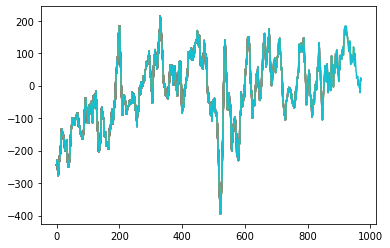

In [8]:
train_agent(agentDQ1, env, episodes = 1000)

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0, Exp rate: 0.98, Score: -103.44035982260391, Average last 100 episodes: nan Time Elapsed: 0h 0m 2s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.001\model_weights\assets
Episode 1, Exp rate: 0.88, Score: -371.4094840949329, Average last 100 episodes: -103.44035982260391 Time Elapsed: 0h 0m 8s
Episode 2, Exp rate: 0.81, Score: -160.93126312575347, Average last 100 episodes: -237.4249219587684 Time Elapsed: 0h 0m 13s
Episode 3, Exp rate: 0.73, Score: -99.30435465846138, Average last 100 episodes: -211.92703568109675 Time Elapsed: 0h 0m 19s
Episode 4, Exp rate: 0.66, Score: -186.3575501662265, Average last 100 episodes: -183.77136542543792 Time Elapsed: 0h 0m 25s
Episode 5, Exp rate: 0.58, Score: -8.310839323551392, Average last 100 episodes: -184.28860237359564 Time Elapsed: 0h 0m 33s
Episode 6, Exp rate: 0.54, Score: -22.563254254081443, Average last 100 episodes: -154.95897519858826 Time Elapsed: 0h 0m 38s
Episode 7, Exp rate: 0.49, Score: -130.27188056590964, Average

Episode 63, Exp rate: 0.01, Score: -264.712633300937, Average last 100 episodes: -249.56807011733756 Time Elapsed: 0h 12m 17s
Episode 64, Exp rate: 0.01, Score: -270.8490189963721, Average last 100 episodes: -249.80470391708127 Time Elapsed: 0h 12m 40s
Episode 65, Exp rate: 0.01, Score: -181.79658047957622, Average last 100 episodes: -250.12846261060884 Time Elapsed: 0h 12m 47s
Episode 66, Exp rate: 0.01, Score: -136.3795980489342, Average last 100 episodes: -249.09313106316895 Time Elapsed: 0h 12m 57s
Episode 67, Exp rate: 0.01, Score: -314.63498946881543, Average last 100 episodes: -247.41083952564304 Time Elapsed: 0h 13m 18s
Episode 68, Exp rate: 0.01, Score: -297.45030095739935, Average last 100 episodes: -248.39942996598378 Time Elapsed: 0h 13m 44s
Episode 69, Exp rate: 0.01, Score: -77.58428958519148, Average last 100 episodes: -249.1103121542652 Time Elapsed: 0h 13m 53s
Episode 70, Exp rate: 0.01, Score: -168.67943028103807, Average last 100 episodes: -246.65994040327845 Time El

Episode 126, Exp rate: 0.01, Score: -292.70282309849534, Average last 100 episodes: -223.03896447522663 Time Elapsed: 0h 37m 21s
Episode 127, Exp rate: 0.01, Score: -332.7347098036257, Average last 100 episodes: -223.8714582040879 Time Elapsed: 0h 37m 31s
Episode 128, Exp rate: 0.01, Score: -327.1141662135341, Average last 100 episodes: -224.0426154079735 Time Elapsed: 0h 38m 43s
Episode 129, Exp rate: 0.01, Score: -126.83212021706859, Average last 100 episodes: -223.08039297173698 Time Elapsed: 0h 38m 56s
Episode 130, Exp rate: 0.01, Score: -504.7429600478675, Average last 100 episodes: -222.53318020187925 Time Elapsed: 0h 39m 4s
Episode 131, Exp rate: 0.01, Score: -106.44928351891396, Average last 100 episodes: -226.34864895892136 Time Elapsed: 0h 39m 20s
Episode 132, Exp rate: 0.01, Score: -96.95211223132232, Average last 100 episodes: -225.27905402529063 Time Elapsed: 0h 39m 33s
Episode 133, Exp rate: 0.01, Score: -136.07261595214248, Average last 100 episodes: -223.69226790708126 

Episode 189, Exp rate: 0.01, Score: -194.5786088400494, Average last 100 episodes: -198.6992938875396 Time Elapsed: 1h 7m 40s
Episode 190, Exp rate: 0.01, Score: -237.79428832819985, Average last 100 episodes: -198.88123521901014 Time Elapsed: 1h 7m 52s
Episode 191, Exp rate: 0.01, Score: -151.07006247274722, Average last 100 episodes: -198.85932799352514 Time Elapsed: 1h 8m 4s
Episode 192, Exp rate: 0.01, Score: -226.81873502871895, Average last 100 episodes: -199.29926918292458 Time Elapsed: 1h 8m 23s
Episode 193, Exp rate: 0.01, Score: -468.9588462998008, Average last 100 episodes: -200.77255312907337 Time Elapsed: 1h 8m 52s
Episode 194, Exp rate: 0.01, Score: -184.85329075434373, Average last 100 episodes: -204.39254204819298 Time Elapsed: 1h 9m 33s
Episode 195, Exp rate: 0.01, Score: -193.47327857852378, Average last 100 episodes: -205.8101073756329 Time Elapsed: 1h 9m 54s
Episode 196, Exp rate: 0.01, Score: -413.61532399338955, Average last 100 episodes: -205.0275496216516 Time E

Episode 252, Exp rate: 0.01, Score: -318.9473887388407, Average last 100 episodes: -215.28963822638096 Time Elapsed: 2h 3m 4s
Episode 253, Exp rate: 0.01, Score: -295.7736098267031, Average last 100 episodes: -217.46377992827107 Time Elapsed: 2h 3m 13s
Episode 254, Exp rate: 0.01, Score: -252.9844404449453, Average last 100 episodes: -218.99417370389156 Time Elapsed: 2h 3m 20s
Episode 255, Exp rate: 0.01, Score: -212.69729948537253, Average last 100 episodes: -220.30325441003822 Time Elapsed: 2h 3m 54s
Episode 256, Exp rate: 0.01, Score: -343.5931438206146, Average last 100 episodes: -221.39718738260154 Time Elapsed: 2h 4m 34s
Episode 257, Exp rate: 0.01, Score: -153.9711531170616, Average last 100 episodes: -224.46709797067987 Time Elapsed: 2h 4m 45s
Episode 258, Exp rate: 0.01, Score: -121.90350405162798, Average last 100 episodes: -224.22180469076517 Time Elapsed: 2h 6m 14s
Episode 259, Exp rate: 0.01, Score: -282.98486632342895, Average last 100 episodes: -223.60761555838914 Time E

Episode 315, Exp rate: 0.01, Score: -151.81175971344675, Average last 100 episodes: -170.28877855289153 Time Elapsed: 2h 51m 30s
Episode 316, Exp rate: 0.01, Score: 47.304278627301485, Average last 100 episodes: -170.51812882261595 Time Elapsed: 2h 52m 58s
Episode 317, Exp rate: 0.01, Score: -330.4137976644479, Average last 100 episodes: -168.5761748275466 Time Elapsed: 2h 53m 8s
Episode 318, Exp rate: 0.01, Score: -232.50764397493398, Average last 100 episodes: -169.916031929534 Time Elapsed: 2h 53m 30s
Episode 319, Exp rate: 0.01, Score: -113.42611869096248, Average last 100 episodes: -170.45974107419536 Time Elapsed: 2h 53m 46s
Episode 320, Exp rate: 0.01, Score: 18.10038351348348, Average last 100 episodes: -170.16611901352906 Time Elapsed: 2h 54m 3s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.001\model_weights\assets
Episode 321, Exp rate: 0.01, Score: 57.260632855463285, Average last 100 episodes: -168.55101937795501 Time Elapsed: 2h 54m 15s
Episode 322, Exp rate: 0.01,

Episode 378, Exp rate: 0.01, Score: -266.2480290648317, Average last 100 episodes: -108.69622123844262 Time Elapsed: 3h 30m 20s
Episode 379, Exp rate: 0.01, Score: -422.85268017319794, Average last 100 episodes: -110.54414450764207 Time Elapsed: 3h 30m 49s
Episode 380, Exp rate: 0.01, Score: -197.00619979062697, Average last 100 episodes: -113.89171292520098 Time Elapsed: 3h 31m 54s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.001\model_weights\assets
Episode 381, Exp rate: 0.01, Score: -444.7954282911956, Average last 100 episodes: -115.36412673270831 Time Elapsed: 3h 32m 5s
Episode 382, Exp rate: 0.01, Score: -108.90579184600179, Average last 100 episodes: -117.80041822696104 Time Elapsed: 3h 32m 20s
Episode 383, Exp rate: 0.01, Score: -176.14270568879982, Average last 100 episodes: -119.12061498850564 Time Elapsed: 3h 32m 31s
Episode 384, Exp rate: 0.01, Score: -105.66829270822954, Average last 100 episodes: -120.23908942662378 Time Elapsed: 3h 32m 44s
Episode 385, Exp rate

INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.001\model_weights\assets
Episode 441, Exp rate: 0.01, Score: -441.68944850581255, Average last 100 episodes: -142.41220725025204 Time Elapsed: 4h 8m 26s
Episode 442, Exp rate: 0.01, Score: -280.77299494246637, Average last 100 episodes: -145.41198420600588 Time Elapsed: 4h 9m 55s
Episode 443, Exp rate: 0.01, Score: -214.59143878704512, Average last 100 episodes: -148.102940893726 Time Elapsed: 4h 11m 25s
Episode 444, Exp rate: 0.01, Score: -279.8827077356812, Average last 100 episodes: -147.70624614569232 Time Elapsed: 4h 11m 42s
Episode 445, Exp rate: 0.01, Score: -125.08427124245506, Average last 100 episodes: -147.98689068093827 Time Elapsed: 4h 11m 57s
Episode 446, Exp rate: 0.01, Score: -232.4259298692635, Average last 100 episodes: -151.82670900889255 Time Elapsed: 4h 12m 11s
Episode 447, Exp rate: 0.01, Score: -587.4615597299774, Average last 100 episodes: -153.34739643168055 Time Elapsed: 4h 12m 26s
Episode 448, Exp rate: 0.

Episode 503, Exp rate: 0.01, Score: -141.78189710259335, Average last 100 episodes: -169.47206818548992 Time Elapsed: 4h 38m 39s
Episode 504, Exp rate: 0.01, Score: -124.6796338278078, Average last 100 episodes: -169.34417011153784 Time Elapsed: 4h 38m 56s
Episode 505, Exp rate: 0.01, Score: -98.90206997809959, Average last 100 episodes: -168.83946547368228 Time Elapsed: 4h 39m 9s
Episode 506, Exp rate: 0.01, Score: -114.37040164707413, Average last 100 episodes: -168.32182745787023 Time Elapsed: 4h 39m 25s
Episode 507, Exp rate: 0.01, Score: -155.57564181972435, Average last 100 episodes: -168.61188038081912 Time Elapsed: 4h 39m 36s
Episode 508, Exp rate: 0.01, Score: -422.486924627941, Average last 100 episodes: -168.776409513163 Time Elapsed: 4h 40m 4s
Episode 509, Exp rate: 0.01, Score: -240.46320474081926, Average last 100 episodes: -171.0866684344933 Time Elapsed: 4h 40m 12s
Episode 510, Exp rate: 0.01, Score: -132.70631442635877, Average last 100 episodes: -171.62078474426514 Ti

Episode 566, Exp rate: 0.01, Score: -235.86329599651373, Average last 100 episodes: -158.2460027150281 Time Elapsed: 4h 55m 55s
Episode 567, Exp rate: 0.01, Score: -152.5267802152597, Average last 100 episodes: -159.07536405829083 Time Elapsed: 4h 57m 25s
Episode 568, Exp rate: 0.01, Score: -192.997426969118, Average last 100 episodes: -159.52756601767572 Time Elapsed: 4h 57m 56s
Episode 569, Exp rate: 0.01, Score: -306.0681678101139, Average last 100 episodes: -160.93862347025674 Time Elapsed: 4h 58m 51s
Episode 570, Exp rate: 0.01, Score: -148.53377433895406, Average last 100 episodes: -162.34309489168328 Time Elapsed: 4h 59m 11s
Episode 571, Exp rate: 0.01, Score: -46.67393594520144, Average last 100 episodes: -163.43634432284213 Time Elapsed: 5h 0m 40s
Episode 572, Exp rate: 0.01, Score: -71.96901783512317, Average last 100 episodes: -163.6550484474517 Time Elapsed: 5h 0m 55s
Episode 573, Exp rate: 0.01, Score: -70.37007166146189, Average last 100 episodes: -166.45770405451887 Time

Episode 629, Exp rate: 0.01, Score: -96.25779306209822, Average last 100 episodes: -156.81616239803662 Time Elapsed: 5h 26m 59s
Episode 630, Exp rate: 0.01, Score: 34.53866774005695, Average last 100 episodes: -157.02577215634804 Time Elapsed: 5h 27m 18s
Episode 631, Exp rate: 0.01, Score: -14.069262943567955, Average last 100 episodes: -156.03401786889083 Time Elapsed: 5h 28m 49s
Episode 632, Exp rate: 0.01, Score: 127.98546912326536, Average last 100 episodes: -155.2524269750925 Time Elapsed: 5h 29m 51s
Episode 633, Exp rate: 0.01, Score: -162.7410338307793, Average last 100 episodes: -151.81521487091533 Time Elapsed: 5h 29m 57s
Episode 634, Exp rate: 0.01, Score: 3.794983565869302, Average last 100 episodes: -152.78078645650606 Time Elapsed: 5h 30m 7s
Episode 635, Exp rate: 0.01, Score: 210.11795193888116, Average last 100 episodes: -151.65458209215063 Time Elapsed: 5h 30m 41s
Episode 636, Exp rate: 0.01, Score: -57.79162473917505, Average last 100 episodes: -148.44040352444077 Time

Episode 692, Exp rate: 0.01, Score: -253.60652958286155, Average last 100 episodes: -156.5586784186552 Time Elapsed: 5h 46m 40s
Episode 693, Exp rate: 0.01, Score: -140.71120509531158, Average last 100 episodes: -155.9806323464433 Time Elapsed: 5h 47m 18s
Episode 694, Exp rate: 0.01, Score: -95.2447100782121, Average last 100 episodes: -153.92272697653064 Time Elapsed: 5h 48m 46s
Episode 695, Exp rate: 0.01, Score: -152.40254540795254, Average last 100 episodes: -152.95134444197257 Time Elapsed: 5h 50m 16s
Episode 696, Exp rate: 0.01, Score: -99.27291783952771, Average last 100 episodes: -153.0143670184241 Time Elapsed: 5h 51m 44s
Episode 697, Exp rate: 0.01, Score: -74.31575540097755, Average last 100 episodes: -153.35522511070397 Time Elapsed: 5h 53m 13s
Episode 698, Exp rate: 0.01, Score: -83.52973976206302, Average last 100 episodes: -149.72652101981194 Time Elapsed: 5h 53m 21s
Episode 699, Exp rate: 0.01, Score: -208.87617650413307, Average last 100 episodes: -145.72972435595284 T

Episode 755, Exp rate: 0.01, Score: 258.6529513346124, Average last 100 episodes: -137.41618616984223 Time Elapsed: 6h 24m 52s
Episode 756, Exp rate: 0.01, Score: -159.04328759078268, Average last 100 episodes: -133.2117660409857 Time Elapsed: 6h 25m 0s
Episode 757, Exp rate: 0.01, Score: -2.146272845309042, Average last 100 episodes: -137.12648296456817 Time Elapsed: 6h 25m 9s
Episode 758, Exp rate: 0.01, Score: -283.9667989937436, Average last 100 episodes: -134.11941865239908 Time Elapsed: 6h 25m 16s
Episode 759, Exp rate: 0.01, Score: -237.12443263307406, Average last 100 episodes: -134.58933502351675 Time Elapsed: 6h 25m 21s
Episode 760, Exp rate: 0.01, Score: -168.10600938222746, Average last 100 episodes: -136.1126949611906 Time Elapsed: 6h 25m 26s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.001\model_weights\assets
Episode 761, Exp rate: 0.01, Score: -250.0399852334416, Average last 100 episodes: -136.7811003489495 Time Elapsed: 6h 25m 38s
Episode 762, Exp rate: 0.01,

Episode 818, Exp rate: 0.01, Score: -174.9363541501833, Average last 100 episodes: -114.49500758352491 Time Elapsed: 6h 40m 9s
Episode 819, Exp rate: 0.01, Score: 230.80436772004828, Average last 100 episodes: -115.82092774322253 Time Elapsed: 6h 40m 47s
Episode 820, Exp rate: 0.01, Score: -193.90654217686992, Average last 100 episodes: -111.75740062680437 Time Elapsed: 6h 40m 55s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.001\model_weights\assets
Episode 821, Exp rate: 0.01, Score: -57.93164408598393, Average last 100 episodes: -112.46189389636224 Time Elapsed: 6h 41m 15s
Episode 822, Exp rate: 0.01, Score: -90.65829217014311, Average last 100 episodes: -112.45787130994839 Time Elapsed: 6h 41m 22s
Episode 823, Exp rate: 0.01, Score: -98.85256329195296, Average last 100 episodes: -113.15329091707423 Time Elapsed: 6h 41m 33s
Episode 824, Exp rate: 0.01, Score: -52.28707241810261, Average last 100 episodes: -112.77776507723655 Time Elapsed: 6h 41m 38s
Episode 825, Exp rate: 0.

INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.001\model_weights\assets
Episode 881, Exp rate: 0.01, Score: -105.9029776514372, Average last 100 episodes: -97.38881402414795 Time Elapsed: 7h 28m 20s
Episode 882, Exp rate: 0.01, Score: -289.92890884264773, Average last 100 episodes: -97.53265615761204 Time Elapsed: 7h 29m 19s
Episode 883, Exp rate: 0.01, Score: -237.40134013221527, Average last 100 episodes: -99.95179248832272 Time Elapsed: 7h 29m 31s
Episode 884, Exp rate: 0.01, Score: -119.66425548336488, Average last 100 episodes: -101.58761667224886 Time Elapsed: 7h 29m 42s
Episode 885, Exp rate: 0.01, Score: -234.80916773980118, Average last 100 episodes: -103.08654130879437 Time Elapsed: 7h 29m 51s
Episode 886, Exp rate: 0.01, Score: -286.7641087876593, Average last 100 episodes: -105.17923279849958 Time Elapsed: 7h 30m 1s
Episode 887, Exp rate: 0.01, Score: -295.75795225491163, Average last 100 episodes: -107.78158259550739 Time Elapsed: 7h 30m 9s
Episode 888, Exp rate: 0.

Episode 943, Exp rate: 0.01, Score: -20.04464330826567, Average last 100 episodes: -119.438941617188 Time Elapsed: 7h 55m 46s
Episode 944, Exp rate: 0.01, Score: -25.88556630542665, Average last 100 episodes: -119.38707158958843 Time Elapsed: 7h 57m 13s
Episode 945, Exp rate: 0.01, Score: -134.32687287532224, Average last 100 episodes: -118.99296036697062 Time Elapsed: 7h 57m 48s
Episode 946, Exp rate: 0.01, Score: -66.82837968139431, Average last 100 episodes: -120.09253084124008 Time Elapsed: 7h 59m 17s
Episode 947, Exp rate: 0.01, Score: -123.36722380145306, Average last 100 episodes: -119.93564605240208 Time Elapsed: 8h 0m 45s
Episode 948, Exp rate: 0.01, Score: -15.642141845331528, Average last 100 episodes: -120.91624039093733 Time Elapsed: 8h 2m 13s
Episode 949, Exp rate: 0.01, Score: -0.060758734288783645, Average last 100 episodes: -120.63035861765036 Time Elapsed: 8h 3m 42s
Episode 950, Exp rate: 0.01, Score: -71.61269891551265, Average last 100 episodes: -120.02363927710087 

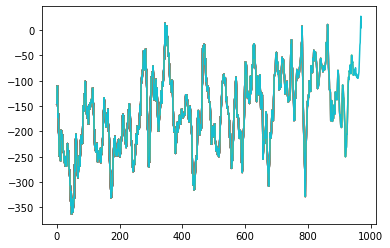

In [9]:
train_agent(agentDQ2, env, episodes = 1000)

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0, Exp rate: 0.99, Score: -83.41490655295125, Average last 100 episodes: nan Time Elapsed: 0h 0m 1s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.01\model_weights\assets
Episode 1, Exp rate: 0.91, Score: -61.14883497379227, Average last 100 episodes: -83.41490655295125 Time Elapsed: 0h 0m 6s
Episode 2, Exp rate: 0.77, Score: -274.9750701879375, Average last 100 episodes: -72.28187076337176 Time Elapsed: 0h 0m 15s
Episode 3, Exp rate: 0.71, Score: -259.62983924781395, Average last 100 episodes: -139.84627057156032 Time Elapsed: 0h 0m 20s
Episode 4, Exp rate: 0.66, Score: -239.01953772058462, Average last 100 episodes: -169.79216274062372 Time Elapsed: 0h 0m 25s
Episode 5, Exp rate: 0.61, Score: -122.31509284700216, Average last 100 episodes: -183.6376377366159 Time Elapsed: 0h 0m 29s
Episode 6, Exp rate: 0.55, Score: -127.16493767941516, Average last 100 episodes: -173.41721358834695 Time Elapsed: 0h 0m 37s
Episode 7, Exp rate: 0.51, Score: -71.76015005831528, Average la

Episode 63, Exp rate: 0.01, Score: -105.70103443749268, Average last 100 episodes: -398.68623029826415 Time Elapsed: 0h 11m 39s
Episode 64, Exp rate: 0.01, Score: -135.54547040810218, Average last 100 episodes: -394.10833661293964 Time Elapsed: 0h 11m 49s
Episode 65, Exp rate: 0.01, Score: -92.1512315004733, Average last 100 episodes: -390.13044636363446 Time Elapsed: 0h 12m 4s
Episode 66, Exp rate: 0.01, Score: -303.35031618121036, Average last 100 episodes: -385.61560977479866 Time Elapsed: 0h 12m 16s
Episode 67, Exp rate: 0.01, Score: -187.1179382656753, Average last 100 episodes: -384.3877695719093 Time Elapsed: 0h 12m 28s
Episode 68, Exp rate: 0.01, Score: -155.5821536984243, Average last 100 episodes: -381.48674264093523 Time Elapsed: 0h 12m 35s
Episode 69, Exp rate: 0.01, Score: -509.1665310116736, Average last 100 episodes: -378.2127630910438 Time Elapsed: 0h 12m 45s
Episode 70, Exp rate: 0.01, Score: -227.96337026678125, Average last 100 episodes: -380.08353120419565 Time Elap

Episode 126, Exp rate: 0.01, Score: -207.50811237634355, Average last 100 episodes: -493.7060160175624 Time Elapsed: 0h 34m 22s
Episode 127, Exp rate: 0.01, Score: -223.17399484467145, Average last 100 episodes: -492.576670049468 Time Elapsed: 0h 34m 29s
Episode 128, Exp rate: 0.01, Score: -237.27510850531596, Average last 100 episodes: -491.6551025351517 Time Elapsed: 0h 34m 35s
Episode 129, Exp rate: 0.01, Score: -1236.493939142921, Average last 100 episodes: -491.12471515447766 Time Elapsed: 0h 35m 9s
Episode 130, Exp rate: 0.01, Score: -307.77605333120664, Average last 100 episodes: -499.5913691646623 Time Elapsed: 0h 35m 15s
Episode 131, Exp rate: 0.01, Score: -259.1221833549637, Average last 100 episodes: -499.3678972354342 Time Elapsed: 0h 35m 24s
Episode 132, Exp rate: 0.01, Score: -591.9167847425012, Average last 100 episodes: -498.5857451772114 Time Elapsed: 0h 35m 37s
Episode 133, Exp rate: 0.01, Score: -379.90107488779245, Average last 100 episodes: -501.4045386623789 Time 

Episode 189, Exp rate: 0.01, Score: -605.3520422632341, Average last 100 episodes: -484.5616791403679 Time Elapsed: 0h 45m 55s
Episode 190, Exp rate: 0.01, Score: -469.3277342279025, Average last 100 episodes: -481.3459386628611 Time Elapsed: 0h 46m 11s
Episode 191, Exp rate: 0.01, Score: -345.4791263742395, Average last 100 episodes: -476.7394412736997 Time Elapsed: 0h 46m 19s
Episode 192, Exp rate: 0.01, Score: -316.83873467727284, Average last 100 episodes: -475.91963248362845 Time Elapsed: 0h 46m 35s
Episode 193, Exp rate: 0.01, Score: -188.82522980308886, Average last 100 episodes: -472.88647798635384 Time Elapsed: 0h 46m 51s
Episode 194, Exp rate: 0.01, Score: -433.9756804343735, Average last 100 episodes: -467.63742559419376 Time Elapsed: 0h 47m 37s
Episode 195, Exp rate: 0.01, Score: -189.85897256231692, Average last 100 episodes: -466.5715788429475 Time Elapsed: 0h 47m 50s
Episode 196, Exp rate: 0.01, Score: -434.2144553855618, Average last 100 episodes: -463.18781024494297 Ti

Episode 252, Exp rate: 0.01, Score: -186.16407962099993, Average last 100 episodes: -394.1622178182609 Time Elapsed: 1h 1m 34s
Episode 253, Exp rate: 0.01, Score: -178.36385648962863, Average last 100 episodes: -390.13212921109186 Time Elapsed: 1h 1m 41s
Episode 254, Exp rate: 0.01, Score: -239.23364392138103, Average last 100 episodes: -388.96603067002764 Time Elapsed: 1h 1m 59s
Episode 255, Exp rate: 0.01, Score: -418.2148598744187, Average last 100 episodes: -387.4968822030715 Time Elapsed: 1h 2m 9s
Episode 256, Exp rate: 0.01, Score: -381.32077281155205, Average last 100 episodes: -391.10165290738803 Time Elapsed: 1h 2m 25s
Episode 257, Exp rate: 0.01, Score: -446.86707560795, Average last 100 episodes: -390.45187558525885 Time Elapsed: 1h 2m 36s
Episode 258, Exp rate: 0.01, Score: -103.90693726704077, Average last 100 episodes: -394.4966925181823 Time Elapsed: 1h 2m 49s
Episode 259, Exp rate: 0.01, Score: -828.6638328223971, Average last 100 episodes: -392.4981327809674 Time Elaps

Episode 315, Exp rate: 0.01, Score: -224.11767834990167, Average last 100 episodes: -302.6908408151863 Time Elapsed: 1h 17m 30s
Episode 316, Exp rate: 0.01, Score: -292.8522819067696, Average last 100 episodes: -300.9614031382859 Time Elapsed: 1h 17m 58s
Episode 317, Exp rate: 0.01, Score: -95.09705453710025, Average last 100 episodes: -295.86262244725555 Time Elapsed: 1h 18m 3s
Episode 318, Exp rate: 0.01, Score: -184.88901283844103, Average last 100 episodes: -292.89253416448156 Time Elapsed: 1h 18m 17s
Episode 319, Exp rate: 0.01, Score: -87.05299256153285, Average last 100 episodes: -290.5003286176315 Time Elapsed: 1h 18m 28s
Episode 320, Exp rate: 0.01, Score: -188.5617490624225, Average last 100 episodes: -288.24198190064305 Time Elapsed: 1h 19m 7s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.01\model_weights\assets
Episode 321, Exp rate: 0.01, Score: -305.16628347637686, Average last 100 episodes: -287.32486862071295 Time Elapsed: 1h 19m 34s
Episode 322, Exp rate: 0.01,

Episode 378, Exp rate: 0.01, Score: -332.74530363234896, Average last 100 episodes: -272.72939202046024 Time Elapsed: 1h 29m 31s
Episode 379, Exp rate: 0.01, Score: -392.7623820555186, Average last 100 episodes: -275.34900809581177 Time Elapsed: 1h 29m 40s
Episode 380, Exp rate: 0.01, Score: -373.6927276978454, Average last 100 episodes: -277.9009295165678 Time Elapsed: 1h 29m 58s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.01\model_weights\assets
Episode 381, Exp rate: 0.01, Score: -326.7791726626635, Average last 100 episodes: -280.3495279586675 Time Elapsed: 1h 30m 15s
Episode 382, Exp rate: 0.01, Score: -277.5188470676991, Average last 100 episodes: -279.9653966992796 Time Elapsed: 1h 30m 26s
Episode 383, Exp rate: 0.01, Score: -134.68245898854923, Average last 100 episodes: -280.9938766315183 Time Elapsed: 1h 30m 39s
Episode 384, Exp rate: 0.01, Score: -322.3768083040085, Average last 100 episodes: -279.53195865405667 Time Elapsed: 1h 30m 49s
Episode 385, Exp rate: 0.01,

INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.01\model_weights\assets
Episode 441, Exp rate: 0.01, Score: -12.172509295915873, Average last 100 episodes: -243.4186738584498 Time Elapsed: 1h 41m 31s
Episode 442, Exp rate: 0.01, Score: -126.14629333778538, Average last 100 episodes: -242.5556335703399 Time Elapsed: 1h 41m 36s
Episode 443, Exp rate: 0.01, Score: -81.46572196279662, Average last 100 episodes: -242.1273394877122 Time Elapsed: 1h 41m 52s
Episode 444, Exp rate: 0.01, Score: -172.46971601020425, Average last 100 episodes: -239.2658390699323 Time Elapsed: 1h 42m 24s
Episode 445, Exp rate: 0.01, Score: -280.24973190895673, Average last 100 episodes: -236.22462438127602 Time Elapsed: 1h 42m 32s
Episode 446, Exp rate: 0.01, Score: -282.6791268023644, Average last 100 episodes: -237.00821741004182 Time Elapsed: 1h 42m 43s
Episode 447, Exp rate: 0.01, Score: -331.45384931182844, Average last 100 episodes: -237.03022218664316 Time Elapsed: 1h 42m 53s
Episode 448, Exp rate: 0.

Episode 503, Exp rate: 0.01, Score: -462.56437809352155, Average last 100 episodes: -172.2869428606781 Time Elapsed: 1h 54m 4s
Episode 504, Exp rate: 0.01, Score: -384.85520636932415, Average last 100 episodes: -173.67098238277188 Time Elapsed: 1h 54m 23s
Episode 505, Exp rate: 0.01, Score: -1043.7852815660904, Average last 100 episodes: -176.86632958920526 Time Elapsed: 1h 54m 47s
Episode 506, Exp rate: 0.01, Score: -373.2854009694981, Average last 100 episodes: -186.52976313113552 Time Elapsed: 1h 55m 9s
Episode 507, Exp rate: 0.01, Score: -34.455113721277286, Average last 100 episodes: -187.18565378405947 Time Elapsed: 1h 55m 17s
Episode 508, Exp rate: 0.01, Score: -587.9487637614545, Average last 100 episodes: -184.5890122725872 Time Elapsed: 1h 55m 28s
Episode 509, Exp rate: 0.01, Score: -654.3319159983711, Average last 100 episodes: -187.74768130125943 Time Elapsed: 1h 55m 43s
Episode 510, Exp rate: 0.01, Score: -282.86169466285105, Average last 100 episodes: -192.17250924127188 

Episode 566, Exp rate: 0.01, Score: -220.0577707835398, Average last 100 episodes: -289.3231259897512 Time Elapsed: 2h 11m 53s
Episode 567, Exp rate: 0.01, Score: -322.88699641296046, Average last 100 episodes: -290.55522589614424 Time Elapsed: 2h 12m 9s
Episode 568, Exp rate: 0.01, Score: -151.7202739508925, Average last 100 episodes: -292.2692295237546 Time Elapsed: 2h 12m 17s
Episode 569, Exp rate: 0.01, Score: -141.14009599684627, Average last 100 episodes: -292.93417325134754 Time Elapsed: 2h 12m 29s
Episode 570, Exp rate: 0.01, Score: -164.3945385171627, Average last 100 episodes: -292.0977075101036 Time Elapsed: 2h 12m 41s
Episode 571, Exp rate: 0.01, Score: -199.43656171430746, Average last 100 episodes: -293.5365802476808 Time Elapsed: 2h 12m 57s
Episode 572, Exp rate: 0.01, Score: -156.7234584906556, Average last 100 episodes: -295.0487700611606 Time Elapsed: 2h 13m 5s
Episode 573, Exp rate: 0.01, Score: -29.01903138229173, Average last 100 episodes: -295.89716142960026 Time 

Episode 629, Exp rate: 0.01, Score: -419.5540298266395, Average last 100 episodes: -310.1292323985409 Time Elapsed: 2h 25m 43s
Episode 630, Exp rate: 0.01, Score: -122.14143692584058, Average last 100 episodes: -309.77943935293194 Time Elapsed: 2h 26m 9s
Episode 631, Exp rate: 0.01, Score: -124.75594253749455, Average last 100 episodes: -310.06617543594774 Time Elapsed: 2h 26m 16s
Episode 632, Exp rate: 0.01, Score: -179.30258952973156, Average last 100 episodes: -309.99680334759995 Time Elapsed: 2h 26m 25s
Episode 633, Exp rate: 0.01, Score: -190.68233277611762, Average last 100 episodes: -305.5752575526397 Time Elapsed: 2h 26m 39s
Episode 634, Exp rate: 0.01, Score: -195.9942779298873, Average last 100 episodes: -301.97632883133525 Time Elapsed: 2h 26m 44s
Episode 635, Exp rate: 0.01, Score: -277.2047478948007, Average last 100 episodes: -299.2383079731371 Time Elapsed: 2h 26m 54s
Episode 636, Exp rate: 0.01, Score: -85.0026703241493, Average last 100 episodes: -301.85139084739063 Ti

Episode 692, Exp rate: 0.01, Score: -113.75225885420224, Average last 100 episodes: -245.62009005170478 Time Elapsed: 2h 36m 23s
Episode 693, Exp rate: 0.01, Score: -88.5753628308708, Average last 100 episodes: -235.19054102737564 Time Elapsed: 2h 36m 29s
Episode 694, Exp rate: 0.01, Score: -513.967166953215, Average last 100 episodes: -233.97307605050435 Time Elapsed: 2h 36m 49s
Episode 695, Exp rate: 0.01, Score: -498.8789078729368, Average last 100 episodes: -238.70360386421942 Time Elapsed: 2h 37m 1s
Episode 696, Exp rate: 0.01, Score: -138.72782785967414, Average last 100 episodes: -241.62871839114004 Time Elapsed: 2h 37m 20s
Episode 697, Exp rate: 0.01, Score: -150.80608492797919, Average last 100 episodes: -237.49521158573248 Time Elapsed: 2h 37m 29s
Episode 698, Exp rate: 0.01, Score: -595.493100094271, Average last 100 episodes: -236.0638679436852 Time Elapsed: 2h 37m 50s
Episode 699, Exp rate: 0.01, Score: -166.9904007340629, Average last 100 episodes: -239.0128316898266 Time

Episode 755, Exp rate: 0.01, Score: -312.18411246454934, Average last 100 episodes: -268.63684012531206 Time Elapsed: 2h 49m 34s
Episode 756, Exp rate: 0.01, Score: -311.32898203231804, Average last 100 episodes: -268.6482442657353 Time Elapsed: 2h 49m 44s
Episode 757, Exp rate: 0.01, Score: -224.1038639230506, Average last 100 episodes: -271.49153830721133 Time Elapsed: 2h 49m 51s
Episode 758, Exp rate: 0.01, Score: -205.180082259083, Average last 100 episodes: -272.35672559814645 Time Elapsed: 2h 50m 0s
Episode 759, Exp rate: 0.01, Score: -511.4072752968512, Average last 100 episodes: -270.68285526715914 Time Elapsed: 2h 50m 10s
Episode 760, Exp rate: 0.01, Score: -168.2362163521176, Average last 100 episodes: -274.1022756644447 Time Elapsed: 2h 50m 24s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.01\model_weights\assets
Episode 761, Exp rate: 0.01, Score: -51.15982941906097, Average last 100 episodes: -273.6945724120542 Time Elapsed: 2h 50m 36s
Episode 762, Exp rate: 0.01, 

Episode 818, Exp rate: 0.01, Score: -162.2411812684767, Average last 100 episodes: -268.0634674649914 Time Elapsed: 2h 59m 57s
Episode 819, Exp rate: 0.01, Score: -354.4215586941132, Average last 100 episodes: -263.61116527218076 Time Elapsed: 3h 0m 6s
Episode 820, Exp rate: 0.01, Score: -112.9760643777531, Average last 100 episodes: -263.867074552235 Time Elapsed: 3h 0m 14s
INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.01\model_weights\assets
Episode 821, Exp rate: 0.01, Score: -131.95335808421729, Average last 100 episodes: -261.4773421274217 Time Elapsed: 3h 0m 19s
Episode 822, Exp rate: 0.01, Score: -367.6614594032927, Average last 100 episodes: -260.3803580415549 Time Elapsed: 3h 0m 34s
Episode 823, Exp rate: 0.01, Score: -469.03887740694023, Average last 100 episodes: -258.21633226707246 Time Elapsed: 3h 0m 41s
Episode 824, Exp rate: 0.01, Score: -337.4784876660503, Average last 100 episodes: -260.1793317848533 Time Elapsed: 3h 0m 50s
Episode 825, Exp rate: 0.01, Score: -

INFO:tensorflow:Assets written to: storage\DQ_v1_lr_0.01\model_weights\assets
Episode 881, Exp rate: 0.01, Score: -1035.015157038462, Average last 100 episodes: -280.76643214846735 Time Elapsed: 3h 10m 43s
Episode 882, Exp rate: 0.01, Score: -340.3618883918763, Average last 100 episodes: -290.99021824303804 Time Elapsed: 3h 10m 52s
Episode 883, Exp rate: 0.01, Score: -321.0913218303439, Average last 100 episodes: -292.05493333499857 Time Elapsed: 3h 10m 57s
Episode 884, Exp rate: 0.01, Score: -544.9903992272584, Average last 100 episodes: -294.3193872352007 Time Elapsed: 3h 11m 4s
Episode 885, Exp rate: 0.01, Score: -701.3082871777149, Average last 100 episodes: -297.57927348982923 Time Elapsed: 3h 11m 13s
Episode 886, Exp rate: 0.01, Score: -184.666995446569, Average last 100 episodes: -303.0402213351098 Time Elapsed: 3h 11m 22s
Episode 887, Exp rate: 0.01, Score: -152.12054464605617, Average last 100 episodes: -303.2756321907259 Time Elapsed: 3h 11m 30s
Episode 888, Exp rate: 0.01, S

Episode 943, Exp rate: 0.01, Score: -68.73024358535082, Average last 100 episodes: -377.3039698263547 Time Elapsed: 3h 19m 23s
Episode 944, Exp rate: 0.01, Score: -301.35949485372794, Average last 100 episodes: -374.87822411494847 Time Elapsed: 3h 19m 32s
Episode 945, Exp rate: 0.01, Score: -400.99519800644674, Average last 100 episodes: -376.9088722725821 Time Elapsed: 3h 19m 37s
Episode 946, Exp rate: 0.01, Score: -327.1710737141164, Average last 100 episodes: -376.92740718181926 Time Elapsed: 3h 19m 43s
Episode 947, Exp rate: 0.01, Score: -326.63554173703886, Average last 100 episodes: -379.6084498711257 Time Elapsed: 3h 19m 49s
Episode 948, Exp rate: 0.01, Score: -148.02859319088887, Average last 100 episodes: -377.3743346645027 Time Elapsed: 3h 19m 56s
Episode 949, Exp rate: 0.01, Score: -368.65945941724704, Average last 100 episodes: -371.7518514533482 Time Elapsed: 3h 20m 1s
Episode 950, Exp rate: 0.01, Score: -432.1401216147615, Average last 100 episodes: -374.4959224655697 Tim

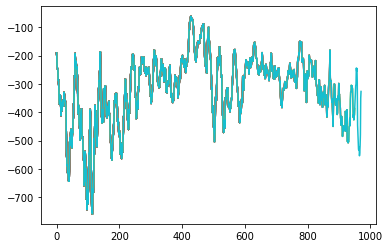

In [10]:
train_agent(agentDQ3, env, episodes = 1000)

### Results

We see from the results that the learning rate has an important effect on the ability of the agent to solve the environment. The agent with learning rate 0.01 which is too high is not able to converge, while the agents with lower learning rates appear to be learning but after 1000 episodes haven't solved the environment yet. To save on computation time we will try to improve the agents and not solve the environment with these simple DQN agents.

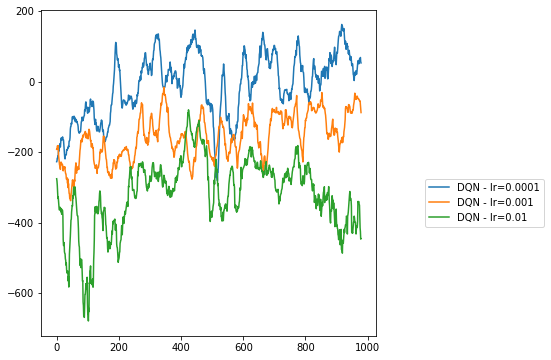

In [48]:
scores = [agentDQ1.training_scores,agentDQ2.training_scores,agentDQ3.training_scores]
names = ["DQN - lr=0.0001", "DQN - lr=0.001", "DQN - lr=0.01"]
plot_scores(scores, names)

## Adding experience replay

To get better results, we add experience replay. This means that the agent saves the actions and states for a longer period of time, and trains not only on the last events but also on previous events all the time. This prevents the agent from "forgetting" what happened in previous episodes and allows learning to be more efficient and stable. We will set the memory size to 640000 which should be enough to store all 1000 episodes. We will test 2 different learning rates and compare the results to the results of the simple DQN agents without experience replay.

In [ ]:
agentDQ4 = DQAgent(state_size, action_size, "storage/DQ_v2_lr_0.0001", gamma=0.99, learning_rate=0.0001, memory_size=640000)
agentDQ5 = DQAgent(state_size, action_size, "storage/DQ_v2_lr_0.001", gamma=0.99, learning_rate=0.001, memory_size=640000)

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0, Exp rate: 0.96, Score: -403.677870113609, Average last 100 episodes: nan Time Elapsed: 0h 0m 3s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.0001\model_weights\assets
Episode 1, Exp rate: 0.87, Score: -278.33668488938184, Average last 100 episodes: -403.677870113609 Time Elapsed: 0h 0m 8s
Episode 2, Exp rate: 0.77, Score: -213.88932102380858, Average last 100 episodes: -341.0072775014954 Time Elapsed: 0h 0m 16s
Episode 3, Exp rate: 0.71, Score: -132.04509725284794, Average last 100 episodes: -298.6346253422665 Time Elapsed: 0h 0m 21s
Episode 4, Exp rate: 0.66, Score: -86.45725408054182, Average last 100 episodes: -256.98724331991184 Time Elapsed: 0h 0m 26s
Episode 5, Exp rate: 0.58, Score: -234.67131372729278, Average last 100 episodes: -222.88124547203785 Time Elapsed: 0h 0m 34s
Episode 6, Exp rate: 0.51, Score: -297.8056564957027, Average last 100 episodes: -224.84625684791365 Time Elapsed: 0h 0m 42s
Episode 7, Exp rate: 0.47, Score: -95.12140265377921, Average la

Episode 63, Exp rate: 0.01, Score: -51.56355271891728, Average last 100 episodes: -130.79613868182574 Time Elapsed: 0h 53m 20s
Episode 64, Exp rate: 0.01, Score: -52.01301329350752, Average last 100 episodes: -129.55812952615528 Time Elapsed: 0h 54m 54s
Episode 65, Exp rate: 0.01, Score: -73.92302528147344, Average last 100 episodes: -128.3651277379607 Time Elapsed: 0h 55m 14s
Episode 66, Exp rate: 0.01, Score: -70.38487902907302, Average last 100 episodes: -127.54024739771091 Time Elapsed: 0h 56m 49s
Episode 67, Exp rate: 0.01, Score: -71.59536885458583, Average last 100 episodes: -126.687182198179 Time Elapsed: 0h 58m 24s
Episode 68, Exp rate: 0.01, Score: -40.58954767002471, Average last 100 episodes: -125.87700847253791 Time Elapsed: 0h 59m 56s
Episode 69, Exp rate: 0.01, Score: -63.94386438156693, Average last 100 episodes: -124.64095831597974 Time Elapsed: 1h 1m 28s
Episode 70, Exp rate: 0.01, Score: -29.88784307086908, Average last 100 episodes: -123.77385697405956 Time Elapsed:

Episode 126, Exp rate: 0.01, Score: -31.291591656305467, Average last 100 episodes: -66.37291272525972 Time Elapsed: 2h 22m 31s
Episode 127, Exp rate: 0.01, Score: -14.344312511950877, Average last 100 episodes: -65.09761711369602 Time Elapsed: 2h 24m 1s
Episode 128, Exp rate: 0.01, Score: -29.593710017385856, Average last 100 episodes: -61.12053256274153 Time Elapsed: 2h 25m 33s
Episode 129, Exp rate: 0.01, Score: -4.993555543961773, Average last 100 episodes: -60.06735331186885 Time Elapsed: 2h 27m 6s
Episode 130, Exp rate: 0.01, Score: -27.90369050057696, Average last 100 episodes: -58.75996672912138 Time Elapsed: 2h 28m 37s
Episode 131, Exp rate: 0.01, Score: -5.1849598296783785, Average last 100 episodes: -57.87122022988427 Time Elapsed: 2h 30m 8s
Episode 132, Exp rate: 0.01, Score: -31.344483762654804, Average last 100 episodes: -57.03319922881916 Time Elapsed: 2h 31m 39s
Episode 133, Exp rate: 0.01, Score: -56.17471170069785, Average last 100 episodes: -56.0648960988324 Time Ela

Episode 189, Exp rate: 0.01, Score: -178.79263737547535, Average last 100 episodes: -33.121197094476145 Time Elapsed: 3h 44m 47s
Episode 190, Exp rate: 0.01, Score: -23.512356997367288, Average last 100 episodes: -34.15627207166542 Time Elapsed: 3h 46m 18s
Episode 191, Exp rate: 0.01, Score: -27.731821623519025, Average last 100 episodes: -33.39697591044446 Time Elapsed: 3h 47m 50s
Episode 192, Exp rate: 0.01, Score: -75.62903388510685, Average last 100 episodes: -32.88899673774088 Time Elapsed: 3h 47m 56s
Episode 193, Exp rate: 0.01, Score: -145.37322478711206, Average last 100 episodes: -32.70560651120241 Time Elapsed: 3h 48m 10s
Episode 194, Exp rate: 0.01, Score: -19.715952340680445, Average last 100 episodes: -33.34877962359885 Time Elapsed: 3h 48m 27s
Episode 195, Exp rate: 0.01, Score: -40.01808787549044, Average last 100 episodes: -32.79263854942813 Time Elapsed: 3h 49m 58s
Episode 196, Exp rate: 0.01, Score: -174.75477110457842, Average last 100 episodes: -32.2607873914799 Tim

Episode 252, Exp rate: 0.01, Score: -75.99462095389663, Average last 100 episodes: -36.353224148318304 Time Elapsed: 4h 59m 38s
Episode 253, Exp rate: 0.01, Score: -64.69399217431938, Average last 100 episodes: -36.95283801941553 Time Elapsed: 5h 1m 8s
Episode 254, Exp rate: 0.01, Score: -101.71949797763072, Average last 100 episodes: -37.11568689731604 Time Elapsed: 5h 2m 37s
Episode 255, Exp rate: 0.01, Score: -42.24891620825422, Average last 100 episodes: -37.78878438077284 Time Elapsed: 5h 4m 6s
Episode 256, Exp rate: 0.01, Score: -4.043885950410843, Average last 100 episodes: -37.54366015304707 Time Elapsed: 5h 5m 35s
Episode 257, Exp rate: 0.01, Score: -205.0309669250772, Average last 100 episodes: -37.403095089444975 Time Elapsed: 5h 5m 51s
Episode 258, Exp rate: 0.01, Score: -41.71877054057467, Average last 100 episodes: -39.03957983268717 Time Elapsed: 5h 7m 20s
Episode 259, Exp rate: 0.01, Score: -239.62557855361402, Average last 100 episodes: -39.45844770817523 Time Elapsed:

Episode 315, Exp rate: 0.01, Score: -33.891431743443725, Average last 100 episodes: -52.158656703608045 Time Elapsed: 6h 14m 47s
Episode 316, Exp rate: 0.01, Score: -1.8867304103017537, Average last 100 episodes: -52.37509030979303 Time Elapsed: 6h 16m 21s
Episode 317, Exp rate: 0.01, Score: -63.28948018826989, Average last 100 episodes: -51.927773415498876 Time Elapsed: 6h 17m 53s
Episode 318, Exp rate: 0.01, Score: -36.081049431980645, Average last 100 episodes: -52.39454386638262 Time Elapsed: 6h 19m 24s
Episode 319, Exp rate: 0.01, Score: -30.20793317806849, Average last 100 episodes: -52.85716353034681 Time Elapsed: 6h 20m 56s
Episode 320, Exp rate: 0.01, Score: -44.1313356379148, Average last 100 episodes: -52.62110554813547 Time Elapsed: 6h 22m 28s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.0001\model_weights\assets
Episode 321, Exp rate: 0.01, Score: -56.45117871958296, Average last 100 episodes: -52.56900096665674 Time Elapsed: 6h 24m 1s
Episode 322, Exp rate: 0.01,

Episode 378, Exp rate: 0.01, Score: 29.753784875383683, Average last 100 episodes: -45.16351163167893 Time Elapsed: 7h 46m 51s
Episode 379, Exp rate: 0.01, Score: -6.352818624130212, Average last 100 episodes: -43.19276345372453 Time Elapsed: 7h 48m 24s
Episode 380, Exp rate: 0.01, Score: -58.40353785165459, Average last 100 episodes: -43.652777261502706 Time Elapsed: 7h 49m 56s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.0001\model_weights\assets
Episode 381, Exp rate: 0.01, Score: -37.66080980824857, Average last 100 episodes: -42.37596600088837 Time Elapsed: 7h 51m 31s
Episode 382, Exp rate: 0.01, Score: -34.63363786827026, Average last 100 episodes: -40.5419709339942 Time Elapsed: 7h 53m 5s
Episode 383, Exp rate: 0.01, Score: -29.61006145551253, Average last 100 episodes: -38.43198243291922 Time Elapsed: 7h 54m 36s
Episode 384, Exp rate: 0.01, Score: -42.88901146753795, Average last 100 episodes: -38.701996588505196 Time Elapsed: 7h 56m 7s
Episode 385, Exp rate: 0.01, Sco

INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.0001\model_weights\assets
Episode 441, Exp rate: 0.01, Score: 1.817123738928857, Average last 100 episodes: -21.889482647523604 Time Elapsed: 9h 20m 57s
Episode 442, Exp rate: 0.01, Score: -16.618117636798484, Average last 100 episodes: -21.473540880358414 Time Elapsed: 9h 22m 28s
Episode 443, Exp rate: 0.01, Score: -70.94823903008177, Average last 100 episodes: -20.71863170392633 Time Elapsed: 9h 24m 1s
Episode 444, Exp rate: 0.01, Score: -121.21925497245886, Average last 100 episodes: -21.307552503236966 Time Elapsed: 9h 25m 32s
Episode 445, Exp rate: 0.01, Score: -36.04838380270277, Average last 100 episodes: -22.10256989606648 Time Elapsed: 9h 27m 3s
Episode 446, Exp rate: 0.01, Score: -68.08581124277623, Average last 100 episodes: -21.750019129930003 Time Elapsed: 9h 28m 34s
Episode 447, Exp rate: 0.01, Score: 2.873421776192445, Average last 100 episodes: -22.274542729356302 Time Elapsed: 9h 30m 5s
Episode 448, Exp rate: 0.01, 

Episode 503, Exp rate: 0.01, Score: 2.559752609901281, Average last 100 episodes: -26.646480915050834 Time Elapsed: 10h 51m 38s
Episode 504, Exp rate: 0.01, Score: 17.198229668498513, Average last 100 episodes: -25.996347812025324 Time Elapsed: 10h 53m 9s
Episode 505, Exp rate: 0.01, Score: -127.18330570841849, Average last 100 episodes: -25.35864626519892 Time Elapsed: 10h 54m 10s
Episode 506, Exp rate: 0.01, Score: 5.5338223890619105, Average last 100 episodes: -26.44308229380109 Time Elapsed: 10h 55m 40s
Episode 507, Exp rate: 0.01, Score: -55.8604796970287, Average last 100 episodes: -26.6621750884762 Time Elapsed: 10h 57m 10s
Episode 508, Exp rate: 0.01, Score: 31.980036228519698, Average last 100 episodes: -26.949600775340677 Time Elapsed: 10h 58m 41s
Episode 509, Exp rate: 0.01, Score: 184.40288223903082, Average last 100 episodes: -26.007819173095296 Time Elapsed: 10h 59m 34s
Episode 510, Exp rate: 0.01, Score: -154.30263528510415, Average last 100 episodes: -23.981526200681444

Episode 566, Exp rate: 0.01, Score: 186.29855636177155, Average last 100 episodes: 4.0792923318268866 Time Elapsed: 12h 19m 29s
Episode 567, Exp rate: 0.01, Score: -82.24395383499643, Average last 100 episodes: 6.669265668453887 Time Elapsed: 12h 20m 13s
Episode 568, Exp rate: 0.01, Score: 194.13883812635265, Average last 100 episodes: 6.549327601336339 Time Elapsed: 12h 21m 4s
Episode 569, Exp rate: 0.01, Score: 149.15828587764227, Average last 100 episodes: 9.003855524644607 Time Elapsed: 12h 22m 30s
Episode 570, Exp rate: 0.01, Score: 2.761259986541259, Average last 100 episodes: 11.069397104561894 Time Elapsed: 12h 24m 9s
Episode 571, Exp rate: 0.01, Score: 269.1277027816145, Average last 100 episodes: 10.946220990421523 Time Elapsed: 12h 24m 59s
Episode 572, Exp rate: 0.01, Score: 140.39849260220686, Average last 100 episodes: 14.386099456184793 Time Elapsed: 12h 26m 20s
Episode 573, Exp rate: 0.01, Score: -161.49809200817242, Average last 100 episodes: 16.076542864814147 Time Ela

Episode 629, Exp rate: 0.01, Score: 215.32200572217232, Average last 100 episodes: 37.92427948392306 Time Elapsed: 13h 44m 55s
Episode 630, Exp rate: 0.01, Score: 29.04625941713904, Average last 100 episodes: 40.861041226742955 Time Elapsed: 13h 46m 33s
Episode 631, Exp rate: 0.01, Score: -140.7520763106396, Average last 100 episodes: 41.54226650151264 Time Elapsed: 13h 48m 3s
Episode 632, Exp rate: 0.01, Score: 26.868500614775957, Average last 100 episodes: 38.19677203651716 Time Elapsed: 13h 49m 43s
Episode 633, Exp rate: 0.01, Score: -117.2284310522105, Average last 100 episodes: 36.60616995857241 Time Elapsed: 13h 50m 30s
Episode 634, Exp rate: 0.01, Score: 81.55194469293133, Average last 100 episodes: 36.34328876319275 Time Elapsed: 13h 52m 7s
Episode 635, Exp rate: 0.01, Score: -13.582637971068287, Average last 100 episodes: 37.768879026736904 Time Elapsed: 13h 53m 45s
Episode 636, Exp rate: 0.01, Score: 38.564951818768606, Average last 100 episodes: 37.1727397301157 Time Elapsed

Episode 692, Exp rate: 0.01, Score: -88.82003338438012, Average last 100 episodes: 17.03909433487599 Time Elapsed: 15h 18m 51s
Episode 693, Exp rate: 0.01, Score: 77.89902059284789, Average last 100 episodes: 14.191124488929388 Time Elapsed: 15h 20m 27s
Episode 694, Exp rate: 0.01, Score: 109.18618003783702, Average last 100 episodes: 14.081254510679774 Time Elapsed: 15h 22m 4s
Episode 695, Exp rate: 0.01, Score: 133.85080872231876, Average last 100 episodes: 14.695764848113422 Time Elapsed: 15h 23m 41s
Episode 696, Exp rate: 0.01, Score: 130.24444240523843, Average last 100 episodes: 17.04155880116489 Time Elapsed: 15h 25m 19s
Episode 697, Exp rate: 0.01, Score: 64.85843611391509, Average last 100 episodes: 17.79646589369132 Time Elapsed: 15h 26m 55s
Episode 698, Exp rate: 0.01, Score: 244.3874994643221, Average last 100 episodes: 17.792613573022308 Time Elapsed: 15h 28m 31s
Episode 699, Exp rate: 0.01, Score: 107.12902080318747, Average last 100 episodes: 21.045812428539733 Time Elap

Episode 755, Exp rate: 0.01, Score: -14.866806080113664, Average last 100 episodes: 14.601553230537014 Time Elapsed: 16h 54m 25s
Episode 756, Exp rate: 0.01, Score: 222.5939560496642, Average last 100 episodes: 13.608740813928494 Time Elapsed: 16h 55m 30s
Episode 757, Exp rate: 0.01, Score: 58.04022517394844, Average last 100 episodes: 16.487910770116436 Time Elapsed: 16h 57m 9s
Episode 758, Exp rate: 0.01, Score: -61.3905628085658, Average last 100 episodes: 15.776738385903673 Time Elapsed: 16h 58m 47s
Episode 759, Exp rate: 0.01, Score: 63.223061234820086, Average last 100 episodes: 16.56169736850651 Time Elapsed: 17h 0m 24s
Episode 760, Exp rate: 0.01, Score: 81.49791917933773, Average last 100 episodes: 17.165874947856636 Time Elapsed: 17h 2m 2s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.0001\model_weights\assets
Episode 761, Exp rate: 0.01, Score: -51.07537208041655, Average last 100 episodes: 18.36046372065962 Time Elapsed: 17h 2m 32s
Episode 762, Exp rate: 0.01, Score

Episode 818, Exp rate: 0.01, Score: 289.22810218183463, Average last 100 episodes: 71.68967918495473 Time Elapsed: 18h 17m 4s
Episode 819, Exp rate: 0.01, Score: -43.94438825881056, Average last 100 episodes: 72.31931527044303 Time Elapsed: 18h 18m 41s
Episode 820, Exp rate: 0.01, Score: 218.65165848523577, Average last 100 episodes: 72.35175156147551 Time Elapsed: 18h 19m 45s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.0001\model_weights\assets
Episode 821, Exp rate: 0.01, Score: 185.8611760470224, Average last 100 episodes: 74.7342005428469 Time Elapsed: 18h 20m 55s
Episode 822, Exp rate: 0.01, Score: 242.49221879153043, Average last 100 episodes: 75.04356372413231 Time Elapsed: 18h 21m 44s
Episode 823, Exp rate: 0.01, Score: 240.81250084214918, Average last 100 episodes: 78.93627896536373 Time Elapsed: 18h 22m 49s
Episode 824, Exp rate: 0.01, Score: 205.10429379256993, Average last 100 episodes: 81.81668555387479 Time Elapsed: 18h 23m 42s
Episode 825, Exp rate: 0.01, Score

INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.0001\model_weights\assets
Episode 881, Exp rate: 0.01, Score: 198.94701139824124, Average last 100 episodes: 161.7239967322043 Time Elapsed: 19h 11m 51s
Episode 882, Exp rate: 0.01, Score: 201.2447797101866, Average last 100 episodes: 161.11165508012516 Time Elapsed: 19h 12m 41s
Episode 883, Exp rate: 0.01, Score: 217.52120461454805, Average last 100 episodes: 163.6013443916499 Time Elapsed: 19h 13m 33s
Episode 884, Exp rate: 0.01, Score: 152.2652808437416, Average last 100 episodes: 163.87245158858977 Time Elapsed: 19h 14m 27s
Episode 885, Exp rate: 0.01, Score: -69.71027052732866, Average last 100 episodes: 164.00010667792984 Time Elapsed: 19h 15m 3s
Episode 886, Exp rate: 0.01, Score: 226.1225194574182, Average last 100 episodes: 164.0486991524219 Time Elapsed: 19h 15m 46s
Episode 887, Exp rate: 0.01, Score: 255.52668248410612, Average last 100 episodes: 163.56055011466344 Time Elapsed: 19h 16m 39s
Episode 888, Exp rate: 0.01, Sc

Episode 943, Exp rate: 0.01, Score: 285.1654675759638, Average last 100 episodes: 178.34067611364017 Time Elapsed: 20h 1m 25s
Episode 944, Exp rate: 0.01, Score: 272.6324757576888, Average last 100 episodes: 178.99595780248194 Time Elapsed: 20h 2m 10s
Episode 945, Exp rate: 0.01, Score: 269.4098176951064, Average last 100 episodes: 179.73269682013836 Time Elapsed: 20h 2m 40s
Episode 946, Exp rate: 0.01, Score: -22.661998192595135, Average last 100 episodes: 179.6718776571142 Time Elapsed: 20h 3m 24s
Episode 947, Exp rate: 0.01, Score: 241.90216915326414, Average last 100 episodes: 176.93344659128968 Time Elapsed: 20h 4m 23s
Episode 948, Exp rate: 0.01, Score: 223.5170212294295, Average last 100 episodes: 176.97787585467634 Time Elapsed: 20h 5m 29s
Episode 949, Exp rate: 0.01, Score: 144.42242666562643, Average last 100 episodes: 176.97721384100453 Time Elapsed: 20h 6m 46s
Episode 950, Exp rate: 0.01, Score: 222.00927360645633, Average last 100 episodes: 176.20526800180562 Time Elapsed:

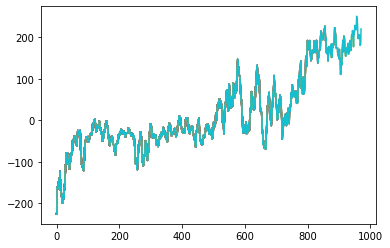

In [14]:
train_agent(agentDQ4, env, episodes = 1000)

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0, Exp rate: 0.98, Score: -117.11294475658732, Average last 100 episodes: nan Time Elapsed: 0h 0m 1s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 1, Exp rate: 0.89, Score: -421.7148144741096, Average last 100 episodes: -117.11294475658732 Time Elapsed: 0h 0m 8s
Episode 2, Exp rate: 0.84, Score: -77.00256916245245, Average last 100 episodes: -269.41387961534843 Time Elapsed: 0h 0m 12s
Episode 3, Exp rate: 0.75, Score: -233.65168513769368, Average last 100 episodes: -205.2767761310498 Time Elapsed: 0h 0m 18s
Episode 4, Exp rate: 0.7, Score: -393.28462256685503, Average last 100 episodes: -212.37050338271075 Time Elapsed: 0h 0m 23s
Episode 5, Exp rate: 0.64, Score: -81.00190696842566, Average last 100 episodes: -248.5533272195396 Time Elapsed: 0h 0m 29s
Episode 6, Exp rate: 0.57, Score: -125.58954978579845, Average last 100 episodes: -220.6280905110206 Time Elapsed: 0h 0m 37s
Episode 7, Exp rate: 0.5, Score: -93.67929527499086, Average las

Episode 63, Exp rate: 0.01, Score: 20.88771124516793, Average last 100 episodes: -119.08541334287467 Time Elapsed: 0h 52m 6s
Episode 64, Exp rate: 0.01, Score: -334.6402149835736, Average last 100 episodes: -116.89833327118649 Time Elapsed: 0h 52m 21s
Episode 65, Exp rate: 0.01, Score: -61.33412470988194, Average last 100 episodes: -120.24820837445398 Time Elapsed: 0h 52m 29s
Episode 66, Exp rate: 0.01, Score: -45.78305794408358, Average last 100 episodes: -119.35557074317259 Time Elapsed: 0h 52m 54s
Episode 67, Exp rate: 0.01, Score: -46.40351368700213, Average last 100 episodes: -118.25747353721603 Time Elapsed: 0h 53m 4s
Episode 68, Exp rate: 0.01, Score: -196.65463359749987, Average last 100 episodes: -117.20079765706583 Time Elapsed: 0h 53m 18s
Episode 69, Exp rate: 0.01, Score: -110.55368043625639, Average last 100 episodes: -118.35230252576777 Time Elapsed: 0h 54m 53s
Episode 70, Exp rate: 0.01, Score: -155.29672289404905, Average last 100 episodes: -118.24089363877475 Time Elap

Episode 127, Exp rate: 0.01, Score: 254.6379243383442, Average last 100 episodes: -8.743294781078095 Time Elapsed: 1h 34m 16s
Episode 128, Exp rate: 0.01, Score: -129.704447196476, Average last 100 episodes: -5.0282586940210425 Time Elapsed: 1h 35m 9s
Episode 129, Exp rate: 0.01, Score: 9.080258983414296, Average last 100 episodes: -5.389761158960905 Time Elapsed: 1h 35m 24s
Episode 130, Exp rate: 0.01, Score: -33.75042163986839, Average last 100 episodes: -3.1373057905363 Time Elapsed: 1h 35m 59s
Episode 131, Exp rate: 0.01, Score: -221.98875464542158, Average last 100 episodes: 0.056002520584517296 Time Elapsed: 1h 36m 19s
Episode 132, Exp rate: 0.01, Score: 90.9799787475419, Average last 100 episodes: -1.4449378978234577 Time Elapsed: 1h 37m 56s
Episode 133, Exp rate: 0.01, Score: 178.59660412093885, Average last 100 episodes: 0.5966277312053566 Time Elapsed: 1h 38m 32s
Episode 134, Exp rate: 0.01, Score: 143.5006047896363, Average last 100 episodes: 1.8037977880295302 Time Elapsed:

Episode 191, Exp rate: 0.01, Score: 276.82528836354516, Average last 100 episodes: 82.3312954528457 Time Elapsed: 2h 29m 8s
Episode 192, Exp rate: 0.01, Score: 238.55709313106993, Average last 100 episodes: 86.27924126804166 Time Elapsed: 2h 30m 26s
Episode 193, Exp rate: 0.01, Score: 263.03843043090706, Average last 100 episodes: 90.05156417949496 Time Elapsed: 2h 30m 57s
Episode 194, Exp rate: 0.01, Score: 289.5497756117986, Average last 100 episodes: 93.25275921267269 Time Elapsed: 2h 31m 31s
Episode 195, Exp rate: 0.01, Score: 241.67568571089447, Average last 100 episodes: 93.96651958999618 Time Elapsed: 2h 31m 57s
Episode 196, Exp rate: 0.01, Score: 260.3061955946623, Average last 100 episodes: 93.96952340371388 Time Elapsed: 2h 32m 25s
Episode 197, Exp rate: 0.01, Score: 126.60747320896517, Average last 100 episodes: 96.87101462942395 Time Elapsed: 2h 33m 23s
Episode 198, Exp rate: 0.01, Score: 92.6734911936329, Average last 100 episodes: 98.79354608435722 Time Elapsed: 2h 34m 58

Episode 255, Exp rate: 0.01, Score: 71.27872682291746, Average last 100 episodes: 170.8855012945426 Time Elapsed: 3h 19m 28s
Episode 256, Exp rate: 0.01, Score: 220.89910999293204, Average last 100 episodes: 170.2940452617241 Time Elapsed: 3h 20m 39s
Episode 257, Exp rate: 0.01, Score: 40.84231933686331, Average last 100 episodes: 171.56180039078225 Time Elapsed: 3h 21m 0s
Episode 258, Exp rate: 0.01, Score: -92.55821072466152, Average last 100 episodes: 171.58307887032618 Time Elapsed: 3h 21m 9s
Episode 259, Exp rate: 0.01, Score: 44.2748264956094, Average last 100 episodes: 172.53792085956823 Time Elapsed: 3h 21m 17s
Episode 260, Exp rate: 0.01, Score: 199.47470504173893, Average last 100 episodes: 173.6761035700255 Time Elapsed: 3h 22m 53s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 261, Exp rate: 0.01, Score: 264.81177292536904, Average last 100 episodes: 177.28458146680964 Time Elapsed: 3h 23m 29s
Episode 262, Exp rate: 0.01, Score: -15.5

Episode 318, Exp rate: 0.01, Score: -105.16119256053202, Average last 100 episodes: 140.58172513939516 Time Elapsed: 3h 56m 46s
Episode 319, Exp rate: 0.01, Score: 283.52680754529365, Average last 100 episodes: 137.17424965709256 Time Elapsed: 3h 57m 7s
Episode 320, Exp rate: 0.01, Score: 248.84285555141625, Average last 100 episodes: 137.76125824596429 Time Elapsed: 3h 57m 32s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 321, Exp rate: 0.01, Score: 25.65880465888891, Average last 100 episodes: 137.92837299823904 Time Elapsed: 3h 57m 56s
Episode 322, Exp rate: 0.01, Score: 231.71480118724264, Average last 100 episodes: 136.03904159734375 Time Elapsed: 3h 58m 35s
Episode 323, Exp rate: 0.01, Score: 241.56033738590955, Average last 100 episodes: 135.87391256207394 Time Elapsed: 3h 59m 15s
Episode 324, Exp rate: 0.01, Score: 269.6893715088272, Average last 100 episodes: 136.2938332482218 Time Elapsed: 3h 59m 51s
Episode 325, Exp rate: 0.01, Score:

Episode 381, Exp rate: 0.01, Score: 251.66044622750348, Average last 100 episodes: 130.2109614152233 Time Elapsed: 4h 35m 53s
Episode 382, Exp rate: 0.01, Score: 244.41829916941342, Average last 100 episodes: 130.0498017532399 Time Elapsed: 4h 36m 29s
Episode 383, Exp rate: 0.01, Score: 216.11050511327744, Average last 100 episodes: 132.10619795675586 Time Elapsed: 4h 37m 42s
Episode 384, Exp rate: 0.01, Score: 280.673654029182, Average last 100 episodes: 135.93161643333752 Time Elapsed: 4h 38m 11s
Episode 385, Exp rate: 0.01, Score: 253.04137585324406, Average last 100 episodes: 136.30089053157542 Time Elapsed: 4h 38m 47s
Episode 386, Exp rate: 0.01, Score: 255.52860808065446, Average last 100 episodes: 141.9693776111266 Time Elapsed: 4h 39m 14s
Episode 387, Exp rate: 0.01, Score: 253.71917371011568, Average last 100 episodes: 141.9597100498726 Time Elapsed: 4h 39m 32s
Episode 388, Exp rate: 0.01, Score: 150.1914098456905, Average last 100 episodes: 142.41142189124028 Time Elapsed: 4h

Episode 445, Exp rate: 0.01, Score: 302.71541172661176, Average last 100 episodes: 172.52586231528977 Time Elapsed: 5h 18m 47s
Episode 446, Exp rate: 0.01, Score: 266.9643652845639, Average last 100 episodes: 173.5526455944252 Time Elapsed: 5h 19m 10s
Episode 447, Exp rate: 0.01, Score: 244.07385915693325, Average last 100 episodes: 173.29317669068337 Time Elapsed: 5h 19m 40s
Episode 448, Exp rate: 0.01, Score: 259.98061895652665, Average last 100 episodes: 176.09438859587937 Time Elapsed: 5h 20m 58s
Episode 449, Exp rate: 0.01, Score: 256.10387637548615, Average last 100 episodes: 178.70966027528314 Time Elapsed: 5h 21m 33s
Episode 450, Exp rate: 0.01, Score: 232.6653145710116, Average last 100 episodes: 178.70042274060103 Time Elapsed: 5h 22m 10s
Episode 451, Exp rate: 0.01, Score: -15.431724516325147, Average last 100 episodes: 183.62341827144405 Time Elapsed: 5h 22m 38s
Episode 452, Exp rate: 0.01, Score: 252.91416201239184, Average last 100 episodes: 185.36659497530118 Time Elapse

Episode 508, Exp rate: 0.01, Score: -125.058929734309, Average last 100 episodes: 169.43155270358923 Time Elapsed: 5h 51m 8s
Episode 509, Exp rate: 0.01, Score: 212.4361879591739, Average last 100 episodes: 165.64500481518394 Time Elapsed: 5h 52m 2s
Episode 510, Exp rate: 0.01, Score: 15.884723665082205, Average last 100 episodes: 166.08275185329347 Time Elapsed: 5h 52m 23s
Episode 511, Exp rate: 0.01, Score: 222.6777147035071, Average last 100 episodes: 163.65039754541232 Time Elapsed: 5h 52m 52s
Episode 512, Exp rate: 0.01, Score: 266.3241888927289, Average last 100 episodes: 163.3919064087083 Time Elapsed: 5h 53m 45s
Episode 513, Exp rate: 0.01, Score: 232.6128983302218, Average last 100 episodes: 168.07929211625486 Time Elapsed: 5h 54m 10s
Episode 514, Exp rate: 0.01, Score: -192.94582591257085, Average last 100 episodes: 168.13720377078968 Time Elapsed: 5h 54m 26s
Episode 515, Exp rate: 0.01, Score: 302.2376232978219, Average last 100 episodes: 164.75347392288438 Time Elapsed: 5h 

Episode 572, Exp rate: 0.01, Score: -688.3556757039922, Average last 100 episodes: 152.10400282785528 Time Elapsed: 6h 28m 43s
Episode 573, Exp rate: 0.01, Score: -880.0777265837108, Average last 100 episodes: 142.84937061071815 Time Elapsed: 6h 28m 57s
Episode 574, Exp rate: 0.01, Score: -732.6997115069054, Average last 100 episodes: 131.99111672559857 Time Elapsed: 6h 29m 10s
Episode 575, Exp rate: 0.01, Score: -396.5718245316713, Average last 100 episodes: 122.09794161132623 Time Elapsed: 6h 29m 18s
Episode 576, Exp rate: 0.01, Score: -710.7369691692716, Average last 100 episodes: 117.96027687737451 Time Elapsed: 6h 29m 32s
Episode 577, Exp rate: 0.01, Score: -801.6659831051601, Average last 100 episodes: 110.9179590455566 Time Elapsed: 6h 29m 44s
Episode 578, Exp rate: 0.01, Score: -512.3106669374827, Average last 100 episodes: 104.16488959413677 Time Elapsed: 6h 29m 52s
Episode 579, Exp rate: 0.01, Score: -602.5149246207055, Average last 100 episodes: 97.53012394071091 Time Elapse

Episode 635, Exp rate: 0.01, Score: -149.19063988924063, Average last 100 episodes: -244.27332450751072 Time Elapsed: 6h 42m 0s
Episode 636, Exp rate: 0.01, Score: -266.347045577681, Average last 100 episodes: -248.17891088495446 Time Elapsed: 6h 42m 21s
Episode 637, Exp rate: 0.01, Score: -584.7382810779109, Average last 100 episodes: -253.2587967970467 Time Elapsed: 6h 42m 32s
Episode 638, Exp rate: 0.01, Score: -351.167363017473, Average last 100 episodes: -262.1620428416645 Time Elapsed: 6h 42m 45s
Episode 639, Exp rate: 0.01, Score: -190.69348125936523, Average last 100 episodes: -267.8122278661087 Time Elapsed: 6h 42m 57s
Episode 640, Exp rate: 0.01, Score: -539.9118336620377, Average last 100 episodes: -272.3105861749289 Time Elapsed: 6h 43m 10s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 641, Exp rate: 0.01, Score: -235.67610731242948, Average last 100 episodes: -280.0396846222583 Time Elapsed: 6h 43m 23s
Episode 642, Exp rate: 0.01, S

Episode 698, Exp rate: 0.01, Score: -276.0220556086472, Average last 100 episodes: -330.3502057573303 Time Elapsed: 7h 4m 12s
Episode 699, Exp rate: 0.01, Score: 32.580081033720674, Average last 100 episodes: -324.81221076073695 Time Elapsed: 7h 5m 49s
Episode 700, Exp rate: 0.01, Score: -82.79144020494805, Average last 100 episodes: -317.7546917096026 Time Elapsed: 7h 7m 26s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 701, Exp rate: 0.01, Score: 3.5634183511970914, Average last 100 episodes: -309.9906144163439 Time Elapsed: 7h 9m 5s
Episode 702, Exp rate: 0.01, Score: 206.07387607401066, Average last 100 episodes: -304.51439110412707 Time Elapsed: 7h 10m 11s
Episode 703, Exp rate: 0.01, Score: -174.88972651279406, Average last 100 episodes: -294.78136252381375 Time Elapsed: 7h 10m 42s
Episode 704, Exp rate: 0.01, Score: -117.29084702919477, Average last 100 episodes: -291.9155694419486 Time Elapsed: 7h 11m 13s
Episode 705, Exp rate: 0.01, Sco

INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 761, Exp rate: 0.01, Score: 227.10708538766238, Average last 100 episodes: -84.06865503375523 Time Elapsed: 7h 54m 32s
Episode 762, Exp rate: 0.01, Score: -83.64409362979166, Average last 100 episodes: -78.04077414586266 Time Elapsed: 7h 54m 45s
Episode 763, Exp rate: 0.01, Score: -15.096381050117472, Average last 100 episodes: -76.15368615693178 Time Elapsed: 7h 55m 9s
Episode 764, Exp rate: 0.01, Score: 8.597685336393042, Average last 100 episodes: -74.36314090121373 Time Elapsed: 7h 56m 47s
Episode 765, Exp rate: 0.01, Score: 252.95375908699324, Average last 100 episodes: -70.72800214232528 Time Elapsed: 7h 57m 22s
Episode 766, Exp rate: 0.01, Score: 249.36463321771873, Average last 100 episodes: -66.22821130710979 Time Elapsed: 7h 58m 19s
Episode 767, Exp rate: 0.01, Score: 157.78384371465324, Average last 100 episodes: -61.67889847872005 Time Elapsed: 7h 59m 47s
Episode 768, Exp rate: 0.01, Scor

Episode 824, Exp rate: 0.01, Score: 207.9502104475284, Average last 100 episodes: 107.1634051355189 Time Elapsed: 8h 40m 5s
Episode 825, Exp rate: 0.01, Score: 54.09201040949281, Average last 100 episodes: 110.03446765831217 Time Elapsed: 8h 41m 47s
Episode 826, Exp rate: 0.01, Score: 224.8648394738721, Average last 100 episodes: 111.24246221261633 Time Elapsed: 8h 42m 40s
Episode 827, Exp rate: 0.01, Score: -27.49899360467792, Average last 100 episodes: 116.17275805646628 Time Elapsed: 8h 43m 7s
Episode 828, Exp rate: 0.01, Score: 226.4514229927277, Average last 100 episodes: 113.75142366031285 Time Elapsed: 8h 43m 53s
Episode 829, Exp rate: 0.01, Score: -339.16554941145483, Average last 100 episodes: 116.74890007226149 Time Elapsed: 8h 44m 28s
Episode 830, Exp rate: 0.01, Score: 225.82122042539726, Average last 100 episodes: 114.51279800867502 Time Elapsed: 8h 44m 58s
Episode 831, Exp rate: 0.01, Score: 255.3573537013736, Average last 100 episodes: 117.77340506042115 Time Elapsed: 8h

Episode 888, Exp rate: 0.01, Score: -435.7941118371707, Average last 100 episodes: 80.10100063303483 Time Elapsed: 9h 30m 13s
Episode 889, Exp rate: 0.01, Score: -422.1316710169061, Average last 100 episodes: 73.36734174083966 Time Elapsed: 9h 30m 39s
Episode 890, Exp rate: 0.01, Score: -321.323433664381, Average last 100 episodes: 66.93823105981708 Time Elapsed: 9h 31m 30s
Episode 891, Exp rate: 0.01, Score: -200.80047176638362, Average last 100 episodes: 61.3398757815006 Time Elapsed: 9h 32m 39s
Episode 892, Exp rate: 0.01, Score: 270.62952285735025, Average last 100 episodes: 56.85929938390962 Time Elapsed: 9h 33m 13s
Episode 893, Exp rate: 0.01, Score: 202.4629035697302, Average last 100 episodes: 56.67579354792218 Time Elapsed: 9h 33m 46s
Episode 894, Exp rate: 0.01, Score: 218.3964000477617, Average last 100 episodes: 60.30044036658911 Time Elapsed: 9h 34m 48s
Episode 895, Exp rate: 0.01, Score: -50.699460550049885, Average last 100 episodes: 59.844300824541605 Time Elapsed: 9h 3

KeyboardInterrupt: 

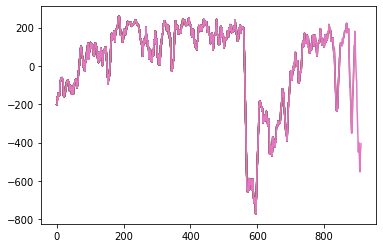

In [15]:
train_agent(agentDQ5, env, episodes = 1000)

## Results

We can clearly see that the experience replay agents did better than the agents without experience replay, as expected. The agent with lr=0.001 was oscilating after having solved the environment in only 200 episodes, but this instability is also not indicative of a good agent.

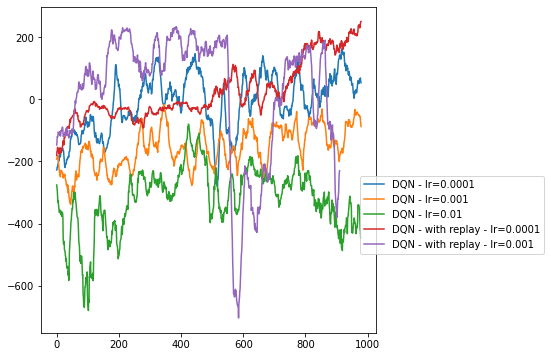

In [49]:
scores = [agentDQ1.training_scores, agentDQ2.training_scores, agentDQ3.training_scores, agentDQ4.training_scores, agentDQ5.training_scores]
names = ["DQN - lr=0.0001", "DQN - lr=0.001", "DQN - lr=0.01", "DQN - with replay - lr=0.0001", "DQN - with replay - lr=0.001"]
plot_scores(scores, names)

## Discount factor effect

Next we will take a look at the effect of the discount factor (gamma). In all previous runs we have set gamma=0.99, we will now check if decreasing or increasing the discount factor will have a better effect. We will compare these agents to the DQN agent with replay which had a learning rate of 0.001, because so far this agent has been the fastest to win the game.

In [27]:
agentDQ6 = DQAgent(state_size, action_size, "storage/DQ_v2_gamma_0.95", gamma=0.95, learning_rate=0.001, memory_size=640000)
agentDQ7 = DQAgent(state_size, action_size, "storage/DQ_v2_gamma_0.995", gamma=0.995, learning_rate=0.001, memory_size=640000)

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0, Exp rate: 0.97, Score: -107.88, Average last 100 episodes: nan Time Elapsed: 0h 0m 2s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 1, Exp rate: 0.88, Score: -246.72, Average last 100 episodes: -107.88 Time Elapsed: 0h 0m 8s
Episode 2, Exp rate: 0.79, Score: -500.13, Average last 100 episodes: -177.3 Time Elapsed: 0h 0m 15s
Episode 3, Exp rate: 0.73, Score: 1.68, Average last 100 episodes: -284.91 Time Elapsed: 0h 0m 19s
Episode 4, Exp rate: 0.65, Score: -101.39, Average last 100 episodes: -213.26250000000002 Time Elapsed: 0h 0m 26s
Episode 5, Exp rate: 0.57, Score: -112.16, Average last 100 episodes: -190.888 Time Elapsed: 0h 0m 35s
Episode 6, Exp rate: 0.5, Score: -151.35, Average last 100 episodes: -177.76666666666668 Time Elapsed: 0h 0m 44s
Episode 7, Exp rate: 0.46, Score: -133.04, Average last 100 episodes: -173.99285714285716 Time Elapsed: 0h 0m 51s
Episode 8, Exp rate: 0.43, Score: -92.01, Average last 100 episodes: -168.87375

Episode 71, Exp rate: 0.01, Score: -165.89, Average last 100 episodes: -145.346338028169 Time Elapsed: 0h 28m 4s
Episode 72, Exp rate: 0.01, Score: -193.64, Average last 100 episodes: -145.63166666666666 Time Elapsed: 0h 29m 21s
Episode 73, Exp rate: 0.01, Score: -118.65, Average last 100 episodes: -146.28931506849312 Time Elapsed: 0h 30m 35s
Episode 74, Exp rate: 0.01, Score: -33.11, Average last 100 episodes: -145.9158108108108 Time Elapsed: 0h 30m 41s
Episode 75, Exp rate: 0.01, Score: -83.43, Average last 100 episodes: -144.41173333333333 Time Elapsed: 0h 32m 19s
Episode 76, Exp rate: 0.01, Score: -312.57, Average last 100 episodes: -143.60934210526315 Time Elapsed: 0h 32m 45s
Episode 77, Exp rate: 0.01, Score: -97.02, Average last 100 episodes: -145.80363636363634 Time Elapsed: 0h 34m 26s
Episode 78, Exp rate: 0.01, Score: -439.52, Average last 100 episodes: -145.17820512820512 Time Elapsed: 0h 35m 10s
Episode 79, Exp rate: 0.01, Score: -129.04, Average last 100 episodes: -148.904

Episode 142, Exp rate: 0.01, Score: -76.9, Average last 100 episodes: -114.45819999999999 Time Elapsed: 1h 37m 6s
Episode 143, Exp rate: 0.01, Score: -124.63, Average last 100 episodes: -114.98559999999998 Time Elapsed: 1h 38m 42s
Episode 144, Exp rate: 0.01, Score: -37.69, Average last 100 episodes: -115.57659999999998 Time Elapsed: 1h 38m 57s
Episode 145, Exp rate: 0.01, Score: -18.76, Average last 100 episodes: -115.39089999999999 Time Elapsed: 1h 39m 12s
Episode 146, Exp rate: 0.01, Score: -112.72, Average last 100 episodes: -115.60700000000001 Time Elapsed: 1h 40m 47s
Episode 147, Exp rate: 0.01, Score: 13.48, Average last 100 episodes: -116.2059 Time Elapsed: 1h 42m 22s
Episode 148, Exp rate: 0.01, Score: 44.81, Average last 100 episodes: -113.85560000000001 Time Elapsed: 1h 42m 38s
Episode 149, Exp rate: 0.01, Score: -184.12, Average last 100 episodes: -111.48190000000001 Time Elapsed: 1h 42m 45s
Episode 150, Exp rate: 0.01, Score: 12.65, Average last 100 episodes: -112.59160000

Episode 213, Exp rate: 0.01, Score: -52.02, Average last 100 episodes: -83.17130000000002 Time Elapsed: 3h 1m 48s
Episode 214, Exp rate: 0.01, Score: -22.95, Average last 100 episodes: -83.03370000000001 Time Elapsed: 3h 3m 23s
Episode 215, Exp rate: 0.01, Score: -10.81, Average last 100 episodes: -82.55810000000001 Time Elapsed: 3h 3m 35s
Episode 216, Exp rate: 0.01, Score: -89.28, Average last 100 episodes: -81.2865 Time Elapsed: 3h 5m 10s
Episode 217, Exp rate: 0.01, Score: -162.56, Average last 100 episodes: -82.08950000000003 Time Elapsed: 3h 5m 24s
Episode 218, Exp rate: 0.01, Score: -348.66, Average last 100 episodes: -83.2925 Time Elapsed: 3h 6m 6s
Episode 219, Exp rate: 0.01, Score: -78.46, Average last 100 episodes: -86.5395 Time Elapsed: 3h 7m 41s
Episode 220, Exp rate: 0.01, Score: -92.33, Average last 100 episodes: -85.9834 Time Elapsed: 3h 9m 21s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 221, Exp rate: 0.01, Score: -92.06, Aver

Episode 285, Exp rate: 0.01, Score: -39.08, Average last 100 episodes: -76.94200000000001 Time Elapsed: 4h 26m 24s
Episode 286, Exp rate: 0.01, Score: -119.52, Average last 100 episodes: -77.01689999999999 Time Elapsed: 4h 27m 59s
Episode 287, Exp rate: 0.01, Score: -320.47, Average last 100 episodes: -77.34520000000002 Time Elapsed: 4h 28m 7s
Episode 288, Exp rate: 0.01, Score: -109.07, Average last 100 episodes: -79.3237 Time Elapsed: 4h 29m 41s
Episode 289, Exp rate: 0.01, Score: -80.12, Average last 100 episodes: -80.14080000000001 Time Elapsed: 4h 31m 16s
Episode 290, Exp rate: 0.01, Score: -47.69, Average last 100 episodes: -80.0727 Time Elapsed: 4h 32m 51s
Episode 291, Exp rate: 0.01, Score: -9.32, Average last 100 episodes: -80.4583 Time Elapsed: 4h 33m 2s
Episode 292, Exp rate: 0.01, Score: -77.83, Average last 100 episodes: -78.9271 Time Elapsed: 4h 34m 37s
Episode 293, Exp rate: 0.01, Score: -52.03, Average last 100 episodes: -78.61789999999999 Time Elapsed: 4h 36m 11s
Episo

Episode 357, Exp rate: 0.01, Score: 64.1, Average last 100 episodes: -108.3651 Time Elapsed: 5h 55m 44s
Episode 358, Exp rate: 0.01, Score: -100.93, Average last 100 episodes: -107.04159999999997 Time Elapsed: 5h 57m 21s
Episode 359, Exp rate: 0.01, Score: -93.41, Average last 100 episodes: -107.5525 Time Elapsed: 5h 58m 59s
Episode 360, Exp rate: 0.01, Score: -76.55, Average last 100 episodes: -107.8891 Time Elapsed: 6h 0m 33s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 361, Exp rate: 0.01, Score: -126.99, Average last 100 episodes: -107.6033 Time Elapsed: 6h 0m 41s
Episode 362, Exp rate: 0.01, Score: -89.94, Average last 100 episodes: -107.8941 Time Elapsed: 6h 2m 15s
Episode 363, Exp rate: 0.01, Score: -143.99, Average last 100 episodes: -107.837 Time Elapsed: 6h 3m 52s
Episode 364, Exp rate: 0.01, Score: -70.13, Average last 100 episodes: -107.98479999999999 Time Elapsed: 6h 5m 27s
Episode 365, Exp rate: 0.01, Score: -32.34, Average last 1

Episode 429, Exp rate: 0.01, Score: 164.16, Average last 100 episodes: -81.7523 Time Elapsed: 7h 20m 30s
Episode 430, Exp rate: 0.01, Score: -68.31, Average last 100 episodes: -78.8756 Time Elapsed: 7h 20m 37s
Episode 431, Exp rate: 0.01, Score: 49.79, Average last 100 episodes: -78.46260000000002 Time Elapsed: 7h 20m 45s
Episode 432, Exp rate: 0.01, Score: -183.0, Average last 100 episodes: -76.6868 Time Elapsed: 7h 21m 14s
Episode 433, Exp rate: 0.01, Score: -85.49, Average last 100 episodes: -77.64150000000001 Time Elapsed: 7h 22m 52s
Episode 434, Exp rate: 0.01, Score: -83.34, Average last 100 episodes: -77.2919 Time Elapsed: 7h 24m 32s
Episode 435, Exp rate: 0.01, Score: -105.83, Average last 100 episodes: -77.4526 Time Elapsed: 7h 26m 11s
Episode 436, Exp rate: 0.01, Score: -109.6, Average last 100 episodes: -77.8033 Time Elapsed: 7h 27m 49s
Episode 437, Exp rate: 0.01, Score: -82.84, Average last 100 episodes: -77.8371 Time Elapsed: 7h 29m 26s
Episode 438, Exp rate: 0.01, Score:

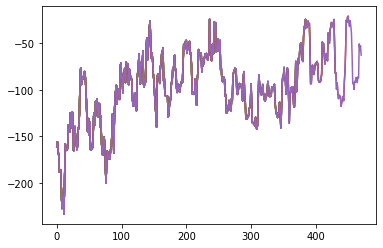

In [54]:
train_agent(agentDQ6, env, episodes = 500)

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0, Exp rate: 0.98, Score: -213.8, Average last 100 episodes: nan Time Elapsed: 0h 0m 2s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 1, Exp rate: 0.91, Score: -98.45, Average last 100 episodes: -213.8 Time Elapsed: 0h 0m 8s
Episode 2, Exp rate: 0.78, Score: -69.72, Average last 100 episodes: -156.125 Time Elapsed: 0h 0m 17s
Episode 3, Exp rate: 0.7, Score: -288.69, Average last 100 episodes: -127.32333333333334 Time Elapsed: 0h 0m 23s
Episode 4, Exp rate: 0.62, Score: -360.23, Average last 100 episodes: -167.66500000000002 Time Elapsed: 0h 0m 32s
Episode 5, Exp rate: 0.56, Score: -228.93, Average last 100 episodes: -206.17800000000003 Time Elapsed: 0h 0m 39s
Episode 6, Exp rate: 0.51, Score: -87.95, Average last 100 episodes: -209.97000000000003 Time Elapsed: 0h 0m 46s
Episode 7, Exp rate: 0.46, Score: -51.33, Average last 100 episodes: -192.53857142857146 Time Elapsed: 0h 0m 52s
Episode 8, Exp rate: 0.43, Score: -45.05, Average last 10

Episode 71, Exp rate: 0.01, Score: -284.58, Average last 100 episodes: -378.02366197183096 Time Elapsed: 0h 16m 1s
Episode 72, Exp rate: 0.01, Score: -309.39, Average last 100 episodes: -376.72583333333336 Time Elapsed: 0h 16m 17s
Episode 73, Exp rate: 0.01, Score: -1013.93, Average last 100 episodes: -375.80342465753426 Time Elapsed: 0h 17m 6s
Episode 74, Exp rate: 0.01, Score: -104.77, Average last 100 episodes: -384.4267567567568 Time Elapsed: 0h 17m 18s
Episode 75, Exp rate: 0.01, Score: -300.52, Average last 100 episodes: -380.69800000000004 Time Elapsed: 0h 17m 36s
Episode 76, Exp rate: 0.01, Score: -847.88, Average last 100 episodes: -379.6430263157895 Time Elapsed: 0h 17m 53s
Episode 77, Exp rate: 0.01, Score: -660.19, Average last 100 episodes: -385.724025974026 Time Elapsed: 0h 18m 25s
Episode 78, Exp rate: 0.01, Score: -515.78, Average last 100 episodes: -389.2428205128205 Time Elapsed: 0h 18m 53s
Episode 79, Exp rate: 0.01, Score: -261.34, Average last 100 episodes: -390.84

Episode 141, Exp rate: 0.01, Score: -229.73, Average last 100 episodes: -342.1565 Time Elapsed: 1h 25m 7s
Episode 142, Exp rate: 0.01, Score: -263.81, Average last 100 episodes: -341.1469 Time Elapsed: 1h 26m 42s
Episode 143, Exp rate: 0.01, Score: -185.36, Average last 100 episodes: -339.11259999999993 Time Elapsed: 1h 27m 18s
Episode 144, Exp rate: 0.01, Score: -602.57, Average last 100 episodes: -339.29690000000005 Time Elapsed: 1h 27m 40s
Episode 145, Exp rate: 0.01, Score: -51.87, Average last 100 episodes: -342.0534 Time Elapsed: 1h 27m 52s
Episode 146, Exp rate: 0.01, Score: -37.61, Average last 100 episodes: -338.5955 Time Elapsed: 1h 28m 7s
Episode 147, Exp rate: 0.01, Score: -256.82, Average last 100 episodes: -331.7104000000001 Time Elapsed: 1h 28m 33s
Episode 148, Exp rate: 0.01, Score: -281.49, Average last 100 episodes: -330.57539999999995 Time Elapsed: 1h 29m 3s
Episode 149, Exp rate: 0.01, Score: -249.12, Average last 100 episodes: -324.08590000000004 Time Elapsed: 1h 2

Episode 213, Exp rate: 0.01, Score: -207.98, Average last 100 episodes: -322.46880000000004 Time Elapsed: 2h 26m 21s
Episode 214, Exp rate: 0.01, Score: -199.75, Average last 100 episodes: -320.0108000000001 Time Elapsed: 2h 27m 54s
Episode 215, Exp rate: 0.01, Score: -140.6, Average last 100 episodes: -320.3242000000001 Time Elapsed: 2h 29m 28s
Episode 216, Exp rate: 0.01, Score: -150.65, Average last 100 episodes: -320.2709 Time Elapsed: 2h 30m 8s
Episode 217, Exp rate: 0.01, Score: -224.2, Average last 100 episodes: -320.6678 Time Elapsed: 2h 30m 40s
Episode 218, Exp rate: 0.01, Score: -234.82, Average last 100 episodes: -318.41630000000004 Time Elapsed: 2h 32m 5s
Episode 219, Exp rate: 0.01, Score: -202.47, Average last 100 episodes: -318.4567 Time Elapsed: 2h 33m 40s
Episode 220, Exp rate: 0.01, Score: -307.28, Average last 100 episodes: -319.53510000000006 Time Elapsed: 2h 34m 7s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 221, Exp rate:

Episode 283, Exp rate: 0.01, Score: -582.25, Average last 100 episodes: -350.96090000000004 Time Elapsed: 3h 31m 34s
Episode 284, Exp rate: 0.01, Score: -1428.97, Average last 100 episodes: -353.6462 Time Elapsed: 3h 32m 11s
Episode 285, Exp rate: 0.01, Score: -2488.49, Average last 100 episodes: -366.32300000000004 Time Elapsed: 3h 32m 44s
Episode 286, Exp rate: 0.01, Score: -591.99, Average last 100 episodes: -387.92900000000003 Time Elapsed: 3h 34m 18s
Episode 287, Exp rate: 0.01, Score: -582.98, Average last 100 episodes: -392.6285 Time Elapsed: 3h 35m 6s
Episode 288, Exp rate: 0.01, Score: -711.96, Average last 100 episodes: -396.6063 Time Elapsed: 3h 35m 42s
Episode 289, Exp rate: 0.01, Score: -711.23, Average last 100 episodes: -398.10699999999997 Time Elapsed: 3h 36m 4s
Episode 290, Exp rate: 0.01, Score: -618.58, Average last 100 episodes: -403.2858 Time Elapsed: 3h 36m 55s
Episode 291, Exp rate: 0.01, Score: -568.29, Average last 100 episodes: -407.3676000000001 Time Elapsed:

Episode 355, Exp rate: 0.01, Score: -168.63, Average last 100 episodes: -385.6574 Time Elapsed: 4h 41m 33s
Episode 356, Exp rate: 0.01, Score: -185.25, Average last 100 episodes: -386.46979999999996 Time Elapsed: 4h 41m 52s
Episode 357, Exp rate: 0.01, Score: -301.89, Average last 100 episodes: -386.26240000000007 Time Elapsed: 4h 42m 7s
Episode 358, Exp rate: 0.01, Score: -132.96, Average last 100 episodes: -388.7457 Time Elapsed: 4h 43m 41s
Episode 359, Exp rate: 0.01, Score: -200.89, Average last 100 episodes: -389.207 Time Elapsed: 4h 45m 16s
Episode 360, Exp rate: 0.01, Score: -227.43, Average last 100 episodes: -389.57609999999994 Time Elapsed: 4h 46m 50s
INFO:tensorflow:Assets written to: storage\DQ_v2_lr_0.001\model_weights\assets
Episode 361, Exp rate: 0.01, Score: -121.52, Average last 100 episodes: -390.87489999999997 Time Elapsed: 4h 48m 25s
Episode 362, Exp rate: 0.01, Score: -58.97, Average last 100 episodes: -388.70219999999995 Time Elapsed: 4h 50m 0s
Episode 363, Exp ra

Episode 426, Exp rate: 0.01, Score: -392.73, Average last 100 episodes: -228.5461 Time Elapsed: 6h 9m 56s
Episode 427, Exp rate: 0.01, Score: -474.7, Average last 100 episodes: -231.2004 Time Elapsed: 6h 10m 30s
Episode 428, Exp rate: 0.01, Score: -743.88, Average last 100 episodes: -233.65239999999997 Time Elapsed: 6h 11m 0s
Episode 429, Exp rate: 0.01, Score: -366.43, Average last 100 episodes: -239.5515 Time Elapsed: 6h 11m 39s
Episode 430, Exp rate: 0.01, Score: -329.83, Average last 100 episodes: -241.57890000000003 Time Elapsed: 6h 13m 14s
Episode 431, Exp rate: 0.01, Score: -203.64, Average last 100 episodes: -244.13710000000003 Time Elapsed: 6h 14m 49s
Episode 432, Exp rate: 0.01, Score: -135.91, Average last 100 episodes: -245.16280000000003 Time Elapsed: 6h 16m 24s
Episode 433, Exp rate: 0.01, Score: -91.22, Average last 100 episodes: -246.00639999999999 Time Elapsed: 6h 17m 59s
Episode 434, Exp rate: 0.01, Score: -185.31, Average last 100 episodes: -245.84920000000002 Time E

Episode 497, Exp rate: 0.01, Score: -150.92, Average last 100 episodes: -250.64609999999996 Time Elapsed: 7h 38m 30s
Episode 498, Exp rate: 0.01, Score: -61.91, Average last 100 episodes: -251.6272 Time Elapsed: 7h 38m 49s
Episode 499, Exp rate: 0.01, Score: -104.02, Average last 100 episodes: -250.8569 Time Elapsed: 7h 40m 24s


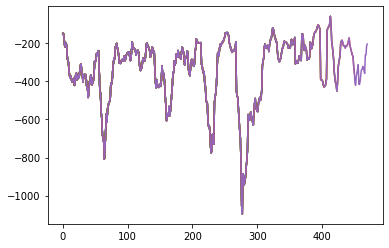

In [55]:
train_agent(agentDQ7, env, episodes = 500)

## Results

The results of the discount factor test show that a value of 0.99 is ideal for the discount factor. After 500 simulations the agents with discount factor of 0.95 and 0.995 were not performing very well while the agent with discount factor 0.99 was almost able to solve the environment.

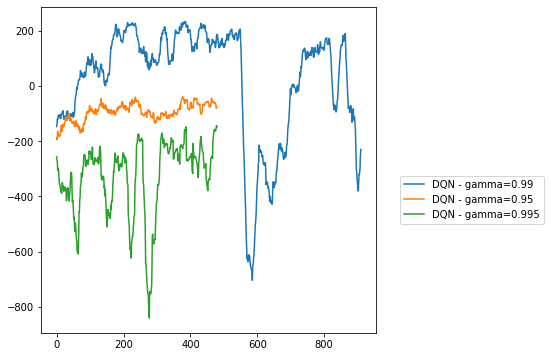

In [56]:
scores = [agentDQ5.training_scores, agentDQ6.training_scores, agentDQ7.training_scores]
names = ["DQN - gamma=0.99","DQN - gamma=0.95", "DQN - gamma=0.995"]
plot_scores(scores, names)

# DDQN - Actor Critic network

To attempt and improve the agent, we now attemt to solve the environment with an actor-critic architecture. We will use a different agent and compare the results to the existing agents.

In [62]:
class A2CAgent:
    def __init__(self, state_size, action_size, backup_dir, memory_size=640000, actor_lr=0.001, critic_lr=0.005, exploration_decay=1):
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        
        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        self.batch_size = 64
        
        self.exploration_decay = exploration_decay
        self.exploration_min = 0.01
        
        self.episodes_run = 0
        self.training_scores = []
        self.validation_scores = []
        self.exploration_rate = 1
        
        self.backup_dir         = backup_dir
        
        self.training_scores_graph_file = "Lunar_A2C_training_scores.png"
        self.memory = deque(maxlen=memory_size)

        
    def save_agent(self):
        self.actor.save(Path(self.backup_dir, "actor_model_weights"))
        self.critic.save(Path(self.backup_dir, "critic_model_weights"))
        pickle.dump(self.training_scores, open(Path(self.backup_dir, "training_scores"), "wb"))
        pickle.dump(self.validation_scores, open(Path(self.backup_dir, "validation_scores"), "wb"))
        pickle.dump([self.episodes_run], open(Path(self.backup_dir, "episodes_run"), "wb"))
        smooth = 20
        fig, ax = plt.subplots()
        ax.plot([np.mean(self.training_scores[i:i+smooth]) for i in range(len(self.training_scores) - smooth)])
        fig.savefig(Path(self.backup_dir, self.training_scores_graph_file), facecolor='white')
        plt.close(fig)

    def load_agent(self):
        self.actor = load_model(Path(self.backup_dir, "actor_model_weights"))
        self.critic = load_model(Path(self.backup_dir, "critic_model_weights"))
        self.training_scores = pickle.load(open(Path(self.backup_dir, "training_scores"), "rb"))
        self.validation_scores = pickle.load(open(Path(self.backup_dir, "validation_scores"), "rb"))
        self.episodes_run = pickle.load(open(Path(self.backup_dir, "episodes_run"), "rb"))[0]
        
    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(200, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(140, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        actor.summary()
        actor.compile(loss='mse',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(200, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(140, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
#         critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    
    # using the output of policy network, pick action stochastically
    def act(self, state, exploit=False):
        if exploit is False and self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
        policy = self.actor.predict(state, batch_size=1).flatten()
        if exploit is False and np.random.rand() <= self.exploration_rate:
            return np.random.choice(self.action_size, 1, p=policy)[0]
        else:
            return np.argmax(policy)

    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
            
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        size = self.batch_size
        sample_batch = random.sample(self.memory, size)
        
        states = np.concatenate([i[0] for i in sample_batch])
        actions = np.array([i[1] for i in sample_batch])
        rewards = np.array([i[2] for i in sample_batch])
        next_states = np.concatenate([i[3] for i in sample_batch])
        dones = np.array([i[4] for i in sample_batch])

        values = self.critic.predict(states)
        next_values = self.critic.predict(next_states)

        next_values[np.where(np.array(dones).astype(int) == 1)] = 0

        rewards = np.array(rewards).reshape(size, 1)
        calcs = rewards - values + self.discount_factor * next_values

        advantages = np.zeros((size, self.action_size))
        for i in range(size):
            advantages[i, actions[i]] = calcs[i]

        targets = rewards + self.discount_factor * next_values

        self.actor.fit(states, advantages, epochs=1, verbose=0)
        self.critic.fit(states, targets, epochs=1, verbose=0)
        

In [34]:
agentA2C_1 = A2CAgent(state_size, action_size, "storage/A2C_v1", actor_lr=0.001, critic_lr=0.001, memory_size=640000, exploration_decay=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 200)               1800      
_________________________________________________________________
dense_28 (Dense)             (None, 140)               28140     
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 1128      
Total params: 31,068
Trainable params: 31,068
Non-trainable params: 0
_________________________________________________________________


C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [36]:
train_agent(agentA2C_1, env, episodes = 500)

Episode 0, Exp rate: NA, Score: 125.08, Average last 100 episodes: 48.41 Time Elapsed: 0h 3m 16s
INFO:tensorflow:Assets written to: storage\A2C_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_v1\critic_model_weights\assets
Episode 1, Exp rate: NA, Score: 100.46, Average last 100 episodes: 48.99 Time Elapsed: 0h 6m 32s
Episode 2, Exp rate: NA, Score: -42.69, Average last 100 episodes: 50.15 Time Elapsed: 0h 7m 6s
Episode 3, Exp rate: NA, Score: -133.41, Average last 100 episodes: 49.11 Time Elapsed: 0h 8m 1s
Episode 4, Exp rate: NA, Score: 98.68, Average last 100 episodes: 48.31 Time Elapsed: 0h 11m 17s
Episode 5, Exp rate: NA, Score: 88.44, Average last 100 episodes: 48.06 Time Elapsed: 0h 14m 26s
Episode 6, Exp rate: NA, Score: 75.8, Average last 100 episodes: 48.24 Time Elapsed: 0h 17m 34s
Episode 7, Exp rate: NA, Score: 94.88, Average last 100 episodes: 49.35 Time Elapsed: 0h 20m 42s
Episode 8, Exp rate: NA, Score: 80.96, Average last 100 episodes: 49.5 

Episode 78, Exp rate: NA, Score: 88.08, Average last 100 episodes: 60.56 Time Elapsed: 3h 29m 33s
Episode 79, Exp rate: NA, Score: 81.84, Average last 100 episodes: 61.34 Time Elapsed: 3h 32m 38s
Episode 80, Exp rate: NA, Score: 69.14, Average last 100 episodes: 61.53 Time Elapsed: 3h 35m 42s
INFO:tensorflow:Assets written to: storage\A2C_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_v1\critic_model_weights\assets
Episode 81, Exp rate: NA, Score: 82.07, Average last 100 episodes: 61.11 Time Elapsed: 3h 38m 49s
Episode 82, Exp rate: NA, Score: 117.95, Average last 100 episodes: 61.56 Time Elapsed: 3h 41m 53s
Episode 83, Exp rate: NA, Score: 70.49, Average last 100 episodes: 61.39 Time Elapsed: 3h 44m 58s
Episode 84, Exp rate: NA, Score: 79.55, Average last 100 episodes: 61.14 Time Elapsed: 3h 48m 5s
Episode 85, Exp rate: NA, Score: -77.58, Average last 100 episodes: 61.21 Time Elapsed: 3h 48m 31s
Episode 86, Exp rate: NA, Score: 98.65, Average last 100 epi

Episode 155, Exp rate: NA, Score: 162.46, Average last 100 episodes: 64.98 Time Elapsed: 7h 9m 43s
Episode 156, Exp rate: NA, Score: 158.46, Average last 100 episodes: 66.92 Time Elapsed: 7h 12m 49s
Episode 157, Exp rate: NA, Score: 61.75, Average last 100 episodes: 67.72 Time Elapsed: 7h 15m 54s
Episode 158, Exp rate: NA, Score: 41.77, Average last 100 episodes: 67.38 Time Elapsed: 7h 18m 59s
Episode 159, Exp rate: NA, Score: -17.13, Average last 100 episodes: 66.64 Time Elapsed: 7h 22m 3s
Episode 160, Exp rate: NA, Score: 127.73, Average last 100 episodes: 65.57 Time Elapsed: 7h 25m 9s
INFO:tensorflow:Assets written to: storage\A2C_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_v1\critic_model_weights\assets
Episode 161, Exp rate: NA, Score: 160.57, Average last 100 episodes: 67.55 Time Elapsed: 7h 28m 16s
Episode 162, Exp rate: NA, Score: 88.65, Average last 100 episodes: 68.14 Time Elapsed: 7h 31m 21s
Episode 163, Exp rate: NA, Score: 106.54, Average l

Episode 232, Exp rate: NA, Score: 93.39, Average last 100 episodes: 78.3 Time Elapsed: 10h 28m 19s
Episode 233, Exp rate: NA, Score: 97.77, Average last 100 episodes: 78.56 Time Elapsed: 10h 31m 26s
Episode 234, Exp rate: NA, Score: 95.88, Average last 100 episodes: 78.62 Time Elapsed: 10h 34m 33s
Episode 235, Exp rate: NA, Score: 99.95, Average last 100 episodes: 78.29 Time Elapsed: 10h 37m 40s
Episode 236, Exp rate: NA, Score: 92.02, Average last 100 episodes: 78.75 Time Elapsed: 10h 40m 47s
Episode 237, Exp rate: NA, Score: 93.06, Average last 100 episodes: 78.64 Time Elapsed: 10h 43m 54s
Episode 238, Exp rate: NA, Score: 122.29, Average last 100 episodes: 78.38 Time Elapsed: 10h 47m 1s
Episode 239, Exp rate: NA, Score: 8.55, Average last 100 episodes: 78.64 Time Elapsed: 10h 50m 8s
Episode 240, Exp rate: NA, Score: 30.08, Average last 100 episodes: 77.79 Time Elapsed: 10h 53m 15s
INFO:tensorflow:Assets written to: storage\A2C_v1\actor_model_weights\assets
INFO:tensorflow:Assets wri

Episode 308, Exp rate: NA, Score: 86.52, Average last 100 episodes: 80.32 Time Elapsed: 14h 4m 3s
Episode 309, Exp rate: NA, Score: 91.63, Average last 100 episodes: 80.21 Time Elapsed: 14h 7m 10s
Episode 310, Exp rate: NA, Score: -65.34, Average last 100 episodes: 80.3 Time Elapsed: 14h 7m 34s
Episode 311, Exp rate: NA, Score: 20.11, Average last 100 episodes: 78.34 Time Elapsed: 14h 7m 56s
Episode 312, Exp rate: NA, Score: 78.53, Average last 100 episodes: 77.6 Time Elapsed: 14h 11m 5s
Episode 313, Exp rate: NA, Score: 76.2, Average last 100 episodes: 78.3 Time Elapsed: 14h 14m 12s
Episode 314, Exp rate: NA, Score: -142.75, Average last 100 episodes: 78.04 Time Elapsed: 14h 15m 9s
Episode 315, Exp rate: NA, Score: 1.96, Average last 100 episodes: 75.51 Time Elapsed: 14h 15m 26s
Episode 316, Exp rate: NA, Score: 81.26, Average last 100 episodes: 74.43 Time Elapsed: 14h 18m 34s
Episode 317, Exp rate: NA, Score: 74.11, Average last 100 episodes: 74.33 Time Elapsed: 14h 21m 41s
Episode 3

KeyboardInterrupt: 

In [48]:
agentA2C_2 = A2CAgent(state_size, action_size, "storage/A2C_v2", actor_lr=0.001, critic_lr=0.001, memory_size=640000, exploration_decay=0.9999)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 200)               1800      
_________________________________________________________________
dense_52 (Dense)             (None, 140)               28140     
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 1128      
Total params: 31,068
Trainable params: 31,068
Non-trainable params: 0
_________________________________________________________________


C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [52]:
train_agent(agentA2C_2, env, episodes = 500)

Episode 0, Exp rate: 0.06, Score: 194.92, Average last 100 episodes: 32.2 Time Elapsed: 0h 1m 59s
INFO:tensorflow:Assets written to: storage\A2C_v2\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_v2\critic_model_weights\assets
Episode 1, Exp rate: 0.05, Score: 195.2, Average last 100 episodes: 34.23 Time Elapsed: 0h 3m 34s
Episode 2, Exp rate: 0.05, Score: 44.83, Average last 100 episodes: 34.36 Time Elapsed: 0h 4m 15s
Episode 3, Exp rate: 0.05, Score: 200.26, Average last 100 episodes: 36.39 Time Elapsed: 0h 5m 33s
Episode 4, Exp rate: 0.05, Score: 0.87, Average last 100 episodes: 35.96 Time Elapsed: 0h 6m 9s
Episode 5, Exp rate: 0.05, Score: -53.95, Average last 100 episodes: 34.89 Time Elapsed: 0h 7m 20s
Episode 6, Exp rate: 0.04, Score: 181.86, Average last 100 episodes: 36.62 Time Elapsed: 0h 9m 9s
Episode 7, Exp rate: 0.04, Score: 0.41, Average last 100 episodes: 36.2 Time Elapsed: 0h 9m 43s
Episode 8, Exp rate: 0.04, Score: 199.44, Average last 100 epis

Episode 71, Exp rate: 0.01, Score: 209.02, Average last 100 episodes: 164.56 Time Elapsed: 1h 32m 10s
Episode 72, Exp rate: 0.01, Score: 250.0, Average last 100 episodes: 164.92 Time Elapsed: 1h 33m 31s
Episode 73, Exp rate: 0.01, Score: 269.03, Average last 100 episodes: 167.52 Time Elapsed: 1h 34m 25s
Episode 74, Exp rate: 0.01, Score: 233.15, Average last 100 episodes: 168.83 Time Elapsed: 1h 35m 30s
Episode 75, Exp rate: 0.01, Score: -18.31, Average last 100 episodes: 167.73 Time Elapsed: 1h 36m 29s
Episode 76, Exp rate: 0.01, Score: 217.98, Average last 100 episodes: 168.78 Time Elapsed: 1h 37m 38s
Episode 77, Exp rate: 0.01, Score: 227.79, Average last 100 episodes: 169.66 Time Elapsed: 1h 39m 2s
Episode 78, Exp rate: 0.01, Score: 232.14, Average last 100 episodes: 172.17 Time Elapsed: 1h 40m 26s
Episode 79, Exp rate: 0.01, Score: 259.72, Average last 100 episodes: 172.17 Time Elapsed: 1h 41m 22s
Episode 80, Exp rate: 0.01, Score: 216.43, Average last 100 episodes: 172.09 Time El

Episode 141, Exp rate: 0.01, Score: 257.37, Average last 100 episodes: 202.31 Time Elapsed: 2h 53m 51s
Episode 142, Exp rate: 0.01, Score: 233.51, Average last 100 episodes: 202.66 Time Elapsed: 2h 54m 48s
Episode 143, Exp rate: 0.01, Score: 216.16, Average last 100 episodes: 202.55 Time Elapsed: 2h 55m 55s
Episode 144, Exp rate: 0.01, Score: 119.46, Average last 100 episodes: 201.13 Time Elapsed: 2h 57m 55s
Episode 145, Exp rate: 0.01, Score: 218.99, Average last 100 episodes: 201.08 Time Elapsed: 2h 58m 57s
Episode 146, Exp rate: 0.01, Score: 247.94, Average last 100 episodes: 201.2 Time Elapsed: 2h 59m 55s
Episode 147, Exp rate: 0.01, Score: 198.83, Average last 100 episodes: 201.21 Time Elapsed: 3h 1m 5s


KeyboardInterrupt: 

### Results

We see from the results that the A2C agents are much better than the DQN agents in solving the environment. The first agent we tried was able to reach an average score of 75 consistently. The reason that the agent wasn't able to go further than that is that the environment requires the lander to stop moving completely for 25 steps on the platform in order for the episode to be over successfully. The stochastic nature of the A2C agent did not allow this. To solve this issue I implemented an exploration decay rate which causes the A2C agent to pick the action with the highest predicted score and not pick an action stochastically after a certain number of episodes. This allows the agent to stay still on the platform and solve the environment in just over 200 episodes.

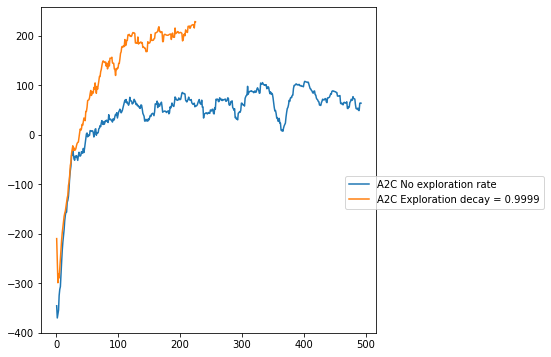

In [101]:
scores = [agentA2C_1.training_scores, agentA2C_2.training_scores]
names = ["A2C No exploration rate","A2C Exploration decay = 0.9999"]
plot_scores(scores, names)

# Sokoban

In [190]:
BLOCK_SIZE = 16
GAME_DIMENSION = 7

STATE_DIMENSION = 5

KNOWN_BLOCK_HASHES = {
    -6266362439051565649 : 1, # wall
    3505480816438514598 : 2, # empty
    -7858845969347537544 : 3, # box
    -4136424555010467604 : 4, # goal for box
    1518700435988403429 : 5, # me
    -6917688000307977437 : 6, # me on goal for box
    -5521694738111534920 : 7, # box on goal for box
}

def show_state(state):
    figure, axis = plt.subplots(1, 1,figsize=(4,4))
    axis.imshow(state)
    
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.astype(int)

def strip_border(state):
    return state.reshape(GAME_DIMENSION, GAME_DIMENSION)[1:-1, 1:-1].reshape(1, (GAME_DIMENSION - 2) ** 2)


def process_state(state):
    state = rgb2gray(state)
    new_state = []
    for i in range(0, state.shape[0], BLOCK_SIZE):
        for j in range(0, state.shape[1], BLOCK_SIZE):
            block = state[i:i+BLOCK_SIZE,j:j+BLOCK_SIZE]
            block = tuple(block.flatten())
            if hash(block) in KNOWN_BLOCK_HASHES:
                new_state.append(KNOWN_BLOCK_HASHES[hash(block)])
            else:
                print("Unknown Block")
                print(block)
                raise Exception("Unknown Block")
    return strip_border(np.array(new_state))

class SokobanEnvFinal():
    def __init__(self) -> None:
        self.env = gym.make('PushAndPull-Sokoban-v2')
        self.observation_space = (self.env.observation_space.shape[0] // BLOCK_SIZE - 2) * (self.env.observation_space.shape[1] // BLOCK_SIZE - 2)
        self.action_space = self.env.action_space
        self.state = self.env.reset()

    def reset(self):
        self.state = self.env.reset()
        return process_state(self.state)

    def step(self, action):
        prev_state = self.state.copy()
        state, reward, done, _ = self.env.step(action)
        if np.array_equal(state, prev_state):
            reward -= 0.1
        self.state = state
        return process_state(state), reward, done, {}

In [196]:
env = SokobanEnvFinal()
state_size, action_size = env.observation_space, env.action_space.n
action_size

13

In [207]:
agentA2C_sokoban = A2CAgent(state_size, action_size, "storage/A2C_sokoban_v1", actor_lr=0.001, critic_lr=0.001, memory_size=640000, exploration_decay=1)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 200)               5200      
_________________________________________________________________
dense_136 (Dense)            (None, 140)               28140     
_________________________________________________________________
dense_137 (Dense)            (None, 13)                1833      
Total params: 35,173
Trainable params: 35,173
Non-trainable params: 0
_________________________________________________________________


C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [208]:
train_agent(agentA2C_sokoban, env, episodes = 500, max_timestamps_per_game=50)

Episode 0, Exp rate: 1, Score: -7.0, Average last 100 episodes: -7.0 Time Elapsed: 0h 0m 2s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 1, Exp rate: 1, Score: -7.8, Average last 100 episodes: -7.4 Time Elapsed: 0h 0m 13s
Episode 2, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.97 Time Elapsed: 0h 0m 24s
Episode 3, Exp rate: 1, Score: -7.1, Average last 100 episodes: -7.0 Time Elapsed: 0h 0m 35s
Episode 4, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.98 Time Elapsed: 0h 0m 46s
Episode 5, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.95 Time Elapsed: 0h 0m 58s
Episode 6, Exp rate: 1, Score: -9.6, Average last 100 episodes: -7.33 Time Elapsed: 0h 1m 11s
Episode 7, Exp rate: 1, Score: -6.7, Average last 100 episodes: -7.25 Time Elapsed: 0h 1m 22s
Episode 8, Exp rate: 1, Score: -7.7, Average last 100 episodes: -7.3 Time Elapsed

Episode 80, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.94 Time Elapsed: 0h 19m 58s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 81, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.94 Time Elapsed: 0h 20m 28s
Episode 82, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.94 Time Elapsed: 0h 20m 57s
Episode 83, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.94 Time Elapsed: 0h 21m 23s
Episode 84, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.93 Time Elapsed: 0h 21m 55s
Episode 85, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.92 Time Elapsed: 0h 22m 25s
Episode 86, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.92 Time Elapsed: 0h 22m 36s
Episode 87, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.92 Time Elapsed: 0h 22m 47s
Episode 88, Exp rate: 1, Score: -6.6, Average last 100 episod

Episode 158, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.81 Time Elapsed: 0h 35m 10s
Episode 159, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.81 Time Elapsed: 0h 35m 20s
Episode 160, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.82 Time Elapsed: 0h 35m 30s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 161, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.8 Time Elapsed: 0h 35m 42s
Episode 162, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.82 Time Elapsed: 0h 35m 52s
Episode 163, Exp rate: 1, Score: -4.3, Average last 100 episodes: -6.79 Time Elapsed: 0h 36m 2s
Episode 164, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.77 Time Elapsed: 0h 36m 12s
Episode 165, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.77 Time Elapsed: 0h 36m 21s
Episode 166, Exp rate: 1, Score: -7.2, Average last 100

Episode 236, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.61 Time Elapsed: 0h 48m 4s
Episode 237, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.6 Time Elapsed: 0h 48m 14s
Episode 238, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.59 Time Elapsed: 0h 48m 24s
Episode 239, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.59 Time Elapsed: 0h 48m 34s
Episode 240, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.58 Time Elapsed: 0h 48m 44s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 241, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.58 Time Elapsed: 0h 48m 56s
Episode 242, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.59 Time Elapsed: 0h 49m 7s
Episode 243, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.59 Time Elapsed: 0h 49m 17s
Episode 244, Exp rate: 1, Score: -7.7, Average last 100 

Episode 314, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.54 Time Elapsed: 1h 0m 56s
Episode 315, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.54 Time Elapsed: 1h 1m 6s
Episode 316, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.54 Time Elapsed: 1h 1m 16s
Episode 317, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.55 Time Elapsed: 1h 1m 25s
Episode 318, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.53 Time Elapsed: 1h 1m 35s
Episode 319, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.52 Time Elapsed: 1h 1m 44s
Episode 320, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.52 Time Elapsed: 1h 1m 54s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 321, Exp rate: 1, Score: -8.5, Average last 100 episodes: -6.54 Time Elapsed: 1h 2m 6s
Episode 322, Exp rate: 1, Score: -6.9, Average last 100 episode

Episode 393, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.83 Time Elapsed: 1h 14m 2s
Episode 394, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.83 Time Elapsed: 1h 14m 12s
Episode 395, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.82 Time Elapsed: 1h 14m 21s
Episode 396, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.82 Time Elapsed: 1h 14m 31s
Episode 397, Exp rate: 1, Score: -8.7, Average last 100 episodes: -6.84 Time Elapsed: 1h 14m 41s
Episode 398, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.83 Time Elapsed: 1h 14m 51s
Episode 399, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.85 Time Elapsed: 1h 15m 1s
Episode 400, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.84 Time Elapsed: 1h 15m 10s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 401, Exp rate: 1, Score: -6.4, Average last 100

Episode 471, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.77 Time Elapsed: 1h 26m 52s
Episode 472, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.78 Time Elapsed: 1h 27m 2s
Episode 473, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.78 Time Elapsed: 1h 27m 12s
Episode 474, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.77 Time Elapsed: 1h 27m 22s
Episode 475, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.77 Time Elapsed: 1h 27m 32s
Episode 476, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.77 Time Elapsed: 1h 27m 42s
Episode 477, Exp rate: 1, Score: -8.2, Average last 100 episodes: -6.78 Time Elapsed: 1h 27m 51s
Episode 478, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.77 Time Elapsed: 1h 28m 1s
Episode 479, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.76 Time Elapsed: 1h 28m 11s
Episode 480, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.76 Time Elapsed: 1h 28m 21s
INFO:tensorflow:Assets written t

In [218]:
train_agent(agentA2C_sokoban, env, episodes = 50000, max_timestamps_per_game=50)

Episode 0, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.65 Time Elapsed: 0h 0m 46s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 1, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.65 Time Elapsed: 0h 1m 2s
Episode 2, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.65 Time Elapsed: 0h 1m 14s
Episode 3, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.64 Time Elapsed: 0h 1m 26s
Episode 4, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.65 Time Elapsed: 0h 1m 37s
Episode 5, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.64 Time Elapsed: 0h 1m 49s
Episode 6, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.63 Time Elapsed: 0h 2m 1s
Episode 7, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.64 Time Elapsed: 0h 2m 13s
Episode 8, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.66 Time Elap

Episode 79, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.85 Time Elapsed: 0h 15m 19s
Episode 80, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.86 Time Elapsed: 0h 15m 30s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 81, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.87 Time Elapsed: 0h 15m 43s
Episode 82, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.86 Time Elapsed: 0h 15m 53s
Episode 83, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.87 Time Elapsed: 0h 16m 3s
Episode 84, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.88 Time Elapsed: 0h 16m 14s
Episode 85, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.88 Time Elapsed: 0h 16m 24s
Episode 86, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.87 Time Elapsed: 0h 16m 35s
Episode 87, Exp rate: 1, Score: -6.0, Average last 100 episode

Episode 157, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.89 Time Elapsed: 0h 29m 13s
Episode 158, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.88 Time Elapsed: 0h 29m 23s
Episode 159, Exp rate: 1, Score: -8.3, Average last 100 episodes: -6.88 Time Elapsed: 0h 29m 33s
Episode 160, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.88 Time Elapsed: 0h 29m 44s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 161, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.89 Time Elapsed: 0h 29m 57s
Episode 162, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.9 Time Elapsed: 0h 30m 7s
Episode 163, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.87 Time Elapsed: 0h 30m 18s
Episode 164, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.88 Time Elapsed: 0h 30m 28s
Episode 165, Exp rate: 1, Score: -7.0, Average last 100

Episode 235, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.96 Time Elapsed: 0h 43m 4s
Episode 236, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.96 Time Elapsed: 0h 43m 15s
Episode 237, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.96 Time Elapsed: 0h 43m 25s
Episode 238, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.95 Time Elapsed: 0h 43m 35s
Episode 239, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.95 Time Elapsed: 0h 43m 46s
Episode 240, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.96 Time Elapsed: 0h 43m 57s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 241, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.96 Time Elapsed: 0h 44m 10s
Episode 242, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.96 Time Elapsed: 0h 44m 20s
Episode 243, Exp rate: 1, Score: -6.4, Average last 10

Episode 313, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.88 Time Elapsed: 0h 57m 8s
Episode 314, Exp rate: 1, Score: -5.1, Average last 100 episodes: -6.85 Time Elapsed: 0h 57m 19s
Episode 315, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.86 Time Elapsed: 0h 57m 29s
Episode 316, Exp rate: 1, Score: -8.4, Average last 100 episodes: -6.88 Time Elapsed: 0h 57m 40s
Episode 317, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.87 Time Elapsed: 0h 57m 51s
Episode 318, Exp rate: 1, Score: -8.6, Average last 100 episodes: -6.89 Time Elapsed: 0h 58m 3s
Episode 319, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.9 Time Elapsed: 0h 58m 14s
Episode 320, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.9 Time Elapsed: 0h 58m 24s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 321, Exp rate: 1, Score: -6.8, Average last 100 e

Episode 392, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.84 Time Elapsed: 1h 11m 18s
Episode 393, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.84 Time Elapsed: 1h 11m 29s
Episode 394, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.85 Time Elapsed: 1h 11m 44s
Episode 395, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.84 Time Elapsed: 1h 11m 56s
Episode 396, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.84 Time Elapsed: 1h 12m 7s
Episode 397, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.86 Time Elapsed: 1h 12m 19s
Episode 398, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.86 Time Elapsed: 1h 12m 33s
Episode 399, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.87 Time Elapsed: 1h 12m 44s
Episode 400, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.87 Time Elapsed: 1h 12m 57s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\

Episode 470, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.82 Time Elapsed: 1h 26m 0s
Episode 471, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.82 Time Elapsed: 1h 26m 11s
Episode 472, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.82 Time Elapsed: 1h 26m 22s
Episode 473, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.81 Time Elapsed: 1h 26m 33s
Episode 474, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.8 Time Elapsed: 1h 26m 44s
Episode 475, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.8 Time Elapsed: 1h 26m 55s
Episode 476, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.8 Time Elapsed: 1h 27m 6s
Episode 477, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.79 Time Elapsed: 1h 27m 18s
Episode 478, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.8 Time Elapsed: 1h 27m 29s
Episode 479, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.8 Time Elapsed: 1h 27m 39s
Episode 480, Exp rate: 1, Score: -7.3

Episode 548, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.45 Time Elapsed: 1h 40m 13s
Episode 549, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.44 Time Elapsed: 1h 40m 24s
Episode 550, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.44 Time Elapsed: 1h 40m 35s
Episode 551, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.44 Time Elapsed: 1h 40m 46s
Episode 552, Exp rate: 1, Score: -8.7, Average last 100 episodes: -6.45 Time Elapsed: 1h 40m 57s
Episode 553, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.46 Time Elapsed: 1h 41m 8s
Episode 554, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.46 Time Elapsed: 1h 41m 19s
Episode 555, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.47 Time Elapsed: 1h 41m 29s
Episode 556, Exp rate: 1, Score: -8.8, Average last 100 episodes: -6.49 Time Elapsed: 1h 41m 40s
Episode 557, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.49 Time Elapsed: 1h 41m 51s
Episode 558, Exp rate: 1, Score

Episode 626, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.45 Time Elapsed: 1h 54m 50s
Episode 627, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.61 Time Elapsed: 1h 55m 1s
Episode 628, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.6 Time Elapsed: 1h 55m 12s
Episode 629, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.61 Time Elapsed: 1h 55m 22s
Episode 630, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.61 Time Elapsed: 1h 55m 33s
Episode 631, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.62 Time Elapsed: 1h 55m 44s
Episode 632, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.61 Time Elapsed: 1h 55m 55s
Episode 633, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.6 Time Elapsed: 1h 56m 6s
Episode 634, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.62 Time Elapsed: 1h 56m 17s
Episode 635, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.61 Time Elapsed: 1h 56m 28s
Episode 636, Exp rate: 1, Score: -

Episode 705, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.93 Time Elapsed: 2h 9m 38s
Episode 706, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.93 Time Elapsed: 2h 9m 49s
Episode 707, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.94 Time Elapsed: 2h 10m 0s
Episode 708, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.95 Time Elapsed: 2h 10m 12s
Episode 709, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.94 Time Elapsed: 2h 10m 23s
Episode 710, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.94 Time Elapsed: 2h 10m 35s
Episode 711, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.94 Time Elapsed: 2h 10m 46s
Episode 712, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.96 Time Elapsed: 2h 10m 57s
Episode 713, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.96 Time Elapsed: 2h 11m 8s
Episode 714, Exp rate: 1, Score: -8.2, Average last 100 episodes: -6.98 Time Elapsed: 2h 11m 19s
Episode 715, Exp rate: 1, Score: -

Episode 784, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.92 Time Elapsed: 2h 24m 14s
Episode 785, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.92 Time Elapsed: 2h 24m 25s
Episode 786, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 2h 24m 36s
Episode 787, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.92 Time Elapsed: 2h 24m 46s
Episode 788, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 2h 24m 57s
Episode 789, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.92 Time Elapsed: 2h 25m 9s
Episode 790, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.93 Time Elapsed: 2h 25m 19s
Episode 791, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.93 Time Elapsed: 2h 25m 31s
Episode 792, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.92 Time Elapsed: 2h 25m 41s
Episode 793, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.9 Time Elapsed: 2h 25m 53s
Episode 794, Exp rate: 1, Score:

Episode 862, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.86 Time Elapsed: 2h 38m 38s
Episode 863, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.85 Time Elapsed: 2h 38m 48s
Episode 864, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.85 Time Elapsed: 2h 38m 59s
Episode 865, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.85 Time Elapsed: 2h 39m 9s
Episode 866, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.84 Time Elapsed: 2h 39m 20s
Episode 867, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.84 Time Elapsed: 2h 39m 30s
Episode 868, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.86 Time Elapsed: 2h 39m 41s
Episode 869, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.84 Time Elapsed: 2h 39m 51s
Episode 870, Exp rate: 1, Score: -9.6, Average last 100 episodes: -7.03 Time Elapsed: 2h 40m 1s
Episode 871, Exp rate: 1, Score: -6.8, Average last 100 episodes: -7.03 Time Elapsed: 2h 40m 12s
Episode 872, Exp rate: 1, Score:

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 941, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.92 Time Elapsed: 2h 52m 35s
Episode 942, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.92 Time Elapsed: 2h 52m 45s
Episode 943, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.93 Time Elapsed: 2h 52m 56s
Episode 944, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.93 Time Elapsed: 2h 53m 7s
Episode 945, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.93 Time Elapsed: 2h 53m 17s
Episode 946, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.94 Time Elapsed: 2h 53m 28s
Episode 947, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.94 Time Elapsed: 2h 53m 38s
Episode 948, Exp rate: 1, Score: -8.4, Average last 100 episodes: -6.94 Time Elapsed: 2h 53m 48s
Episode 949, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.95 Time Elapsed: 2h 53m 59s
Episode 950, Exp rate: 1, Score: -6.5, Ave

Episode 1020, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.8 Time Elapsed: 3h 6m 30s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 1021, Exp rate: 1, Score: -5.3, Average last 100 episodes: -6.79 Time Elapsed: 3h 6m 43s
Episode 1022, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.79 Time Elapsed: 3h 6m 54s
Episode 1023, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.78 Time Elapsed: 3h 7m 4s
Episode 1024, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.79 Time Elapsed: 3h 7m 14s
Episode 1025, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.79 Time Elapsed: 3h 7m 25s
Episode 1026, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.79 Time Elapsed: 3h 7m 35s
Episode 1027, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.79 Time Elapsed: 3h 7m 46s
Episode 1028, Exp rate: 1, Score: -6.4, Average last 10

Episode 1098, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.74 Time Elapsed: 3h 20m 17s
Episode 1099, Exp rate: 1, Score: -5.3, Average last 100 episodes: -6.72 Time Elapsed: 3h 20m 27s
Episode 1100, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.71 Time Elapsed: 3h 20m 37s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 1101, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.71 Time Elapsed: 3h 20m 50s
Episode 1102, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.71 Time Elapsed: 3h 21m 0s
Episode 1103, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.7 Time Elapsed: 3h 21m 11s
Episode 1104, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.71 Time Elapsed: 3h 21m 21s
Episode 1105, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.72 Time Elapsed: 3h 21m 32s
Episode 1106, Exp rate: 1, Score: -7.8, Average

Episode 1175, Exp rate: 1, Score: -9.9, Average last 100 episodes: -6.91 Time Elapsed: 3h 33m 50s
Episode 1176, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 3h 34m 1s
Episode 1177, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.91 Time Elapsed: 3h 34m 12s
Episode 1178, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.91 Time Elapsed: 3h 34m 22s
Episode 1179, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.91 Time Elapsed: 3h 34m 33s
Episode 1180, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.91 Time Elapsed: 3h 34m 43s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 1181, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.9 Time Elapsed: 3h 34m 56s
Episode 1182, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.88 Time Elapsed: 3h 35m 7s
Episode 1183, Exp rate: 1, Score: -7.3, Average 

Episode 1252, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.62 Time Elapsed: 3h 47m 24s
Episode 1253, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.62 Time Elapsed: 3h 47m 35s
Episode 1254, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.63 Time Elapsed: 3h 47m 45s
Episode 1255, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.64 Time Elapsed: 3h 47m 56s
Episode 1256, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.63 Time Elapsed: 3h 48m 6s
Episode 1257, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.63 Time Elapsed: 3h 48m 17s
Episode 1258, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.64 Time Elapsed: 3h 48m 27s
Episode 1259, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.63 Time Elapsed: 3h 48m 38s
Episode 1260, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.61 Time Elapsed: 3h 48m 48s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to:

Episode 1329, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.74 Time Elapsed: 4h 1m 1s
Episode 1330, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.73 Time Elapsed: 4h 1m 11s
Episode 1331, Exp rate: 1, Score: -5.3, Average last 100 episodes: -6.72 Time Elapsed: 4h 1m 22s
Episode 1332, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.73 Time Elapsed: 4h 1m 33s
Episode 1333, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.73 Time Elapsed: 4h 1m 43s
Episode 1334, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.73 Time Elapsed: 4h 1m 53s
Episode 1335, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.74 Time Elapsed: 4h 2m 3s
Episode 1336, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.75 Time Elapsed: 4h 2m 14s
Episode 1337, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.73 Time Elapsed: 4h 2m 25s
Episode 1338, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.73 Time Elapsed: 4h 2m 36s
Episode 1339, Exp rate: 1, Score

Episode 1407, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.81 Time Elapsed: 4h 14m 51s
Episode 1408, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.81 Time Elapsed: 4h 15m 1s
Episode 1409, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.8 Time Elapsed: 4h 15m 12s
Episode 1410, Exp rate: 1, Score: 8.0, Average last 100 episodes: -6.65 Time Elapsed: 4h 15m 18s
Episode 1411, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.64 Time Elapsed: 4h 15m 28s
Episode 1412, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.64 Time Elapsed: 4h 15m 39s
Episode 1413, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.63 Time Elapsed: 4h 15m 50s
Episode 1414, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.64 Time Elapsed: 4h 16m 0s
Episode 1415, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.64 Time Elapsed: 4h 16m 11s
Episode 1416, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.65 Time Elapsed: 4h 16m 21s
Episode 1417, Exp rate: 

Episode 1484, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.7 Time Elapsed: 4h 28m 27s
Episode 1485, Exp rate: 1, Score: -8.3, Average last 100 episodes: -6.72 Time Elapsed: 4h 28m 38s
Episode 1486, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.71 Time Elapsed: 4h 28m 49s
Episode 1487, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.71 Time Elapsed: 4h 28m 59s
Episode 1488, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.71 Time Elapsed: 4h 29m 10s
Episode 1489, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.72 Time Elapsed: 4h 29m 20s
Episode 1490, Exp rate: 1, Score: -8.9, Average last 100 episodes: -6.74 Time Elapsed: 4h 29m 31s
Episode 1491, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.74 Time Elapsed: 4h 29m 41s
Episode 1492, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.73 Time Elapsed: 4h 29m 52s
Episode 1493, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.75 Time Elapsed: 4h 30m 2s
Episode 1494, Exp rate

Episode 1561, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.88 Time Elapsed: 4h 42m 7s
Episode 1562, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.89 Time Elapsed: 4h 42m 18s
Episode 1563, Exp rate: 1, Score: -5.0, Average last 100 episodes: -6.88 Time Elapsed: 4h 42m 28s
Episode 1564, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.86 Time Elapsed: 4h 42m 39s
Episode 1565, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.86 Time Elapsed: 4h 42m 50s
Episode 1566, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.86 Time Elapsed: 4h 43m 0s
Episode 1567, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.87 Time Elapsed: 4h 43m 11s
Episode 1568, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.86 Time Elapsed: 4h 43m 21s
Episode 1569, Exp rate: 1, Score: -8.3, Average last 100 episodes: -6.87 Time Elapsed: 4h 43m 32s
Episode 1570, Exp rate: 1, Score: -8.5, Average last 100 episodes: -6.89 Time Elapsed: 4h 43m 42s
Episode 1571, Exp rate

Episode 1640, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.86 Time Elapsed: 4h 56m 8s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 1641, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.86 Time Elapsed: 4h 56m 20s
Episode 1642, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.86 Time Elapsed: 4h 56m 31s
Episode 1643, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.87 Time Elapsed: 4h 56m 42s
Episode 1644, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.87 Time Elapsed: 4h 56m 52s
Episode 1645, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.87 Time Elapsed: 4h 57m 3s
Episode 1646, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.88 Time Elapsed: 4h 57m 13s
Episode 1647, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.88 Time Elapsed: 4h 57m 24s
Episode 1648, Exp rate: 1, Score: -8.2, Average

Episode 1718, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.86 Time Elapsed: 5h 9m 57s
Episode 1719, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.87 Time Elapsed: 5h 10m 7s
Episode 1720, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.88 Time Elapsed: 5h 10m 18s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 1721, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.88 Time Elapsed: 5h 10m 31s
Episode 1722, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.87 Time Elapsed: 5h 10m 42s
Episode 1723, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.88 Time Elapsed: 5h 10m 52s
Episode 1724, Exp rate: 1, Score: -8.2, Average last 100 episodes: -6.89 Time Elapsed: 5h 11m 3s
Episode 1725, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.9 Time Elapsed: 5h 11m 14s
Episode 1726, Exp rate: 1, Score: -6.6, Average l

Episode 1795, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 5h 23m 38s
Episode 1796, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.91 Time Elapsed: 5h 23m 49s
Episode 1797, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.91 Time Elapsed: 5h 23m 59s
Episode 1798, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.91 Time Elapsed: 5h 24m 10s
Episode 1799, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.89 Time Elapsed: 5h 24m 21s
Episode 1800, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.89 Time Elapsed: 5h 24m 32s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 1801, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.9 Time Elapsed: 5h 24m 44s
Episode 1802, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.89 Time Elapsed: 5h 24m 55s
Episode 1803, Exp rate: 1, Score: -8.5, Averag

Episode 1872, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.73 Time Elapsed: 5h 37m 17s
Episode 1873, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.72 Time Elapsed: 5h 37m 28s
Episode 1874, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.72 Time Elapsed: 5h 37m 39s
Episode 1875, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.72 Time Elapsed: 5h 37m 49s
Episode 1876, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.7 Time Elapsed: 5h 37m 59s
Episode 1877, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.7 Time Elapsed: 5h 38m 10s
Episode 1878, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.72 Time Elapsed: 5h 38m 21s
Episode 1879, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.7 Time Elapsed: 5h 38m 31s
Episode 1880, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.7 Time Elapsed: 5h 38m 42s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: st

Episode 1949, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.89 Time Elapsed: 5h 51m 0s
Episode 1950, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.88 Time Elapsed: 5h 51m 11s
Episode 1951, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.88 Time Elapsed: 5h 51m 21s
Episode 1952, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.86 Time Elapsed: 5h 51m 32s
Episode 1953, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.86 Time Elapsed: 5h 51m 42s
Episode 1954, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.99 Time Elapsed: 5h 51m 53s
Episode 1955, Exp rate: 1, Score: -7.6, Average last 100 episodes: -7.0 Time Elapsed: 5h 52m 3s
Episode 1956, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.97 Time Elapsed: 5h 52m 14s
Episode 1957, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.95 Time Elapsed: 5h 52m 25s
Episode 1958, Exp rate: 1, Score: -8.2, Average last 100 episodes: -6.95 Time Elapsed: 5h 52m 35s
Episode 1959, Exp rate:

Episode 2027, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.89 Time Elapsed: 6h 4m 52s
Episode 2028, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.89 Time Elapsed: 6h 5m 3s
Episode 2029, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.89 Time Elapsed: 6h 5m 13s
Episode 2030, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.9 Time Elapsed: 6h 5m 24s
Episode 2031, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.89 Time Elapsed: 6h 5m 34s
Episode 2032, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.9 Time Elapsed: 6h 5m 45s
Episode 2033, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.89 Time Elapsed: 6h 5m 56s
Episode 2034, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.89 Time Elapsed: 6h 6m 6s
Episode 2035, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.9 Time Elapsed: 6h 6m 16s
Episode 2036, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.9 Time Elapsed: 6h 6m 27s
Episode 2037, Exp rate: 1, Score: -7

Episode 2105, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.8 Time Elapsed: 6h 18m 41s
Episode 2106, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.81 Time Elapsed: 6h 18m 52s
Episode 2107, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.82 Time Elapsed: 6h 19m 3s
Episode 2108, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.82 Time Elapsed: 6h 19m 13s
Episode 2109, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.81 Time Elapsed: 6h 19m 24s
Episode 2110, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.8 Time Elapsed: 6h 19m 34s
Episode 2111, Exp rate: 1, Score: -8.4, Average last 100 episodes: -6.82 Time Elapsed: 6h 19m 44s
Episode 2112, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.82 Time Elapsed: 6h 19m 55s
Episode 2113, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.84 Time Elapsed: 6h 20m 6s
Episode 2114, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.85 Time Elapsed: 6h 20m 16s
Episode 2115, Exp rate: 

Episode 2182, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.89 Time Elapsed: 6h 32m 20s
Episode 2183, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.89 Time Elapsed: 6h 32m 31s
Episode 2184, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.89 Time Elapsed: 6h 32m 42s
Episode 2185, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.89 Time Elapsed: 6h 32m 52s
Episode 2186, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.89 Time Elapsed: 6h 33m 3s
Episode 2187, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.9 Time Elapsed: 6h 33m 13s
Episode 2188, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.91 Time Elapsed: 6h 33m 24s
Episode 2189, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.91 Time Elapsed: 6h 33m 34s
Episode 2190, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 6h 33m 45s
Episode 2191, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.9 Time Elapsed: 6h 33m 55s
Episode 2192, Exp rate:

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 2261, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.78 Time Elapsed: 6h 46m 19s
Episode 2262, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.79 Time Elapsed: 6h 46m 30s
Episode 2263, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.79 Time Elapsed: 6h 46m 40s
Episode 2264, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.79 Time Elapsed: 6h 46m 51s
Episode 2265, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.79 Time Elapsed: 6h 47m 2s
Episode 2266, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.79 Time Elapsed: 6h 47m 12s
Episode 2267, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.8 Time Elapsed: 6h 47m 22s
Episode 2268, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.8 Time Elapsed: 6h 47m 33s
Episode 2269, Exp rate: 1, Score: -6.8, Average 

Episode 2338, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.81 Time Elapsed: 6h 59m 55s
Episode 2339, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.81 Time Elapsed: 7h 0m 6s
Episode 2340, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.8 Time Elapsed: 7h 0m 17s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 2341, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.8 Time Elapsed: 7h 0m 29s
Episode 2342, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.79 Time Elapsed: 7h 0m 40s
Episode 2343, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.78 Time Elapsed: 7h 0m 50s
Episode 2344, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.78 Time Elapsed: 7h 1m 1s
Episode 2345, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.78 Time Elapsed: 7h 1m 11s
Episode 2346, Exp rate: 1, Score: -8.3, Average last 100

Episode 2416, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.87 Time Elapsed: 7h 13m 44s
Episode 2417, Exp rate: 1, Score: -5.4, Average last 100 episodes: -6.86 Time Elapsed: 7h 13m 54s
Episode 2418, Exp rate: 1, Score: -9.1, Average last 100 episodes: -6.88 Time Elapsed: 7h 14m 5s
Episode 2419, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.87 Time Elapsed: 7h 14m 16s
Episode 2420, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.88 Time Elapsed: 7h 14m 26s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 2421, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.89 Time Elapsed: 7h 14m 39s
Episode 2422, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.87 Time Elapsed: 7h 14m 49s
Episode 2423, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.86 Time Elapsed: 7h 15m 0s
Episode 2424, Exp rate: 1, Score: -5.9, Average

Episode 2493, Exp rate: 1, Score: -7.3, Average last 100 episodes: -7.02 Time Elapsed: 7h 27m 29s
Episode 2494, Exp rate: 1, Score: -7.3, Average last 100 episodes: -7.02 Time Elapsed: 7h 27m 39s
Episode 2495, Exp rate: 1, Score: -6.3, Average last 100 episodes: -7.0 Time Elapsed: 7h 27m 49s
Episode 2496, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.99 Time Elapsed: 7h 28m 0s
Episode 2497, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.99 Time Elapsed: 7h 28m 11s
Episode 2498, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.97 Time Elapsed: 7h 28m 21s
Episode 2499, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.98 Time Elapsed: 7h 28m 32s
Episode 2500, Exp rate: 1, Score: -7.6, Average last 100 episodes: -7.0 Time Elapsed: 7h 28m 42s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 2501, Exp rate: 1, Score: -6.9, Average 

Episode 2570, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.73 Time Elapsed: 7h 41m 10s
Episode 2571, Exp rate: 1, Score: 6.8, Average last 100 episodes: -6.6 Time Elapsed: 7h 41m 16s
Episode 2572, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.6 Time Elapsed: 7h 41m 27s
Episode 2573, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.61 Time Elapsed: 7h 41m 38s
Episode 2574, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.62 Time Elapsed: 7h 41m 48s
Episode 2575, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.62 Time Elapsed: 7h 41m 58s
Episode 2576, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.63 Time Elapsed: 7h 42m 9s
Episode 2577, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.62 Time Elapsed: 7h 42m 20s
Episode 2578, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.62 Time Elapsed: 7h 42m 30s
Episode 2579, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.61 Time Elapsed: 7h 42m 41s
Episode 2580, Exp rate: 

Episode 2647, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.6 Time Elapsed: 7h 54m 52s
Episode 2648, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.59 Time Elapsed: 7h 55m 2s
Episode 2649, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.58 Time Elapsed: 7h 55m 13s
Episode 2650, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.58 Time Elapsed: 7h 55m 24s
Episode 2651, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.58 Time Elapsed: 7h 55m 34s
Episode 2652, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.58 Time Elapsed: 7h 55m 44s
Episode 2653, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.56 Time Elapsed: 7h 55m 55s
Episode 2654, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.55 Time Elapsed: 7h 56m 5s
Episode 2655, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.55 Time Elapsed: 7h 56m 16s
Episode 2656, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.54 Time Elapsed: 7h 56m 26s
Episode 2657, Exp rate:

Episode 2725, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.92 Time Elapsed: 8h 8m 42s
Episode 2726, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.91 Time Elapsed: 8h 8m 52s
Episode 2727, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.9 Time Elapsed: 8h 9m 3s
Episode 2728, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.89 Time Elapsed: 8h 9m 13s
Episode 2729, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.89 Time Elapsed: 8h 9m 24s
Episode 2730, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.91 Time Elapsed: 8h 9m 34s
Episode 2731, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.92 Time Elapsed: 8h 9m 45s
Episode 2732, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.93 Time Elapsed: 8h 9m 55s
Episode 2733, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.94 Time Elapsed: 8h 10m 6s
Episode 2734, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.95 Time Elapsed: 8h 10m 16s
Episode 2735, Exp rate: 1, Scor

Episode 2802, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.98 Time Elapsed: 8h 22m 22s
Episode 2803, Exp rate: 1, Score: -8.2, Average last 100 episodes: -6.99 Time Elapsed: 8h 22m 33s
Episode 2804, Exp rate: 1, Score: -7.8, Average last 100 episodes: -7.0 Time Elapsed: 8h 22m 44s
Episode 2805, Exp rate: 1, Score: 6.6, Average last 100 episodes: -6.87 Time Elapsed: 8h 22m 50s
Episode 2806, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.85 Time Elapsed: 8h 23m 1s
Episode 2807, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.85 Time Elapsed: 8h 23m 11s
Episode 2808, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.86 Time Elapsed: 8h 23m 22s
Episode 2809, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.85 Time Elapsed: 8h 23m 32s
Episode 2810, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.86 Time Elapsed: 8h 23m 43s
Episode 2811, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.86 Time Elapsed: 8h 23m 53s
Episode 2812, Exp rate:

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 2881, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.6 Time Elapsed: 8h 36m 10s
Episode 2882, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.59 Time Elapsed: 8h 36m 21s
Episode 2883, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.6 Time Elapsed: 8h 36m 31s
Episode 2884, Exp rate: 1, Score: -8.4, Average last 100 episodes: -6.62 Time Elapsed: 8h 36m 42s
Episode 2885, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.61 Time Elapsed: 8h 36m 52s
Episode 2886, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.59 Time Elapsed: 8h 37m 2s
Episode 2887, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.6 Time Elapsed: 8h 37m 13s
Episode 2888, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.61 Time Elapsed: 8h 37m 23s
Episode 2889, Exp rate: 1, Score: -5.2, Average l

Episode 2958, Exp rate: 1, Score: 4.6, Average last 100 episodes: -6.46 Time Elapsed: 8h 49m 44s
Episode 2959, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.45 Time Elapsed: 8h 49m 54s
Episode 2960, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.44 Time Elapsed: 8h 50m 4s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 2961, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.45 Time Elapsed: 8h 50m 17s
Episode 2962, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.62 Time Elapsed: 8h 50m 28s
Episode 2963, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.63 Time Elapsed: 8h 50m 38s
Episode 2964, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.63 Time Elapsed: 8h 50m 48s
Episode 2965, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.63 Time Elapsed: 8h 50m 59s
Episode 2966, Exp rate: 1, Score: -7.4, Average

Episode 3036, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.52 Time Elapsed: 9h 3m 35s
Episode 3037, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.52 Time Elapsed: 9h 3m 46s
Episode 3038, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.52 Time Elapsed: 9h 3m 57s
Episode 3039, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.53 Time Elapsed: 9h 4m 7s
Episode 3040, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.53 Time Elapsed: 9h 4m 17s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 3041, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.52 Time Elapsed: 9h 4m 30s
Episode 3042, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.53 Time Elapsed: 9h 4m 41s
Episode 3043, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.54 Time Elapsed: 9h 4m 51s
Episode 3044, Exp rate: 1, Score: -7.2, Average last 1

Episode 3114, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.63 Time Elapsed: 9h 17m 19s
Episode 3115, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.61 Time Elapsed: 9h 17m 30s
Episode 3116, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.61 Time Elapsed: 9h 17m 40s
Episode 3117, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.6 Time Elapsed: 9h 17m 51s
Episode 3118, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.61 Time Elapsed: 9h 18m 1s
Episode 3119, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.6 Time Elapsed: 9h 18m 12s
Episode 3120, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.59 Time Elapsed: 9h 18m 22s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 3121, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.59 Time Elapsed: 9h 18m 35s
Episode 3122, Exp rate: 1, Score: -6.6, Average 

Episode 3191, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.79 Time Elapsed: 9h 30m 59s
Episode 3192, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.79 Time Elapsed: 9h 31m 9s
Episode 3193, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.79 Time Elapsed: 9h 31m 19s
Episode 3194, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.78 Time Elapsed: 9h 31m 30s
Episode 3195, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.77 Time Elapsed: 9h 31m 41s
Episode 3196, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.76 Time Elapsed: 9h 31m 51s
Episode 3197, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.77 Time Elapsed: 9h 32m 1s
Episode 3198, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.78 Time Elapsed: 9h 32m 12s
Episode 3199, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.78 Time Elapsed: 9h 32m 22s
Episode 3200, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.77 Time Elapsed: 9h 32m 33s
INFO:tensorflow:Assets

Episode 3268, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.64 Time Elapsed: 9h 44m 33s
Episode 3269, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.64 Time Elapsed: 9h 44m 43s
Episode 3270, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.64 Time Elapsed: 9h 44m 54s
Episode 3271, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.65 Time Elapsed: 9h 45m 4s
Episode 3272, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.66 Time Elapsed: 9h 45m 15s
Episode 3273, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.68 Time Elapsed: 9h 45m 25s
Episode 3274, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.68 Time Elapsed: 9h 45m 36s
Episode 3275, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.68 Time Elapsed: 9h 45m 47s
Episode 3276, Exp rate: 1, Score: -5.1, Average last 100 episodes: -6.66 Time Elapsed: 9h 45m 57s
Episode 3277, Exp rate: 1, Score: -8.4, Average last 100 episodes: -6.67 Time Elapsed: 9h 46m 8s
Episode 3278, Exp rate

Episode 3345, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.65 Time Elapsed: 9h 58m 29s
Episode 3346, Exp rate: 1, Score: -8.9, Average last 100 episodes: -6.66 Time Elapsed: 9h 58m 39s
Episode 3347, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.66 Time Elapsed: 9h 58m 50s
Episode 3348, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.82 Time Elapsed: 9h 59m 1s
Episode 3349, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.82 Time Elapsed: 9h 59m 11s
Episode 3350, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.81 Time Elapsed: 9h 59m 22s
Episode 3351, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.81 Time Elapsed: 9h 59m 33s
Episode 3352, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.82 Time Elapsed: 9h 59m 43s
Episode 3353, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.81 Time Elapsed: 9h 59m 54s
Episode 3354, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.82 Time Elapsed: 10h 0m 5s
Episode 3355, Exp rate

Episode 3422, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.86 Time Elapsed: 10h 12m 20s
Episode 3423, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.86 Time Elapsed: 10h 12m 31s
Episode 3424, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.86 Time Elapsed: 10h 12m 41s
Episode 3425, Exp rate: 1, Score: -5.5, Average last 100 episodes: -6.84 Time Elapsed: 10h 12m 53s
Episode 3426, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.82 Time Elapsed: 10h 13m 4s
Episode 3427, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.83 Time Elapsed: 10h 13m 14s
Episode 3428, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.83 Time Elapsed: 10h 13m 25s
Episode 3429, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.83 Time Elapsed: 10h 13m 35s
Episode 3430, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.84 Time Elapsed: 10h 13m 46s
Episode 3431, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.85 Time Elapsed: 10h 13m 56s
Episode 343

Episode 3500, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.89 Time Elapsed: 10h 26m 18s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 3501, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.88 Time Elapsed: 10h 26m 31s
Episode 3502, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.89 Time Elapsed: 10h 26m 42s
Episode 3503, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.86 Time Elapsed: 10h 26m 52s
Episode 3504, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.86 Time Elapsed: 10h 27m 3s
Episode 3505, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.86 Time Elapsed: 10h 27m 14s
Episode 3506, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.86 Time Elapsed: 10h 27m 25s
Episode 3507, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.85 Time Elapsed: 10h 27m 35s
Episode 3508, Exp rate: 1, Score: -6.6

Episode 3577, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.79 Time Elapsed: 10h 40m 8s
Episode 3578, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.8 Time Elapsed: 10h 40m 19s
Episode 3579, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.8 Time Elapsed: 10h 40m 29s
Episode 3580, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.8 Time Elapsed: 10h 40m 40s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 3581, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.8 Time Elapsed: 10h 40m 53s
Episode 3582, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.78 Time Elapsed: 10h 41m 3s
Episode 3583, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.78 Time Elapsed: 10h 41m 14s
Episode 3584, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.78 Time Elapsed: 10h 41m 24s
Episode 3585, Exp rate: 1, Score: -7.3, Ave

Episode 3654, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.93 Time Elapsed: 10h 53m 50s
Episode 3655, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.93 Time Elapsed: 10h 54m 0s
Episode 3656, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.92 Time Elapsed: 10h 54m 11s
Episode 3657, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.92 Time Elapsed: 10h 54m 22s
Episode 3658, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 10h 54m 32s
Episode 3659, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 10h 54m 43s
Episode 3660, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.9 Time Elapsed: 10h 54m 53s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 3661, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.91 Time Elapsed: 10h 55m 6s
Episode 3662, Exp rate: 1, Score: -6.6, 

Episode 3731, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.74 Time Elapsed: 11h 7m 33s
Episode 3732, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.74 Time Elapsed: 11h 7m 44s
Episode 3733, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.74 Time Elapsed: 11h 7m 55s
Episode 3734, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.74 Time Elapsed: 11h 8m 5s
Episode 3735, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.74 Time Elapsed: 11h 8m 16s
Episode 3736, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.73 Time Elapsed: 11h 8m 27s
Episode 3737, Exp rate: 1, Score: -4.9, Average last 100 episodes: -6.72 Time Elapsed: 11h 8m 38s
Episode 3738, Exp rate: 1, Score: -8.8, Average last 100 episodes: -6.74 Time Elapsed: 11h 8m 48s
Episode 3739, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.74 Time Elapsed: 11h 8m 59s
Episode 3740, Exp rate: 1, Score: -5.3, Average last 100 episodes: -6.71 Time Elapsed: 11h 9m 9s
INFO:tensorflow:Assets

Episode 3808, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.76 Time Elapsed: 11h 21m 20s
Episode 3809, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.75 Time Elapsed: 11h 21m 31s
Episode 3810, Exp rate: 1, Score: -5.4, Average last 100 episodes: -6.74 Time Elapsed: 11h 21m 41s
Episode 3811, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.76 Time Elapsed: 11h 21m 52s
Episode 3812, Exp rate: 1, Score: 7.1, Average last 100 episodes: -6.62 Time Elapsed: 11h 21m 59s
Episode 3813, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.62 Time Elapsed: 11h 22m 10s
Episode 3814, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.63 Time Elapsed: 11h 22m 20s
Episode 3815, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.62 Time Elapsed: 11h 22m 31s
Episode 3816, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.61 Time Elapsed: 11h 22m 41s
Episode 3817, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.61 Time Elapsed: 11h 22m 52s
Episode 381

Episode 3885, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.48 Time Elapsed: 11h 34m 58s
Episode 3886, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.48 Time Elapsed: 11h 35m 9s
Episode 3887, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.47 Time Elapsed: 11h 35m 19s
Episode 3888, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.46 Time Elapsed: 11h 35m 30s
Episode 3889, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.43 Time Elapsed: 11h 35m 40s
Episode 3890, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.43 Time Elapsed: 11h 35m 51s
Episode 3891, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.42 Time Elapsed: 11h 36m 1s
Episode 3892, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.42 Time Elapsed: 11h 36m 12s
Episode 3893, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.42 Time Elapsed: 11h 36m 23s
Episode 3894, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.42 Time Elapsed: 11h 36m 33s
Episode 3895

Episode 3962, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.74 Time Elapsed: 11h 48m 44s
Episode 3963, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.76 Time Elapsed: 11h 48m 55s
Episode 3964, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.75 Time Elapsed: 11h 49m 6s
Episode 3965, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.75 Time Elapsed: 11h 49m 17s
Episode 3966, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.75 Time Elapsed: 11h 49m 27s
Episode 3967, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.74 Time Elapsed: 11h 49m 38s
Episode 3968, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.73 Time Elapsed: 11h 49m 48s
Episode 3969, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.73 Time Elapsed: 11h 49m 59s
Episode 3970, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.73 Time Elapsed: 11h 50m 9s
Episode 3971, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.89 Time Elapsed: 11h 50m 20s
Episode 3972

Episode 4040, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.75 Time Elapsed: 12h 2m 31s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 4041, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.75 Time Elapsed: 12h 2m 44s
Episode 4042, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.74 Time Elapsed: 12h 2m 55s
Episode 4043, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.72 Time Elapsed: 12h 3m 5s
Episode 4044, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.74 Time Elapsed: 12h 3m 16s
Episode 4045, Exp rate: 1, Score: -8.2, Average last 100 episodes: -6.74 Time Elapsed: 12h 3m 26s
Episode 4046, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.75 Time Elapsed: 12h 3m 37s
Episode 4047, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.74 Time Elapsed: 12h 3m 47s
Episode 4048, Exp rate: 1, Score: -6.3, Averag

Episode 4117, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.86 Time Elapsed: 12h 16m 17s
Episode 4118, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.87 Time Elapsed: 12h 16m 27s
Episode 4119, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.87 Time Elapsed: 12h 16m 38s
Episode 4120, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.88 Time Elapsed: 12h 16m 48s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 4121, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.87 Time Elapsed: 12h 17m 2s
Episode 4122, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.87 Time Elapsed: 12h 17m 12s
Episode 4123, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.86 Time Elapsed: 12h 17m 23s
Episode 4124, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.87 Time Elapsed: 12h 17m 33s
Episode 4125, Exp rate: 1, Score: -6.9

Episode 4194, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.78 Time Elapsed: 12h 30m 0s
Episode 4195, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.78 Time Elapsed: 12h 30m 11s
Episode 4196, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.78 Time Elapsed: 12h 30m 22s
Episode 4197, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.77 Time Elapsed: 12h 30m 33s
Episode 4198, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.77 Time Elapsed: 12h 30m 44s
Episode 4199, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.78 Time Elapsed: 12h 30m 55s
Episode 4200, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.76 Time Elapsed: 12h 31m 5s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 4201, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.76 Time Elapsed: 12h 31m 19s
Episode 4202, Exp rate: 1, Score: -6.5,

Episode 4271, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.86 Time Elapsed: 12h 43m 47s
Episode 4272, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.85 Time Elapsed: 12h 43m 59s
Episode 4273, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.85 Time Elapsed: 12h 44m 10s
Episode 4274, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.86 Time Elapsed: 12h 44m 21s
Episode 4275, Exp rate: 1, Score: -8.4, Average last 100 episodes: -6.88 Time Elapsed: 12h 44m 32s
Episode 4276, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.9 Time Elapsed: 12h 44m 43s
Episode 4277, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.9 Time Elapsed: 12h 44m 54s
Episode 4278, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.91 Time Elapsed: 12h 45m 8s
Episode 4279, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.9 Time Elapsed: 12h 45m 25s
Episode 4280, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.91 Time Elapsed: 12h 45m 43s
INFO:tensorflo

Episode 4348, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.91 Time Elapsed: 12h 57m 59s
Episode 4349, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.91 Time Elapsed: 12h 58m 10s
Episode 4350, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.9 Time Elapsed: 12h 58m 20s
Episode 4351, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.91 Time Elapsed: 12h 58m 31s
Episode 4352, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.92 Time Elapsed: 12h 58m 41s
Episode 4353, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.92 Time Elapsed: 12h 58m 52s
Episode 4354, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.92 Time Elapsed: 12h 59m 3s
Episode 4355, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.92 Time Elapsed: 12h 59m 14s
Episode 4356, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.93 Time Elapsed: 12h 59m 24s
Episode 4357, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.93 Time Elapsed: 12h 59m 35s
Episode 4358

Episode 4425, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.94 Time Elapsed: 13h 11m 45s
Episode 4426, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.94 Time Elapsed: 13h 11m 55s
Episode 4427, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.94 Time Elapsed: 13h 12m 6s
Episode 4428, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.93 Time Elapsed: 13h 12m 17s
Episode 4429, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.93 Time Elapsed: 13h 12m 27s
Episode 4430, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.94 Time Elapsed: 13h 12m 38s
Episode 4431, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.95 Time Elapsed: 13h 12m 48s
Episode 4432, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.94 Time Elapsed: 13h 12m 59s
Episode 4433, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.94 Time Elapsed: 13h 13m 9s
Episode 4434, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.92 Time Elapsed: 13h 13m 20s
Episode 4435

Episode 4502, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.87 Time Elapsed: 13h 25m 27s
Episode 4503, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.88 Time Elapsed: 13h 25m 38s
Episode 4504, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.88 Time Elapsed: 13h 25m 48s
Episode 4505, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.89 Time Elapsed: 13h 25m 59s
Episode 4506, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.9 Time Elapsed: 13h 26m 9s
Episode 4507, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.89 Time Elapsed: 13h 26m 19s
Episode 4508, Exp rate: 1, Score: -5.5, Average last 100 episodes: -6.88 Time Elapsed: 13h 26m 30s
Episode 4509, Exp rate: 1, Score: -5.2, Average last 100 episodes: -6.87 Time Elapsed: 13h 26m 41s
Episode 4510, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.86 Time Elapsed: 13h 26m 51s
Episode 4511, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.86 Time Elapsed: 13h 27m 2s
Episode 4512,

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 4581, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.73 Time Elapsed: 13h 39m 21s
Episode 4582, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.74 Time Elapsed: 13h 39m 32s
Episode 4583, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.75 Time Elapsed: 13h 39m 42s
Episode 4584, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.75 Time Elapsed: 13h 39m 52s
Episode 4585, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.73 Time Elapsed: 13h 40m 3s
Episode 4586, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.72 Time Elapsed: 13h 40m 14s
Episode 4587, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.7 Time Elapsed: 13h 40m 25s
Episode 4588, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.69 Time Elapsed: 13h 40m 35s
Episode 4589, Exp rate: 1, Score: -7.4,

Episode 4658, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.57 Time Elapsed: 13h 52m 54s
Episode 4659, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.57 Time Elapsed: 13h 53m 5s
Episode 4660, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.59 Time Elapsed: 13h 53m 16s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 4661, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.58 Time Elapsed: 13h 53m 29s
Episode 4662, Exp rate: 1, Score: 6.1, Average last 100 episodes: -6.44 Time Elapsed: 13h 53m 36s
Episode 4663, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.45 Time Elapsed: 13h 53m 47s
Episode 4664, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.47 Time Elapsed: 13h 53m 57s
Episode 4665, Exp rate: 1, Score: -4.9, Average last 100 episodes: -6.45 Time Elapsed: 13h 54m 8s
Episode 4666, Exp rate: 1, Score: -6.9, 

Episode 4735, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.79 Time Elapsed: 14h 6m 34s
Episode 4736, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.79 Time Elapsed: 14h 6m 45s
Episode 4737, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.8 Time Elapsed: 14h 6m 55s
Episode 4738, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.8 Time Elapsed: 14h 7m 6s
Episode 4739, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.79 Time Elapsed: 14h 7m 16s
Episode 4740, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.8 Time Elapsed: 14h 7m 26s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 4741, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.79 Time Elapsed: 14h 7m 39s
Episode 4742, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.78 Time Elapsed: 14h 7m 50s
Episode 4743, Exp rate: 1, Score: -6.4, Average l

Episode 4812, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.85 Time Elapsed: 14h 20m 19s
Episode 4813, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.86 Time Elapsed: 14h 20m 29s
Episode 4814, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.86 Time Elapsed: 14h 20m 40s
Episode 4815, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.85 Time Elapsed: 14h 20m 51s
Episode 4816, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.84 Time Elapsed: 14h 21m 2s
Episode 4817, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.86 Time Elapsed: 14h 21m 12s
Episode 4818, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.86 Time Elapsed: 14h 21m 23s
Episode 4819, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.87 Time Elapsed: 14h 21m 33s
Episode 4820, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.88 Time Elapsed: 14h 21m 44s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets wr

Episode 4889, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.9 Time Elapsed: 14h 34m 4s
Episode 4890, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.9 Time Elapsed: 14h 34m 15s
Episode 4891, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.9 Time Elapsed: 14h 34m 26s
Episode 4892, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.89 Time Elapsed: 14h 34m 36s
Episode 4893, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.9 Time Elapsed: 14h 34m 47s
Episode 4894, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.92 Time Elapsed: 14h 34m 58s
Episode 4895, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 14h 35m 8s
Episode 4896, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.93 Time Elapsed: 14h 35m 18s
Episode 4897, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.91 Time Elapsed: 14h 35m 29s
Episode 4898, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.91 Time Elapsed: 14h 35m 40s
Episode 4899, Ex

Episode 4966, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.87 Time Elapsed: 14h 47m 48s
Episode 4967, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.88 Time Elapsed: 14h 47m 59s
Episode 4968, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.89 Time Elapsed: 14h 48m 9s
Episode 4969, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.88 Time Elapsed: 14h 48m 20s
Episode 4970, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.88 Time Elapsed: 14h 48m 30s
Episode 4971, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.88 Time Elapsed: 14h 48m 41s
Episode 4972, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.88 Time Elapsed: 14h 48m 51s
Episode 4973, Exp rate: 1, Score: -9.1, Average last 100 episodes: -6.91 Time Elapsed: 14h 49m 2s
Episode 4974, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.9 Time Elapsed: 14h 49m 13s
Episode 4975, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.89 Time Elapsed: 14h 49m 23s
Episode 4976,

Episode 5043, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.71 Time Elapsed: 15h 1m 21s
Episode 5044, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.68 Time Elapsed: 15h 1m 31s
Episode 5045, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.69 Time Elapsed: 15h 1m 42s
Episode 5046, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.67 Time Elapsed: 15h 1m 53s
Episode 5047, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.67 Time Elapsed: 15h 2m 3s
Episode 5048, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.66 Time Elapsed: 15h 2m 14s
Episode 5049, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.65 Time Elapsed: 15h 2m 24s
Episode 5050, Exp rate: 1, Score: 6.7, Average last 100 episodes: -6.5 Time Elapsed: 15h 2m 32s
Episode 5051, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.49 Time Elapsed: 15h 2m 42s
Episode 5052, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.5 Time Elapsed: 15h 2m 53s
Episode 5053, Exp rate: 

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 5121, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.62 Time Elapsed: 15h 15m 12s
Episode 5122, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.62 Time Elapsed: 15h 15m 23s
Episode 5123, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.62 Time Elapsed: 15h 15m 34s
Episode 5124, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.61 Time Elapsed: 15h 15m 45s
Episode 5125, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.61 Time Elapsed: 15h 15m 55s
Episode 5126, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.63 Time Elapsed: 15h 16m 6s
Episode 5127, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.62 Time Elapsed: 15h 16m 17s
Episode 5128, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.63 Time Elapsed: 15h 16m 27s
Episode 5129, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.62 Time Elapsed: 15h 16m 38s
Episode 5130, Exp rate: 

Episode 5198, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.9 Time Elapsed: 15h 28m 58s
Episode 5199, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.91 Time Elapsed: 15h 29m 8s
Episode 5200, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.92 Time Elapsed: 15h 29m 19s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 5201, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.93 Time Elapsed: 15h 29m 32s
Episode 5202, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.91 Time Elapsed: 15h 29m 42s
Episode 5203, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.91 Time Elapsed: 15h 29m 53s
Episode 5204, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.89 Time Elapsed: 15h 30m 4s
Episode 5205, Exp rate: 1, Score: -5.5, Average last 100 episodes: -6.88 Time Elapsed: 15h 30m 15s
Episode 5206, Exp rate: 1, Score: -6.8, 

Episode 5275, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.61 Time Elapsed: 15h 42m 31s
Episode 5276, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.6 Time Elapsed: 15h 42m 42s
Episode 5277, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.58 Time Elapsed: 15h 42m 52s
Episode 5278, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.59 Time Elapsed: 15h 43m 3s
Episode 5279, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.59 Time Elapsed: 15h 43m 14s
Episode 5280, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.58 Time Elapsed: 15h 43m 24s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 5281, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.58 Time Elapsed: 15h 43m 37s
Episode 5282, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.55 Time Elapsed: 15h 43m 48s
Episode 5283, Exp rate: 1, Score: -6.9,

Episode 5352, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.67 Time Elapsed: 15h 56m 17s
Episode 5353, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.66 Time Elapsed: 15h 56m 27s
Episode 5354, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.81 Time Elapsed: 15h 56m 38s
Episode 5355, Exp rate: 1, Score: -5.0, Average last 100 episodes: -6.79 Time Elapsed: 15h 56m 48s
Episode 5356, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.8 Time Elapsed: 15h 56m 59s
Episode 5357, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.78 Time Elapsed: 15h 57m 9s
Episode 5358, Exp rate: 1, Score: 8.4, Average last 100 episodes: -6.63 Time Elapsed: 15h 57m 14s
Episode 5359, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.64 Time Elapsed: 15h 57m 25s
Episode 5360, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.65 Time Elapsed: 15h 57m 35s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets writ

Episode 5429, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.49 Time Elapsed: 16h 9m 51s
Episode 5430, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.48 Time Elapsed: 16h 10m 2s
Episode 5431, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.48 Time Elapsed: 16h 10m 12s
Episode 5432, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.49 Time Elapsed: 16h 10m 23s
Episode 5433, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.5 Time Elapsed: 16h 10m 34s
Episode 5434, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.5 Time Elapsed: 16h 10m 46s
Episode 5435, Exp rate: 1, Score: -4.9, Average last 100 episodes: -6.48 Time Elapsed: 16h 10m 56s
Episode 5436, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.47 Time Elapsed: 16h 11m 7s
Episode 5437, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.48 Time Elapsed: 16h 11m 17s
Episode 5438, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.51 Time Elapsed: 16h 11m 28s
Episode 5439, E

Episode 5506, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.68 Time Elapsed: 16h 23m 40s
Episode 5507, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.68 Time Elapsed: 16h 23m 51s
Episode 5508, Exp rate: 1, Score: -8.7, Average last 100 episodes: -6.7 Time Elapsed: 16h 24m 1s
Episode 5509, Exp rate: 1, Score: 9.4, Average last 100 episodes: -6.53 Time Elapsed: 16h 24m 4s
Episode 5510, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.68 Time Elapsed: 16h 24m 15s
Episode 5511, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.69 Time Elapsed: 16h 24m 25s
Episode 5512, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.68 Time Elapsed: 16h 24m 36s
Episode 5513, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.68 Time Elapsed: 16h 24m 46s
Episode 5514, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.68 Time Elapsed: 16h 24m 57s
Episode 5515, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.68 Time Elapsed: 16h 25m 8s
Episode 5516, E

Episode 5583, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.64 Time Elapsed: 16h 37m 23s
Episode 5584, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.63 Time Elapsed: 16h 37m 33s
Episode 5585, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.63 Time Elapsed: 16h 37m 44s
Episode 5586, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.61 Time Elapsed: 16h 37m 54s
Episode 5587, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.62 Time Elapsed: 16h 38m 4s
Episode 5588, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.62 Time Elapsed: 16h 38m 15s
Episode 5589, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.62 Time Elapsed: 16h 38m 26s
Episode 5590, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.62 Time Elapsed: 16h 38m 36s
Episode 5591, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.61 Time Elapsed: 16h 38m 47s
Episode 5592, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.61 Time Elapsed: 16h 38m 58s
Episode 559

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 5661, Exp rate: 1, Score: -5.4, Average last 100 episodes: -6.68 Time Elapsed: 16h 51m 13s
Episode 5662, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.68 Time Elapsed: 16h 51m 23s
Episode 5663, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.7 Time Elapsed: 16h 51m 33s
Episode 5664, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.7 Time Elapsed: 16h 51m 45s
Episode 5665, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.71 Time Elapsed: 16h 51m 55s
Episode 5666, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.71 Time Elapsed: 16h 52m 6s
Episode 5667, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.71 Time Elapsed: 16h 52m 16s
Episode 5668, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.7 Time Elapsed: 16h 52m 26s
Episode 5669, Exp rate: 1, Score: -10.0, 

Episode 5738, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.83 Time Elapsed: 17h 4m 55s
Episode 5739, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.82 Time Elapsed: 17h 5m 6s
Episode 5740, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.84 Time Elapsed: 17h 5m 16s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 5741, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.84 Time Elapsed: 17h 5m 30s
Episode 5742, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.84 Time Elapsed: 17h 5m 40s
Episode 5743, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.83 Time Elapsed: 17h 5m 51s
Episode 5744, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.82 Time Elapsed: 17h 6m 1s
Episode 5745, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.83 Time Elapsed: 17h 6m 11s
Episode 5746, Exp rate: 1, Score: -7.0, Average

Episode 5815, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.82 Time Elapsed: 17h 18m 40s
Episode 5816, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.83 Time Elapsed: 17h 18m 51s
Episode 5817, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.82 Time Elapsed: 17h 19m 2s
Episode 5818, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.83 Time Elapsed: 17h 19m 12s
Episode 5819, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.85 Time Elapsed: 17h 19m 23s
Episode 5820, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.84 Time Elapsed: 17h 19m 34s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 5821, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.84 Time Elapsed: 17h 19m 47s
Episode 5822, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.83 Time Elapsed: 17h 19m 57s
Episode 5823, Exp rate: 1, Score: -5.7

Episode 5892, Exp rate: 1, Score: -8.3, Average last 100 episodes: -6.66 Time Elapsed: 17h 32m 24s
Episode 5893, Exp rate: 1, Score: -5.5, Average last 100 episodes: -6.65 Time Elapsed: 17h 32m 35s
Episode 5894, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.64 Time Elapsed: 17h 32m 45s
Episode 5895, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.63 Time Elapsed: 17h 32m 56s
Episode 5896, Exp rate: 1, Score: -5.3, Average last 100 episodes: -6.61 Time Elapsed: 17h 33m 6s
Episode 5897, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.63 Time Elapsed: 17h 33m 16s
Episode 5898, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.63 Time Elapsed: 17h 33m 28s
Episode 5899, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.63 Time Elapsed: 17h 33m 38s
Episode 5900, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.63 Time Elapsed: 17h 33m 48s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets wr

Episode 5969, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.81 Time Elapsed: 17h 46m 10s
Episode 5970, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.81 Time Elapsed: 17h 46m 20s
Episode 5971, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.81 Time Elapsed: 17h 46m 31s
Episode 5972, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.81 Time Elapsed: 17h 46m 41s
Episode 5973, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.81 Time Elapsed: 17h 46m 52s
Episode 5974, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.81 Time Elapsed: 17h 47m 3s
Episode 5975, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.81 Time Elapsed: 17h 47m 13s
Episode 5976, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.81 Time Elapsed: 17h 47m 24s
Episode 5977, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.82 Time Elapsed: 17h 47m 34s
Episode 5978, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.82 Time Elapsed: 17h 47m 44s
Episode 597

Episode 6046, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.71 Time Elapsed: 17h 59m 49s
Episode 6047, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.71 Time Elapsed: 17h 59m 59s
Episode 6048, Exp rate: 1, Score: -8.7, Average last 100 episodes: -6.72 Time Elapsed: 18h 0m 9s
Episode 6049, Exp rate: 1, Score: -5.5, Average last 100 episodes: -6.71 Time Elapsed: 18h 0m 21s
Episode 6050, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.71 Time Elapsed: 18h 0m 31s
Episode 6051, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.71 Time Elapsed: 18h 0m 42s
Episode 6052, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.7 Time Elapsed: 18h 0m 53s
Episode 6053, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.71 Time Elapsed: 18h 1m 3s
Episode 6054, Exp rate: 1, Score: -8.4, Average last 100 episodes: -6.73 Time Elapsed: 18h 1m 14s
Episode 6055, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.74 Time Elapsed: 18h 1m 24s
Episode 6056, Exp rat

Episode 6123, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.85 Time Elapsed: 18h 13m 35s
Episode 6124, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.85 Time Elapsed: 18h 13m 46s
Episode 6125, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.85 Time Elapsed: 18h 13m 56s
Episode 6126, Exp rate: 1, Score: -8.2, Average last 100 episodes: -6.87 Time Elapsed: 18h 14m 7s
Episode 6127, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.87 Time Elapsed: 18h 14m 17s
Episode 6128, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.87 Time Elapsed: 18h 14m 28s
Episode 6129, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.86 Time Elapsed: 18h 14m 39s
Episode 6130, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.87 Time Elapsed: 18h 14m 49s
Episode 6131, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.88 Time Elapsed: 18h 15m 0s
Episode 6132, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.88 Time Elapsed: 18h 15m 11s
Episode 6133

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 6201, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.69 Time Elapsed: 18h 27m 34s
Episode 6202, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.69 Time Elapsed: 18h 27m 45s
Episode 6203, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.68 Time Elapsed: 18h 27m 55s
Episode 6204, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.68 Time Elapsed: 18h 28m 6s
Episode 6205, Exp rate: 1, Score: -5.1, Average last 100 episodes: -6.66 Time Elapsed: 18h 28m 17s
Episode 6206, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.66 Time Elapsed: 18h 28m 27s
Episode 6207, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.67 Time Elapsed: 18h 28m 38s
Episode 6208, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.68 Time Elapsed: 18h 28m 49s
Episode 6209, Exp rate: 1, Score: -7.8

Episode 6278, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.65 Time Elapsed: 18h 41m 19s
Episode 6279, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.63 Time Elapsed: 18h 41m 30s
Episode 6280, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.64 Time Elapsed: 18h 41m 41s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 6281, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.66 Time Elapsed: 18h 41m 54s
Episode 6282, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.67 Time Elapsed: 18h 42m 4s
Episode 6283, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.68 Time Elapsed: 18h 42m 14s
Episode 6284, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.69 Time Elapsed: 18h 42m 25s
Episode 6285, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.7 Time Elapsed: 18h 42m 35s
Episode 6286, Exp rate: 1, Score: -6.4,

Episode 6355, Exp rate: 1, Score: -8.2, Average last 100 episodes: -7.0 Time Elapsed: 18h 55m 29s
Episode 6356, Exp rate: 1, Score: -8.0, Average last 100 episodes: -7.02 Time Elapsed: 18h 55m 40s
Episode 6357, Exp rate: 1, Score: -5.8, Average last 100 episodes: -7.0 Time Elapsed: 18h 55m 53s
Episode 6358, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.99 Time Elapsed: 18h 56m 4s
Episode 6359, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.98 Time Elapsed: 18h 56m 16s
Episode 6360, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.98 Time Elapsed: 18h 56m 26s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 6361, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.97 Time Elapsed: 18h 56m 41s
Episode 6362, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.97 Time Elapsed: 18h 56m 52s
Episode 6363, Exp rate: 1, Score: -7.0, 

Episode 6432, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.94 Time Elapsed: 19h 10m 38s
Episode 6433, Exp rate: 1, Score: -5.6, Average last 100 episodes: -6.92 Time Elapsed: 19h 10m 49s
Episode 6434, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.92 Time Elapsed: 19h 11m 1s
Episode 6435, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.93 Time Elapsed: 19h 11m 12s
Episode 6436, Exp rate: 1, Score: -7.7, Average last 100 episodes: -6.94 Time Elapsed: 19h 11m 24s
Episode 6437, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.95 Time Elapsed: 19h 11m 36s
Episode 6438, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.93 Time Elapsed: 19h 11m 47s
Episode 6439, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.92 Time Elapsed: 19h 11m 58s
Episode 6440, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.92 Time Elapsed: 19h 12m 9s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets wri

Episode 6509, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.88 Time Elapsed: 19h 26m 3s
Episode 6510, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.88 Time Elapsed: 19h 26m 15s
Episode 6511, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.89 Time Elapsed: 19h 26m 27s
Episode 6512, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.89 Time Elapsed: 19h 26m 39s
Episode 6513, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.86 Time Elapsed: 19h 26m 50s
Episode 6514, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.86 Time Elapsed: 19h 27m 2s
Episode 6515, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.85 Time Elapsed: 19h 27m 14s
Episode 6516, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.86 Time Elapsed: 19h 27m 25s
Episode 6517, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.86 Time Elapsed: 19h 27m 36s
Episode 6518, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.85 Time Elapsed: 19h 27m 48s
Episode 6519

Episode 6586, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.74 Time Elapsed: 19h 40m 40s
Episode 6587, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.74 Time Elapsed: 19h 40m 51s
Episode 6588, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.73 Time Elapsed: 19h 41m 2s
Episode 6589, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.71 Time Elapsed: 19h 41m 13s
Episode 6590, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.7 Time Elapsed: 19h 41m 24s
Episode 6591, Exp rate: 1, Score: -7.9, Average last 100 episodes: -6.7 Time Elapsed: 19h 41m 36s
Episode 6592, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.69 Time Elapsed: 19h 41m 47s
Episode 6593, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.68 Time Elapsed: 19h 41m 58s
Episode 6594, Exp rate: 1, Score: -5.5, Average last 100 episodes: -6.67 Time Elapsed: 19h 42m 9s
Episode 6595, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.68 Time Elapsed: 19h 42m 20s
Episode 6596, 

Episode 6663, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.77 Time Elapsed: 19h 55m 1s
Episode 6664, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.78 Time Elapsed: 19h 55m 13s
Episode 6665, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.78 Time Elapsed: 19h 55m 23s
Episode 6666, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.78 Time Elapsed: 19h 55m 35s
Episode 6667, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.78 Time Elapsed: 19h 55m 45s
Episode 6668, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.79 Time Elapsed: 19h 55m 56s
Episode 6669, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.79 Time Elapsed: 19h 56m 8s
Episode 6670, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.78 Time Elapsed: 19h 56m 19s
Episode 6671, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.79 Time Elapsed: 19h 56m 30s
Episode 6672, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.78 Time Elapsed: 19h 56m 41s
Episode 6673

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 6741, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.9 Time Elapsed: 20h 9m 39s
Episode 6742, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.89 Time Elapsed: 20h 9m 50s
Episode 6743, Exp rate: 1, Score: -8.0, Average last 100 episodes: -6.9 Time Elapsed: 20h 10m 2s
Episode 6744, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.9 Time Elapsed: 20h 10m 13s
Episode 6745, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.89 Time Elapsed: 20h 10m 23s
Episode 6746, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.88 Time Elapsed: 20h 10m 36s
Episode 6747, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.88 Time Elapsed: 20h 10m 47s
Episode 6748, Exp rate: 1, Score: -5.5, Average last 100 episodes: -6.87 Time Elapsed: 20h 10m 57s
Episode 6749, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.87 Time Elapsed: 20h 11m 9s
Episode 6750, Exp rate: 1, Sco

Episode 6818, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.87 Time Elapsed: 20h 24m 11s
Episode 6819, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.86 Time Elapsed: 20h 24m 23s
Episode 6820, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.87 Time Elapsed: 20h 24m 34s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 6821, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.88 Time Elapsed: 20h 24m 48s
Episode 6822, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.88 Time Elapsed: 20h 24m 58s
Episode 6823, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.88 Time Elapsed: 20h 25m 9s
Episode 6824, Exp rate: 1, Score: 5.6, Average last 100 episodes: -6.75 Time Elapsed: 20h 25m 20s
Episode 6825, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.75 Time Elapsed: 20h 25m 31s
Episode 6826, Exp rate: 1, Score: -5.7,

Episode 6895, Exp rate: 1, Score: 7.1, Average last 100 episodes: -6.63 Time Elapsed: 20h 38m 31s
Episode 6896, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.62 Time Elapsed: 20h 38m 43s
Episode 6897, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.63 Time Elapsed: 20h 38m 53s
Episode 6898, Exp rate: 1, Score: -9.0, Average last 100 episodes: -6.65 Time Elapsed: 20h 39m 5s
Episode 6899, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.66 Time Elapsed: 20h 39m 16s
Episode 6900, Exp rate: 1, Score: -8.6, Average last 100 episodes: -6.68 Time Elapsed: 20h 39m 26s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 6901, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.68 Time Elapsed: 20h 39m 40s
Episode 6902, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.68 Time Elapsed: 20h 39m 51s
Episode 6903, Exp rate: 1, Score: -6.9,

Episode 6972, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.83 Time Elapsed: 20h 52m 47s
Episode 6973, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.81 Time Elapsed: 20h 52m 57s
Episode 6974, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.8 Time Elapsed: 20h 53m 8s
Episode 6975, Exp rate: 1, Score: -5.3, Average last 100 episodes: -6.79 Time Elapsed: 20h 53m 20s
Episode 6976, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.79 Time Elapsed: 20h 53m 30s
Episode 6977, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.78 Time Elapsed: 20h 53m 42s
Episode 6978, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.79 Time Elapsed: 20h 53m 53s
Episode 6979, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.8 Time Elapsed: 20h 54m 3s
Episode 6980, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.8 Time Elapsed: 20h 54m 15s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets writte

Episode 7049, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.53 Time Elapsed: 21h 7m 30s
Episode 7050, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.52 Time Elapsed: 21h 7m 42s
Episode 7051, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.53 Time Elapsed: 21h 7m 54s
Episode 7052, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.52 Time Elapsed: 21h 8m 6s
Episode 7053, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.51 Time Elapsed: 21h 8m 18s
Episode 7054, Exp rate: 1, Score: -7.8, Average last 100 episodes: -6.52 Time Elapsed: 21h 8m 30s
Episode 7055, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.53 Time Elapsed: 21h 8m 42s
Episode 7056, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.52 Time Elapsed: 21h 8m 54s
Episode 7057, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.49 Time Elapsed: 21h 9m 6s
Episode 7058, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.5 Time Elapsed: 21h 9m 18s
Episode 7059, Exp rate:

Episode 7126, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.77 Time Elapsed: 21h 22m 56s
Episode 7127, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.75 Time Elapsed: 21h 23m 8s
Episode 7128, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.76 Time Elapsed: 21h 23m 20s
Episode 7129, Exp rate: 1, Score: -8.2, Average last 100 episodes: -6.77 Time Elapsed: 21h 23m 31s
Episode 7130, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.77 Time Elapsed: 21h 23m 44s
Episode 7131, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.78 Time Elapsed: 21h 23m 55s
Episode 7132, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.77 Time Elapsed: 21h 24m 7s
Episode 7133, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.77 Time Elapsed: 21h 24m 19s
Episode 7134, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.78 Time Elapsed: 21h 24m 31s
Episode 7135, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.78 Time Elapsed: 21h 24m 42s
Episode 7136

Episode 7203, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.89 Time Elapsed: 21h 38m 15s
Episode 7204, Exp rate: 1, Score: -5.1, Average last 100 episodes: -6.88 Time Elapsed: 21h 38m 27s
Episode 7205, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.88 Time Elapsed: 21h 38m 38s
Episode 7206, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.86 Time Elapsed: 21h 38m 51s
Episode 7207, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.86 Time Elapsed: 21h 39m 3s
Episode 7208, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.88 Time Elapsed: 21h 39m 15s
Episode 7209, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.87 Time Elapsed: 21h 39m 27s
Episode 7210, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.88 Time Elapsed: 21h 39m 38s
Episode 7211, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.87 Time Elapsed: 21h 39m 51s
Episode 7212, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.88 Time Elapsed: 21h 40m 2s
Episode 7213

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 7281, Exp rate: 1, Score: -6.3, Average last 100 episodes: -7.0 Time Elapsed: 21h 53m 42s
Episode 7282, Exp rate: 1, Score: -6.8, Average last 100 episodes: -7.0 Time Elapsed: 21h 53m 53s
Episode 7283, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.99 Time Elapsed: 21h 54m 4s
Episode 7284, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.99 Time Elapsed: 21h 54m 16s
Episode 7285, Exp rate: 1, Score: -8.0, Average last 100 episodes: -7.01 Time Elapsed: 21h 54m 28s
Episode 7286, Exp rate: 1, Score: -6.5, Average last 100 episodes: -7.0 Time Elapsed: 21h 54m 39s
Episode 7287, Exp rate: 1, Score: -6.5, Average last 100 episodes: -7.0 Time Elapsed: 21h 54m 51s
Episode 7288, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.99 Time Elapsed: 21h 55m 3s
Episode 7289, Exp rate: 1, Score: -7.7, Ave

Episode 7358, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.92 Time Elapsed: 22h 8m 59s
Episode 7359, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.91 Time Elapsed: 22h 9m 12s
Episode 7360, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.92 Time Elapsed: 22h 9m 23s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 7361, Exp rate: 1, Score: -6.0, Average last 100 episodes: -6.92 Time Elapsed: 22h 9m 38s
Episode 7362, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.92 Time Elapsed: 22h 9m 49s
Episode 7363, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.93 Time Elapsed: 22h 10m 1s
Episode 7364, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.93 Time Elapsed: 22h 10m 13s
Episode 7365, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.92 Time Elapsed: 22h 10m 25s
Episode 7366, Exp rate: 1, Score: -7.7, Ave

Episode 7435, Exp rate: 1, Score: -6.3, Average last 100 episodes: -6.86 Time Elapsed: 22h 24m 7s
Episode 7436, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.86 Time Elapsed: 22h 24m 19s
Episode 7437, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.86 Time Elapsed: 22h 24m 30s
Episode 7438, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.89 Time Elapsed: 22h 24m 41s
Episode 7439, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.9 Time Elapsed: 22h 24m 53s
Episode 7440, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.91 Time Elapsed: 22h 25m 4s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 7441, Exp rate: 1, Score: -7.5, Average last 100 episodes: -6.92 Time Elapsed: 22h 25m 20s
Episode 7442, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.91 Time Elapsed: 22h 25m 31s
Episode 7443, Exp rate: 1, Score: -6.9, 

Episode 7512, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.62 Time Elapsed: 22h 39m 1s
Episode 7513, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.61 Time Elapsed: 22h 39m 12s
Episode 7514, Exp rate: 1, Score: -8.9, Average last 100 episodes: -6.63 Time Elapsed: 22h 39m 24s
Episode 7515, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.64 Time Elapsed: 22h 39m 36s
Episode 7516, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.63 Time Elapsed: 22h 39m 47s
Episode 7517, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.63 Time Elapsed: 22h 39m 59s
Episode 7518, Exp rate: 1, Score: -8.1, Average last 100 episodes: -6.65 Time Elapsed: 22h 40m 10s
Episode 7519, Exp rate: 1, Score: -6.1, Average last 100 episodes: -6.64 Time Elapsed: 22h 40m 22s
Episode 7520, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.64 Time Elapsed: 22h 40m 34s
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets wr

Episode 7589, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.63 Time Elapsed: 22h 54m 3s
Episode 7590, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.63 Time Elapsed: 22h 54m 14s
Episode 7591, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.64 Time Elapsed: 22h 54m 26s
Episode 7592, Exp rate: 1, Score: -6.6, Average last 100 episodes: -6.63 Time Elapsed: 22h 54m 38s
Episode 7593, Exp rate: 1, Score: 7.8, Average last 100 episodes: -6.47 Time Elapsed: 22h 54m 44s
Episode 7594, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.48 Time Elapsed: 22h 54m 55s
Episode 7595, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.49 Time Elapsed: 22h 55m 7s
Episode 7596, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.49 Time Elapsed: 22h 55m 19s
Episode 7597, Exp rate: 1, Score: -7.6, Average last 100 episodes: -6.5 Time Elapsed: 22h 55m 30s
Episode 7598, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.5 Time Elapsed: 22h 55m 42s
Episode 7599, E

Episode 7666, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.71 Time Elapsed: 23h 9m 7s
Episode 7667, Exp rate: 1, Score: -9.0, Average last 100 episodes: -6.74 Time Elapsed: 23h 9m 18s
Episode 7668, Exp rate: 1, Score: -5.8, Average last 100 episodes: -6.73 Time Elapsed: 23h 9m 30s
Episode 7669, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.74 Time Elapsed: 23h 9m 43s
Episode 7670, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.72 Time Elapsed: 23h 9m 54s
Episode 7671, Exp rate: 1, Score: -6.5, Average last 100 episodes: -6.72 Time Elapsed: 23h 10m 7s
Episode 7672, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.71 Time Elapsed: 23h 10m 18s
Episode 7673, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.72 Time Elapsed: 23h 10m 30s
Episode 7674, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.71 Time Elapsed: 23h 10m 42s
Episode 7675, Exp rate: 1, Score: -5.2, Average last 100 episodes: -6.7 Time Elapsed: 23h 10m 53s
Episode 7676, Exp 

Episode 7743, Exp rate: 1, Score: -7.1, Average last 100 episodes: -6.65 Time Elapsed: 23h 24m 15s
Episode 7744, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.68 Time Elapsed: 23h 24m 26s
Episode 7745, Exp rate: 1, Score: -7.4, Average last 100 episodes: -6.68 Time Elapsed: 23h 24m 38s
Episode 7746, Exp rate: 1, Score: -6.4, Average last 100 episodes: -6.68 Time Elapsed: 23h 24m 50s
Episode 7747, Exp rate: 1, Score: -7.2, Average last 100 episodes: -6.7 Time Elapsed: 23h 25m 1s
Episode 7748, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.71 Time Elapsed: 23h 25m 14s
Episode 7749, Exp rate: 1, Score: -5.7, Average last 100 episodes: -6.7 Time Elapsed: 23h 25m 25s
Episode 7750, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.7 Time Elapsed: 23h 25m 37s
Episode 7751, Exp rate: 1, Score: -6.7, Average last 100 episodes: -6.7 Time Elapsed: 23h 25m 49s
Episode 7752, Exp rate: 1, Score: -7.3, Average last 100 episodes: -6.73 Time Elapsed: 23h 26m 2s
Episode 7753, Ex

INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\actor_model_weights\assets
INFO:tensorflow:Assets written to: storage\A2C_sokoban_v1\critic_model_weights\assets
Episode 7821, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.9 Time Elapsed: 23h 39m 44s
Episode 7822, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.9 Time Elapsed: 23h 39m 56s
Episode 7823, Exp rate: 1, Score: -7.0, Average last 100 episodes: -6.9 Time Elapsed: 23h 40m 8s
Episode 7824, Exp rate: 1, Score: -5.2, Average last 100 episodes: -6.89 Time Elapsed: 23h 40m 19s
Episode 7825, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.88 Time Elapsed: 23h 40m 31s
Episode 7826, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.89 Time Elapsed: 23h 40m 43s
Episode 7827, Exp rate: 1, Score: -6.8, Average last 100 episodes: -6.88 Time Elapsed: 23h 40m 55s
Episode 7828, Exp rate: 1, Score: -6.9, Average last 100 episodes: -6.87 Time Elapsed: 23h 41m 6s
Episode 7829, Exp rate: 1, Score: -6.4, Av

Exception ignored in: <function ScopedTFGraph.__del__ at 0x0000017020ED6670>
Traceback (most recent call last):
  File "C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 


Episode 7863, Exp rate: 1, Score: -5.9, Average last 100 episodes: -6.89 Time Elapsed: 23h 48m 8s
Episode 7864, Exp rate: 1, Score: -6.2, Average last 100 episodes: -6.89 Time Elapsed: 23h 48m 19s


KeyboardInterrupt: 

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


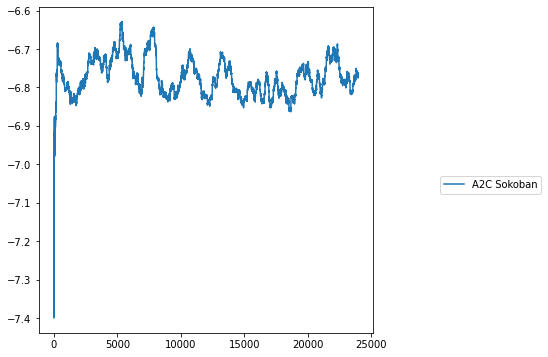

In [219]:
scores = [agentA2C_sokoban.training_scores]
names = ["A2C Sokoban"]
plot_scores(scores, names, smooth = 1000)

### Results

We see from the results that the A2C agent which was able to successfully solve the Lunar Lander environment is not able to solve the Sokoban environment in 25000 episodes. It is possible that running for more iterations we will see some learning but it is preferable to improve the agent first.

In [169]:
env.reset()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 1, 2, 2, 3, 3, 2, 4, 2, 2,
        5, 2, 2]])

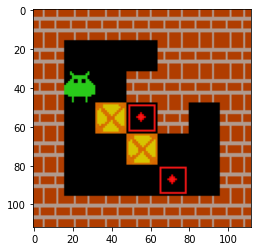

In [224]:
show_state(env.state)

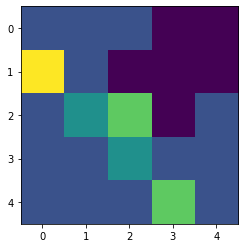

In [223]:
show_state(process_state(env.state).reshape(5,5))